# Import the required packages

In [2]:
import base64 # is used to encode and decode data
import numpy as np
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from imageio import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

# Load the dataset

In [3]:
train = pd.read_csv('C:/Users/Devmallya Karar/Downloads/spooky-author-identification/train.csv')
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


# EDA

In [4]:
print(train.shape)

(19579, 3)


In [5]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar(x = train.author.map(z).unique(),y = train.author.value_counts().values,marker= dict(colorscale='Jet',color = train.author.value_counts().values),
               text='Text entries attributed to Author')]
layout = go.Layout(title='Target variable distribution')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

In [6]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## Store the text of each author in a Python list

In [7]:
eap = train[train.author=='EAP']['text'].values
hpl = train[train.author=='HPL']['text'].values
mws = train[train.author=='MWS']['text'].values

In [9]:
from wordcloud import WordCloud, STOPWORDS

In [10]:
eap_64 = b'iVBORw0KGgoAAAANSUhEUgAAAoAAAAGHCAYAAAAgIOMGAAB+7klEQVR42u3deXhV1b0+8HcNG2QKQ04YnFGrVisZGB3A2hZBIThACFasE3pltna4t4ND1fb23v6uV8CpoqKtViSISoBItVoVvIQhCdbWoSJWUECSIEEEstfw+yN7x0NMIEACGd7P85xHOTkckp191n73d03Cew9qnrz3cM4J770EIIQQUEo5AK7ma7dt2wZjTPtXX321izHmmMrKyqOfe+65Y40xvTdt2tS7uLi4mxDiKO99WwBHAUj+b1sA7QAIAGH0MAD2ANghhNjuva/IzMzcfvTRR39qrf34xBNP/GTw4MGblVLrvvOd72zWWu/q2rVrzW9LGWMEAKeUckII/lKJiIgOA8EA2HzCnvdeWGsFAKW1hhAirO21paWlWLVqVZf169f3Wbp0aeamTZvOXrVq1TcB9AbQ6Qh8+9sBvNO3b9+3zj///Fe++93vFvbv3/+jtLS0vV5krQ2cc1Yp5aWUPDGJiIgYAFtf4LPWCu+9AiCCIHAAbM3XlZSUYP369Vl/+MMf+nz55Zfn/fnPf+4DIB1Am9reV0oJKSUA+Pj9nHNwzsn4nwYga54ntX2LSf/vAAgppYveO/47Knrv2r6Vyq5du748fvz4vIsvvnjx8OHDt9b4ehCGoVdKWYZBIiIiBsCWHPpEHPqCILCo0ZW7detWrFy58uiXXnrpnFdffXXoW2+9dS6AM2t7ryAIgKpuWh+HSQDSey/2Eeoa5ccSQnhUdfN6IQS894Expubr3h01atTca665Zu555533Xo3qoDLGCKWUYTcxERERA2CLCH3GGCGlVEqpvbp0i4uL8frrrw946aWXLli5cuV3t27dOgi1dOEGQeCjsIdoTF0c9JpqWvJCCC+EcEop75wLrN2ruLkpMzPz2WuuuebJK664ojA5DIZhKKNqKBERETEANq/QZ60VQoivhb6FCxee+Pjjj1+6bNmyy7Zu3Tqk5t+Nxv4Z771P7iJu7odECGGjCmEQhnsdki/T09OfnDBhwowpU6b8I3pOOuc4TpCIiIgBsEkHPiR17cYzaavl5+efMnv27Kvz8/OvRNVEjeTA54QQNvr7Tb2y1zAnZVVl0AohdBiG1T9rt27dlt15553XTJ48eR0AWGuVUsryDCMiImIAbFKMMVJrLVBjAseiRYuOffjhh6/Oz8+/BsAp8fNKKUgpQ2utcM61hOpeg4RB51wQTybp27fvbxYtWvSLnj17AlUTTWzS5BMiIiJiADyiJKKJHEVFRVi+fPnAxx57bGxJScmlAE6qGfqMMao1VPgO+mBKaYQQOhov+P6MGTOyp02b9j4AOOeklJJjA4mIiBgAjwzvfdWqzIDPy8s79qabbrq3vLz8UgCKoe/QD69SyllrFQD07dv3l/n5+b/u1asXwGogERERA+CRCn/eeyWltGPGjPnes88++xIACCGgtfbee2OtZeg71BNXCCulVFE18G9z587Nzs3N/RcAWGtltCMKERER1YKlkgZmrVVSSjtr1qyznn322ZfiSp/33odhKIwxQbx1G4/WIQVtZa310SSQs8aNG/fR6NGjf/Tll1/G2+Ep3twQERHVjhXAhgsksNYGWutw/vz5iZycnM+ibmAbLdVCjXUSC1F9jNu1a7fqySefvOzyyy//BKja5YRdwkRERAyADRL2AAhrbdzdK+L1/ObPny9zcnI+A5CaHEyo8X8tSql4xxPk5ubeOHfu3NlRCBRcM5CIiIgBsN5BL160GVXd5UJKCaVU9c4byR588MF+kyZNygfQUwjhoq5eOoyklDZaPgeJROJ/t2zZcouUEsYYobXmyU5ERMQA+FXQAyDibdQAiHjHDQB1HqC1a9fi9ddfP3fJkiUjX3zxxYsB9AEAIYRP2nOXjsCvNAgChGEoLrroorufffbZW9u1a8dKIBERUWsNgDXDXtR9axGt11dTWVkZ3nzzza4Aznz00UdPrayszCooKDgTwDcAHJP82qgL0iJpuRc6cr9qKaVwzqFjx46Pf/LJJ9empKSwEkhERNQaAmBSN64CIIIgqLX7FgCWLl3aadeuXWc98cQTZ61fv/7stWvXfgvAWQDa1PX+QRC4qm15rfDea55STYvW2htjREpKSsGGDRsuTklJgfdeCCEYAomIiAGwJQW+eN/dfVX3XnrppS4LFy4854MPPhj+4osv9kdV9237OkIeovewABBXD7mWX7MJgdYYozp16vT6xx9/fH6XLl3YHUxERAyAzT3wxRW+ugJfWVkZXnvttdOfeuqpwa+99trwsrKycwH0qPle0Zp9DlVLt8QzShn0WlAI7Nq16+zy8vIbo3PfV63UQ0RExADYHEKfiKt8QRBUV+ZiJSUleOONN85ZvHjxxUuXLv0OgIGoseh1FPYsAMeKXuuglPLWWpGTkzNh3rx5jzrnlBDCMgQSEREDYNMMfEgKfAJAmPz10tJSvPHGG6c/9thj2YsWLboMwNk13yPqxg3jtfsY9lolr5QS1lrMnDnzzKlTp/7DWquVUoaHhoiIGACbRugTxhghpVTRBXqvb3Tp0qXdlyxZMvypp566rKys7LsAOtUIfNWTM1C1LRjDHkEI4VBV7f3ymWeeSRs7duyX3DuYiIgYAI9c4Ntnla+kpEQ/9thj31m2bNnlxcXFwwGcUCPwwXsfxu8BVveo7hAY79CyoaSk5Pj09HSEYSij4QREREQMgIch9Mm6xvItXrz4xAcffPDyxYsXXwGgX/LXojF8yV263HWD6i3eMaRr166r//Wvf/Xv1KkTjDFSa80QSEREDIANzTmXPGN3rypfUVERli9ffs5jjz12RUlJyWWosdByEATWe++stRzDR4d+8kfb9aWkpLy2YcOGb0cLRTMEEhERA+Ch2l/X7osvvtiloKBg1J/+9KdxpaWlw5A0Wzeu8hlj2K1LjUJr7YwxMiUlZemGDRuGMwQSERED4CGIK33RzhvVXbtbt27FsmXLznz88cfHLFy4cAyAbyX/vaTJG6zy0eEOgQs3bNhwCXcLISIiBsADEI/p01qL5NBXXFyMOXPmXLh8+fIrioqKRgHoFn8tqvIZay2cc6zy0RENgZ06dZr/8ccf53C3ECIiYgDcD+ec8N6r5PXUSktLceedd35n7ty5N2zdujUHgIq/xhm71ERDYLxbyL3l5eU/BHcLISIiBsCvi9bp01LK6nF9DzzwQO+HH3745rVr194AoF1S6PPeexN17XLGLjVJSilYa5Gbmzt97ty5M1G1ZqBjCCQiolYfAI0xQmutABgA2LZtG37+85/nPvTQQz8B0Dc59FlrLbt2qRmpGvznPXJyci6ZN2/eQu+9jBaQJiIian0BsGbwW7FiBX7zm9/8KD8//+eIxvUppSCECFnpo2bMKaWktRZz5849ITc392PnnIr2jiYiImodAdA5h2iMnwWAwsLCttOnT7+jsLDwxwA0UDV71xjjvPeah5Wa/Qfjq91CPiktLT02NTWVk0KIiKjF2G+FzjknpZRQStmVK1diwIABPxs0aNDuwsLC/wCgtdZGCOHCMJQMf9RSeO/jit8xp5122hwAkFKiqe6dTURE1CAB0Dknqq550pWVlWHKlCnXDRw4cPuqVat+g6rkZwB4Y4xmVy+1RFG3ry8rK7tm3LhxlwLwiCreREREzVmtXcDW2uru3pkzZ54xffr0pwBkxMHPGMNJHdRaVE8KmTt3brfc3NxtxhilteZ4QCIiahkB0HsPIYQCYDdv3oyRI0fet2bNmslA1YzeMAw96tFtTNSiPiRfjQf8V3l5+Yldu3aFtVYopdgfTEREzTsAJg9wnzFjxuk333zznwEcp5SCc84c4vg+H11IPQAnhPBKqQb5Aay1iLaMi8no35NJ4ZbVSjokUkrrnFMpKSkLysrKRmutOSmEiIiadwBM3vc0Jydnyvz582cBgFLKWmvrk9T2Cnhaa58UvBQAEYbhYf/hgiBI/qND0vZ0NcKjxN7VUAZG+hqttTfGiJEjR/40Pz//d+Ai0URE1FwDoLVWSCn99u3bceqpp8747LPPpkUXNFfL5I54WyyrlIr/XwDQ9Qx4ZQA2pqambjznnHM2WWu/EELsBLATwJfRf7+IAmVbAAGANtF/A1QNwG8LoJ33vqtSKmX58uWdy8vLOwDoCKBT9N8OADofQmCsDovR/sYiutgLhsNWzUsphXMOY8aMuSovL+9JcLs4IiJqjgHQOae2b99ujzvuuLwvvvhiTLQVVm0VvfoEvS0A3rv44ovf8d6XDB8+fP03vvGNT40xG4877rhtGRkZh+0HKysrw5tvvqmUUqnW2m5a69SCgoJu69at6ymE6C6l7PXmm28eV1ZWdgyAowH02t97KqUgpQQA47333Mu4dYZApZSw1mLMmDG5eXl58xgCiYio2QXAyspKDBo06O6ioqJftGnTJrTWVq394pyyttaJjh7A2qysrLd79uxZNHz48L+fdNJJ/+zVq9f6rKysev2bAFQYhg1ytYyqdh5VFbuDHo8VBca2SqljwjDs9eijjx7jvT9z48aN3yopKTkZwCmoqizW9j1wEezWGwIvy8vLe54hkIiImlUAvOWWWy685557lrZt29bv2bOn5tWrAkDJsGHDCk877bTlF154YfHAgQM/TiQS+3pPaa1VzrnkwJg88SOuLjbMlfjry9iI+PkowMZj/Kq/ViM8mvoGxyVLlgQATvnzn/98xquvvjrsrbfeOhvAt3gatfoQyEogERE1rwDYqVOnt3fs2HFm9OedmZmZC84777z8ESNGvDZs2LDP6vp73nttjIn/bJMDXnO5ACZP+kga64coMAoA0FpDCFFnSHzvvfewbt26kydPnnzrRx99dLWU0keLaFPrCoET8/LyHorPK4ZAIiJqyrQQoqJr164vXnXVVf996623vlpLdS+5ohdP/vBCiLDGLNvml36/ukh7IQSSlvRwNYOi917s2bNHCyHUUUcdVRm/5rTTTsOGDRs+9t5XJP1dxVOrddxAWWu9UkrMnz//wZycnJS8vLz/jhaOZiWQiIia7gXs888/R+fOe02YVWEYSiGEjRa6bbUXsqgqKIUQSim11+yX/Pz8k3//+9//YPHixVcDOIGnUquWXAmckJeX9yjYHUxERE05AEbdoDIMQ6mUslzYtmpRbGutCoJgr4kl+fn5p8yePfuq/Pz8qwD0rk7MDbNYNjXzEKi1FsYYTJ48+YL77rvvr9FewtwyjoiIml4AjCdrtPZKRVzt01orANXVvlWrVnW68847r120aNEkAKclhz4pZWiMUVwfkKLPkBFCaOfcrpUrV7bv378/jDEiaWF0IiKiJkEKIdCau3iNMcJaGwghoLV2AMLS0lJMnTp1ePfu3QsGDBhQsWjRohkATlNKIQiCUAjhrLU+DMMgWiyb4Y/gvddKKQOg3a233vrz6GlWhYmIqMkRtSyj0uIldfHG6wcCAB544IFvPPzww5PXrl17Hap2Fam6gmsdRos+82JO+/5ACRHvoPPZ9u3be6SkpHDPYCIianJka/lBo2qfdM4FUkofBIEBYNeuXdtm8uTJNwkh3pk8efL7a9eunQ6gUxAEXkppAHhjTMDwR/U8z2TU5dv9iSeeyAIAYwxnhRMRUZPS4iuAtU3oKCsrw1NPPTXwrrvuurm0tHRc/FqlFIQQobVW1bIPMlH97qqkDJ1zQUpKygvbt2+/FIDy3lvOCCYioiZzrWqJP1Rc7QOQXO3zCxcuTLvkkkt+kUgkNk6fPn1FHP601lYIYay1iKp9DH90KDcdWmuNioqKSx544IEzUTXMgFVAIiJqMlpUBdAYI6I1+6q3KCktLcVdd92V/dRTT/2wrKzsgvj5IAhgrTXOOQVO4qCG/mB9NRZw19y5c7vl5ubuds5JKaXj0SEiIgbAQ5S0fItE1b6+AIAHHnjgpGhCxw2IJnRIKSGlZBcvHa4QaL33CsDbO3bsOKtjx45wzkFKnnpERHRkNdsrkXNOhGGohRAiWr7FFBcXY/LkyT8QQvxt8uTJ69auXXsLkiZ0OOc8u3jpMN6cqDZt2lgA3/rhD384NDpv2RVMRERHXLOrADrnBAAVzdAFAOTn5/f69a9/Pb2wsHAqgPYAJ3RQE/mACRHvEPPhzp07T27fvr2qrKz0QRA4TgohIqIjpdkEI2OMQDSpQ0ppSktLMWvWrMGpqakvjho16tPCwsJ/B9CeEzqoKfHe6yAIHICTfvSjH10GwLZp08YJIWQYhoExRkY7yRARER02Tb4CGG2lpRCN7ystLcXtt99+wwMPPPBLAMcDX43ti9ZbY+CjJpcDEU00mj59+uXXXnvtc+np6TVfE4RhCCGEVUqxOkhERK0zABpjpNZaINqpo7CwENOmTfvRypUrbwXQGQCCIPDWWsuZvNTcpKWlvX7eeec9c+21176QnZ39Sc2vW2sD55yPAqFnICQiohYdAKOKnwDgouDXdvr06T8vLCz8DwBtAEBr7ay1YPcuNTNea+1q2RlkY3p6+otDhgx54eKLL35l+PDhX9b4urTWKuecV0pZIQQDIRERtYwAWLOrt7CwsMv06dNvLywsvDl+jdbaWGslgx819yAopbRKKe+cC6y1Nb/+7vDhw5dcfPHFzw8ePPiNjIyMml9XYRgKpZTlHsNERNQsA2Atwe+o6dOn/7awsHB6cvCLqiYse1CLC4NCiLiyJ51zqpZAWDhy5MjnrrvuukWDBw/+eyKRYBgkIqLmGQCdc0JKmRz85PTp0+8sLCz8RVLwC40xmsGPWlkgjMf9qTAMa1a7v0wkEgXjxo17+Pbbb/9zjTAYhGHoGQaJiKjJBcBo5w6ltbYAsGLFCtx8880/LSws/DUAHQU/VvyIvh4IgzAMk7+2KzMz80/XXHPNQ1dcccXqtLS05BuswDnHGcVERHRkA2AU/LTW2gBAeXk5brjhhikLFiz4LYAODH5E9fjACuGEEE4ppcIwTP6clGZmZj5x9dVXPzJ+/Ph3U1NTq78QzSi2WmuGQSIiOnwB0ForlVIegN+1axduueWWSx966KHfA+geBT9rjJEMfkQHFAbjsYO6RmXwo1GjRj0+YcKEx7Kzszck/5UwDBW7iImIqFEDYM0lXR566KH0W2655fe7du0aCABKKRcNeOesXqJDC4MuCoM1u4n/kZ2d/ciECRP+MGrUqLKk5wNjDLuIiYgYABuO9x7OOaWUsgCwYMGCbjfccMMD5eXluQCgtYa11nE5F6LGCYNaa1tziZnU1NQ3rrzyyv+59dZbX0iaPBJXBY2U/DgSETEAHqSou9cBwMqVKzF16tRfr1y58udJwc9473Uj/TzVA+adc8J7H++zyhIHtUbJn4fAORc/v2PAgAEP/fKXv7w/Ozv7X/GT0WuM1prdw0REDID1Ey3rUt3dO3369Etmzpz5BwApACCljLdsa/ALXHTBqmsNNQRB4AGYeAYyK4/UGsNgtPj0XpNHEonE61dcccUdt99++6tJE0e0Mcaxe5iIiAGw7qvK17t7e9xwww1PlpeXfw9o8Jm9+1sjDQD+OWjQoGUfffRR982bN2cAOKaWQOi895ZhkFrlhz4aL1ijKrh+8uTJv77++usfzczMrH4pJ40QETEAfo21ViilAMBv3rwZo0aNum3VqlW/ioKfN8Z4HNoEj/oEvr8PGzbslVNPPTU/Ozt72dChQ3clf3Ht2rX48MMPv/XHP/6x/0cffXRBcXHxpQA6JYVBHw2aZ6mDWh0ppalRFdwzcODA+37xi1/ck52d/WnyfRMXmSYiYgCEtba66jdt2rRvz5o16ykAR0cXlYPt7q1P4Fs7bNiwl0aMGLF48ODByzIyMkzNFzjngugi9bWvlZWV4fbbbx+5fv36s5csWXIlgBN4GlCrbwiqqoI+qtYDALp16/bSr371q1/n5ua+xkWmiYhaeQCMxvoBgF+9ejWys7Nnb968eQIAKKWstbbe6/kJIaoDX1RhqO1lq4cNG7Z0xIgRSwYPHvx/GRkZvpYwGjjnPAAXL3Yb/VzCWgvvvRJCCK01AFT/I9u2bcNtt9126X333fckgA5Jf4+otfJaa1OjezheZPqx8ePH/4OLTBMRtbIA6JyTUkoHALNmzRo4bdq0hQC6K6XgnNvfsi4+CnxOKeW994ExprbX/d+wYcNeHDFixNLBgwcXZmRkoK7Al1QtPKAAG1UvhZQyBIAFCxa0HT16dKkQoqP33oHrEhLVOmkEwIZRo0bNmTBhwuPZ2dnra34uvfesDBIRtaQA6L2XQgi3adMmZGdn37NmzZofAlVjiJxzuq7AFy1OizoCn01LS1s+YMCAJUOHDn3p/PPPL2rowLefMAjn3FFa690DBgyYuWrVqqlHHXVU5e7du9vw1CCKGom6F5n+Z3Z29pwbbrjhiRrjBbm2IBFRcw+A3nsIISQAN3/+/O45OTn/B+AkKSVcVR+RTAp8cUATzjldy5IsOxKJxJtDhgxZfOWVV746ZMiQt5MWpI1Ja61qjMBXm8rKyqBNmzbh8OHDf7Z06dLfJP/o4MQQoq+FwdoWmQbw9siRIx+77bbb5vTv3//zpJssri1IRNTcAmAU/gAAU6dOPfu+++57E6he2kVGF4N9rcG3KSMj4/XevXsXjB8//rUhQ4Z8VFvgM8Yo7/1hCXw1RWMa/d///veU//u//xu0ZcuW7b/85S9XtGnTBt77yjgEGmN0tKg0EUUV/trCYCKRWHDrrbf+1/e///2VSZ93ZYzx7B4mImriATA5/OXk5Nwwf/78h6WU0Frvds4dVcf4vfczMjL+Onjw4CUjRox4fdiwYdtqeY0yxkjvfdw97JvaBSEtLe3+0tLSSTw9iOodBm00izhIev6j7Ozse37xi1/8fuDAgZXxk2EYaq21YRAkImqCARBVlS+fm5t787x58/63jtesGTp06F+ys7MLTj311P8bNmzYnlpeo6NB5HF1zzfFht97L8Iw1G3atAkBYOHChSc++uijF1prIaW0+fn5MwB0kFKGSilYa0UdYx+JWnUYjCaP6OTxgpmZmY9fd911d06ZMmV9chDkOEEioiYUAMMwlEEQuD/+8Y8n/eAHP1gXPf1pIpF4d9CgQX/+3ve+95fzzz9/dW0TNhAt55LUndusxv5ElU+BqjGA1R588MFvTJo06f3k56JxkBwrSFRb41L72oJL7r777l9MnDixJH7OOaeFEKwIEhEd6QBYNRxP+NLS0javv/76aaeccsrbffr0qTXI1bYGX7MvYXgPY4wEoOKgp5QKL7nkkl8uXLhw/OjRo19ctmzZGVu2bBka/xWGQKK6P1I11xZMJBIrrrjiip8n70FsjNFKKQZBIqIjFQD3Ie7OPSITNo5kIKzt57z55puHzJgx47UaITA+oLyKEdUgpTQAdNIi0+/edNNNP73nnnvy27VrB+CrHggeLSKiIxQAvfcinu0b7/nbWu/Oo+OkhBDOGKO11g6AvfTSS8e88MILeUopb60VUbcwzyyi/QTB5HGC7dq1W3XPPfdMuummm1bHL3HOee47TER0BAIg1R4EhRCw1opofBOCIFgP4MRoweutAD4EMBCARdSNTES1NEBVN5cyXlUgNTX1+V/96leTJk+evAnYe89xIiJqwBtxHoIDvmABAOIlL7TWGD58+AtxOBw5cuSN3bp12xq9lumaaN83VNIYAyGEkVKirKzs0ilTpnzar1+//928eTOi8KeccxxSQUTEANhkLl4AgHbt2r0HAGlpaYvy8/Of//LLL4dHL2H1j6h+nyXtnIu7hrFmzZqbe/Xq9a+ZM2d+C4CVUnrnHNsrIiIGwKZx3QKAnJycIgArly1blg0Au3fv5vqARAch2kLSR5W/46dPn/63fv363bZp0yZIKR2qqoE8UEREh4hjABvjoEZdv0IIz+3jiA76c+SklDLaZm7t3Llzs3NzczcAgLVWKqWYBImIDhIrgA1HJx3Pf0X/ZbomOkjee5lUDUwfN27cx6NHj560e/duKKWctVbzBpaIiAHwSF+sjLVWAcCpp576BgBw9iLRIRPWWiWEsACwYMGC+7t27frK888/3yFeNNpayyo7ERED4BG6SgkRbwuHH/3oR/8TBUANVgGJGuIGS6FqRxG/e/fuCy677LIdN9988+XR58zHN19ERFTP3MIulAa9SFUvE9OpU6fnv/jii0t4VIga+K5VSuucUwDQs2fPeYsWLcrt27cvAIhoJjEbNSKi/bWlPAQNmKarqoACAD755JNLp0yZchmqFoMGWAkkahBR+PNKKWzevHlsv379tk2bNu08AJ7LxRAR1TOzsALYuI499tj5n3zyyWgpZeicC3hEiBrwDlZK45zTANCvX797Fi5c+KNevXoBVcvFWCmZBYmIam0/eQgax+7du9sAQEZGxmoAiPZSJqIGFIU/p5TC6tWrbzn66KP/+cwzz5yCqsWjYa1lG0dExAB4+MRrlA0ePPjl6CkuDk3USO2YtTaedX/KuHHj/jl69OhJu3btglLKGWN490VEVAO7gBuJc05IKf0XX3yBTp06bQbQQwjhvPcM3USN1aAlfcZSUlJefPXVV0dmZWVZcIIIEdHed848BI10YKX0xpigY8eOmDBhwmQA0Frz4kPUiKLw57XWvqKiYnjfvn2/mDZt2gWIJogYY9jmERGBFcBGFVcBd+zYgZSUlPcAnBoEwZ4wDNvy6BA1+k1Y9XIxffv2veeVV175UUpKCqy1iou0E1GrbyN5CBr1AuSttbJTp054+umnzwYAhj+iw3YDpgA4rTXWrFlzS8+ePdc899xzbaPwp3jzS0QMgNRooskgYty4ceWzZs0648wzz3w8Coc8OESHoY0zxkBrbXft2pV1+eWXl86aNetbAKwQQsTrdhIRtTbsAj5MkncJEUL8E8ApnBRCdBiTYFKX8OjRo6+cP3/+nwDAGCO11o5HiIhaVZvIQ3CYkrYQ2L1791EA8N3vfncJAGitOQ6J6DCJu4SFEHj22Wef6t+//z3bt2+H1trFwZCIiAGQGlw88Pyb3/zmX+JcyKNCdHjbPO+9l1Ji9erVPzzhhBP+unr1akgprfeeIZCIGACpUVgAGDNmzBvRnzW4RzDR4Sacc9Bau+3bt5/fv3//Tc8++2xPIYSNAiKPEBG1/IaQjd3h470XQggPAEKIzwCkcRwg0RG8A04aFzh16tSzZ86cuQL4agknHiEiarHtHw/B4c2AiLaESyQS/xcFQY4DJDpCnHMq/gzOmjXr/3Jycq6JgqH33nOIBhExANKhE0IgDEMBAAMHDlwFAEpx2BHREb0rqxr754QQmD9//pz+/fv/1+effw4hhA/DkG0kETEAUsPp3bv3qjgX8mgQHfm2MGlyyE+PP/74F3bu3IkgCDhDmIgYAKlBWAC45JJL/hH9mRNBiJqG6skhO3bsGNW9e/e/LViwoK2U0gJgCCQiBkA6JB4A9uzZsxGoWiCaiJoOY4wUQtgvv/zyW6NHj94yf/78k6MbN84QJqKWc8fLBu0wp7+9ZwLvAdBGCMEB50RN7e5YSueckwCQk5PznXnz5r2KqErIGcJE1OzbOB6CI+qL6L/choqoiYnCnxNCIC8v75Xc3NxJADxnCBNRS8AK4GFWRwWQuxAQNeEsKISQ3nt07979f99///1bOnfujDAMZRAEvHkjomaJFcDDzNqqZf+KiooAoI1SClwImqhpt5Pee6+U8p999tkPjzvuuPx4hjBv3IiIAZDqJe462rx589EAICV/BUTNgLDWCiml27Fjx8ju3bu/tWDBAiWEsNZahkAiYgCk/VIA8OGHH34r+rMB1wIkahacc/EM4bNGjx69ZcGCBccppThDmIgYAKl+XnjhhTOj/+VVg6gZ8d4rKaUDkDp69OiPp02bNghV4wSFcxwSSEQMgFQLIaqKfW3btj2DR4OoeYorgUDVHsJjxoy5ElUzhMEZwkTULPIIuy0Oa+UAQggNwAgh/grgfCGE8d5rHh2i5pkFlVLSWovLL7/8jj/84Q+/6tChA5xzgmsFEhEDIMUBMHkJmA0AjhVCOM4CJmreH21RtZo7OnToMPvTTz+9MSUlBcYYqbVmnzARNUkMHkdONx4CopZzIx0Egd+5c+cNxx133IKKigporV0YhmxjiYgBkPa+aACA1trwUBA1f2EYCq21r6iouOy44457jWsFEhEDINUmiC4abXgoiFoGY4yQUrqKiooh0VqBiNYKZFtLRAyABADQAHDuuedeJ6XcHT3HAZlEzVyNtQI/mj9/fgellDPGsBJIRAyABHfeeectWrZs2Rzn3AcAEC8rQUTNW7RWoAVwQk5Ozsfz58/vobW2ABQn3hERA2ArvC4kHfPdX3755UcAcOaZZ74DAEopXhmIWsodnnNKCOEAdMvJydk4a9asMwFYIYTkgtFExADYiggh4JwTADBlypTrr7766tkAcMwxx6yJv05ELeiOz/t4wWg9bdq0t0ePHn0pACelhDGG7S8RHblMwu6II2/q1KmX33fffc8GQRCGYRjwiBC1OMkLRv/yySef/HW7du1gjFFKKcubPyI63HgHeoQYY+SuXbsCABg9evSG6GkOEidqoW2ttdYLIbBgwYK7e/bsWbBmzRpora2omibMBEhEDICtgdbaRYPCUVpauiHp98GSLFHLJLz3iNYKHN6vX7/y+++//xwAPhr/q40xDIJExADY4q8G0bZwJ5988mYA4MBwopYvXisQQNcpU6Ys79Wr12OrV69WAIzWOg6CksNziKjR70jpyKixN/AWAN25NzBRq1E9LhBAOHDgwF/MmDHjdwMHDqxun8MwVEopK6VkQ01EDYpB4whnwKTfwbr4osDDQtQ62l9rLaL1AoPCwsL/HjRo0I6zzz77N/n5+UcD8EEQmCj8BawKEhEDYAshhEC8O8C3v/3ttQAQdQERUSvhnFMAfDQmuOOKFSt+NmrUqE8SicSr06dPH15aWgoAodbaCSFgrQ3CMJTee44XJCIGwOYqvqPPyMj4C48GUeu9H4xuBp3WOpRSoqys7NszZ84sSEtL2zpgwIBfL1q0qDcAKKXCIAicEMJHYVDHgZAVQiJiAGw+LAAMHTr0zejPATgTmKjVtsnGmMA556WUJggCDyCxatWqn2dnZ38ohHh31KhRt+Tn5x+bFAZNHAiFECoMwyAMQ22MYSAkorrvOtlAHFnOOSGl9Fu2bEHPnj1LAaSiahwgwzkRQQjhlFLWex9EE0ZiHw4fPvz5U0455S+jRo1aMXTo0PI63iIIwxBCCBstN+O58DQRMQA2jRAYSCnDs846a/bbb789QWsdGmO4IwgRJfNCCKu19s65mmEQALYlEokVgwYNeuV73/vesgsuuGBVnz59bC3vo8IwlACsUspzhjERAyAdIWEY6iAIzMyZM78zffr0vwRB4MMw5C06Ee0rDMYTR4RzTtcSCAHgvfT09NeHDBlSMGLEiOXDhg37rJbXBGEYei43Q8QASIdZ3A1cUVGBzp07hwA0qsYBMgQSUb0DYdRd7PFVla+mstTU1GXnn3/+0iuvvPLlwYMH/zMtLS356yoMQ8EwSMQASIcvBAZSyvD0009/5L333rue3cBE1ACh0CqlvBCirirhp5mZmXnXXHPNH6+44oo1NcJgYIwxXJqKiAGQGlHcDfzII4+cdcMNN7yltYYxhgeGiBoyEMahELWMI/wiKytr4dlnn/3kHXfcUZBIJOLnlTHGa625SD0RAyA1eMvsPeKZeUKIdwGcJoQw3nvNo0NEjRUIlVJWCBGEYZj8tc8HDBjwu5kzZ94zcODA3QyCRC0PlxppKklcCIRhGADA9ddffysAaK35+yGixiwASGNMvEyM01qbIAgcgC4rV6789aBBg3YNGjTod4WFhR0A2Cj8KWMMxycTtYAGgEehiYgng3z55Zfo0KFDBYBOQgjnvWcQJKLDeUPqlFLOGFPdAzFw4MB7ZsyYcfvAgQO/iJ7SzjlOFiFqphgsmtIvQ0pvjAnat2+PCRMmTAcArdkDTESHV1QZ1KjaozgEgMLCwlsGDRq0Y9CgQb8tLCyUAIyU0ltrlXOOFUGi5najxwpg0xJXAXfu3ImOHTtuB5DCKiARHelMqLU2SSsThP369fuP/Pz8e3r27Bm3XVoIYbjLCFHzwFDR1H4hVVVA1aFDB1x//fXXAoBSii0qER3RYkEU/rzW2gAIVq9e/T+9evUqmzx58lVlZWWQUhohBIwxmoUFombwoeYHtelxzkFKiT179qBz587Fe/bsyZBSGucc+4OJqCnwSilvrY2LCOtvuummKffcc8+Sdu3aAQDCMJRaa8eKIFHTxApgU/ylSAljjG7bti3uu+++y6Ln4t1BiIiOePHAWiuFEC6aNdz7oYceWpyamrryoYceGgAAQRA4IYQMw1Cy0EDUBD/E/GA24Vts76UQwmVkZNy1du3aXyqlXNIdNxFR07iQVM0alvHi9ampqUvvuuuuyRMnTlwX39daa6GU4hqCRAyAtD/xhJDS0lKkpaWtB3CiEMJ67xWPDhE1wSBohBDaORcHwWfuvPPOH06aNGlTHASNMYi2p+PFh+gIYjWpKf9yoiUWEokEZsyY8Z3oOQV2BRNRE+S919EYZiOlRFlZWe7kyZM/7dWr16OrV6/uBsBF4wI9AB2GISeMEDEAUh0h0AJQ06ZNWz9ixIifsBuFiJo651x1EFRKYfPmzdf179+/LCsr6/cPPPDAidHLTBAERggBa63mWoJEhxe7gJtHYyqklN57jyAI1lhrs6SU1jnHrmAiauq8lNLVaK8+6dOnz8J/+7d/mzVp0qR3agRHq7XmhYmokbEC2Bx+SVVrA0ohBJ577rkLAEAIwa5gImoWhYYo/HmttVFKAcAxb7311sTJkyf/QwixduLEidnl5eWQUpoo/AXcb5iokT+YrAA2H845LaU02dnZVy5atOhJrbUzxjDEE1Fz4oUQXillvfeBtTZ+fuOUKVN+de211z6SlZUVP6eMMV5rzWEvRAyArToAQkopjDE+kUgUbN++fTi7gomoWV+EhDBaaxWGYVzx+2LgwIG/nTFjxn8NHDjQRM/Fs4e5sDQRA2DrZK2VSin3t7/9TfTp02ePlDLw3nOvYCJq7kHQKaW8Mab6hnbgwIH/b8aMGXcPHDhwe/yyMAyVUspIySaP6FDwE9TMKKWcMUadddZZfsqUKYOjqqAExwMSUTPmvZdR+HPRfsMoLCz88aBBgz7v27fv7Pvvv/9oAD4IAiOljCeMsBxIdLA3XawANsuGEkIICcBlZ2f/eNGiRb/jeEAiamlNndbaGGOC+InU1NT822+//e4rrrhiZSKRAAA451S0XBYRMQC2fPHSMNZapKam5m/fvn1ktNQCQyARtbQgaOO1BSP/nDhx4m/uvvvux7t16wZU7U3soxnGRMQA2LIZY4TW2r/11ltIT08vA9BNCMHxgETUIoOglNIqpXQYhvFzpZMmTcq9//77XwEA773gFnNE9cOg0Ixprb0xRvXp0wczZ868AADHAxJRSyWcczoMQwghXBAEDkDigQce+Mvll19+686dOyGE8OwFIarnB4oVwGZ+S1w1HlABsBkZGf+1du3anyqlrLWWfSFE1LIvYEI4KaW01qJDhw5/2LRp09WdOnWqXi2BR4iIAbBFi8cDbtu2Dd26ddsJoD27gomotQiCwIdhKDp37rz8/fffP6979+7w3ishBCeHENWBAaEl/BKrtooLunbtigkTJvwIALTWPDBE1CqEYSiEEG779u3n9ujR4/158+a1FUJY733AIgdR7VgBbCHiKuDOnTvRsWPHLwB0YBWQiFrZzXC8M1LZvHnzzsrJydkEANZaoZTixY4o+fPCQ9BiGj5vjAk6dOiAG2+88cdA1SQRHhkiakU3wkoI4QCkjh079tPc3NwrAEAp5a21ycvIELV6rAC2IPGyMP/4xz9w5plnGiGE8t47Bn0iam1ZMG73evXqtSA/P390375945CohRCGewpTa8dg0IJorb33Xp9xxhnIzMy823sPrTVveYmoNV7bvJQSmzZturxfv347pkyZklNWVgYppRFCIAxDzQIItWasALYwxhiptXbFxcUqKyvLCCHgq37JvN0lotaXBL8aFwgAf5s5c+ZNU6dOfTP+urVWCyGslJIXQ2p1d0nUgmitnfdeZWZm2gEDBjwUVQENjwwRtUZR+HNBEHgAZ02bNm15amrqkoceeqgPACiljJTSO+cCYwxvlKnVYAWwBQrDUAZB4AoKCrpefPHF5UopWGtZBSSi1n3BE8IJIWTSZJDim2666Y7f/OY3C7t27Ro/p4wxXinlOE6QGACpWYl2B5EAXGpq6pPl5eVXSilD51zAo0NErV00DlBbW71O9Kbs7Oz//sUvfnHfwIED4x4TEYah0lpzwggxAFLzEW+FVFJS0ikzM7OCYwGJiGpcAIUwWmsVhmF1u5iZmXn/dddd97spU6b8K34uDEPNIEgMgNRseO+lEMJlZWXdX1xcPElrbYwx3CKEiGjvIOiUUt4YU72Herdu3f5y9913/8fEiRNXJwVBqbVm1zAxAFLTljQjWGdlZYWsAhIR7fu+WWttnHNBPE4wNTX1tbvuuusnEydOXBW9RlprIaVkEKRmjbOAW7BoRrDOzMw0mZmZ/8l1AYmI9kkYYwLnHKSURkqJsrKy8ydNmrQykUi8+MADD5wEwEUTRKQxRrKIQs32ZOfJ27LFu4MUFRWhb9++8S+bu4MQEdWDlNIAqN5GrmfPnn9YtGjRD/v27Vsev4ZjBKlZnts8BC1btDuIysrKwqhRo24GqvbF5JEhIto/55yOK4JKKWzevPkH/fr1K0tLS/vD/fff3xsAgiDg7iLU7LAC2DoaMCGl9GEYok2bNpsA9BRCGO89J4QQEdWfl1K6pJ1F0K1bt6V33333zydOnFgUP8fJItQcsALYGn7JUnpjjAqCAFOnTh0NAEopxSNDRHRARBT+fDxGsLy8fNikSZPWpKWlrb7lllsuAIAgCJwQQlprmQCp6Z7MrAC2ktvWqsWhBQDftm3bP1dWVg6tsUcmEREd+A32XmMEE4nEX3/1q1/dNGnSpPeil2jvPccHUtM7d3kIWknSFwLx3WheXt7YKBQqALwDICI6SMljBKWUKC0t/fbkyZPf7dWr15MrV65sD8AIIWCM4fWWGADpyFBKOQBy1KhRn2dmZt7mvUcQBFwWhoioAYNgNFnkyoEDB35x+eWXX79r1654CS7pnGMpkJoEdgG3vkZKSCl9aWkp0tLS/gngFCGEjaqBRETUAKSUxjmnAaB9+/Zrfve7342bNGnSBwBgjFFKKctuYTqi5ygPQatrlLxzTiYSCcydO/ccAM57r4QQrAQSETXczbYG4JVS/ssvv+w7efLkf/br1++/t2zZAq21FUIIThIhBkA63CHQee9lbm7u1nnz5p2VdC6wHExE1HCEtVYIIYxSCmvWrPlJz549t06bNu17cTi01ir2xNEROTl54rVe1lqtlDLjxo274plnnvmTlBLxTDYiImpQceCTANCzZ89nFy1adGXfvn33oGp5GUgpeUEmBkA6DK1R0tIwaWlpC0tLS7O5NAwRUSNedIVwUkpprQUAM23atFEzZswoiG7KlVLK8igRAyA1ujAMZRAErri4GFlZWdwrmIjoMEieJNKjR49H165dO6FHjx4AoJxzVko2wdTI5yAPQesWBIHz3uvMzEyMGjXqKgDgJiFERI0rCn9OKYUtW7Zc37Nnz40zZ848C4CVUnLdQGp0rAASorEnqKysRNu2bd8FcBr3CiYiOjySh95kZWX94tVXX/1NSkoKwF1EqDHPOx4Ciu42dZs2bTBz5szxAPcKJiI6jDfhSgjhtNYoKir6dc+ePQsXLFjQDdEuIlw8mhoDK4AEYO8JIW3atFkahuGFUsrQORfw6BARHZ6mWClVvW1nbm5uzty5c+cDgDFGRruJEDUIVgCp6k6g9r2CA3BtQCKiw9YUW2uFlNICwDPPPJPXo0ePWTt27IDW2nGFBmIApEYR7xV8ySWXbB87duwl3nsopQRDIBHR4RMFPa+UwmeffTalZ8+eKxcsWHBUFAyrF442xgjvPbuH6eDuNtgFTMmirmAJwGVkZPxm7dq1P1NKWWst7zyJiI7AjXm0ePSuvLy8vmPGjHkHVcUbdgfTIWEFkPa+I6gacOwB4LXXXvu51rrYWqviLgkiIjp8rLVSSmkAtMvJyfnH2LFjvxuHv3/7t3/rt2rVqtTodawEEgMgHeJJIaU3xsjOnTvj+eefPx8AvPcK7AomIjrs4jUDhRDIy8t7+fLLL78RADp06JC6du3a7lEbzQNFB4RdwLTPRkdKafr27furoqKi29gVTER0ZJtlIYT03uOcc865e/ny5bfG13LeoBMDIDUYY4zQWvuSkhJkZmZ+KYRo573nNnFEREeOl1IK5xw6dOgw75NPPsnt3LkzvPdCCMELOtUbL+RUJ621t9aqjIwMTJgw4WrvPbTWHGdCRHSYRAtEh0EQhFrrUAhhvfe2TZs24c6dO8eecMIJy7744gsIITwXjKYDOrdYAaR9ibeJ27NnDzp37vy3PXv2fCt5E3MiIjri3vLepwOQ3nvHreOoPngRp32Kt4lr27atuf/++8dMmDDhXSEEzxsiosPj3fT09PeOP/74Lz7++OO2a9euTQXQBUBbAEcB2HX66afnRa9lRYfqjRVA2q/ktQFTU1OfLC8vv5JVQCKixmt2tdbCGFP27rvvJk477bQDaat59KheOAaQ9n+XULVNHADg5ZdfviZ6WvNuk4iocZpd55wFkPrd73738YqKCgCQ1to2UdsrogdQVcjRcVtNxABIDUop5bz3KjMz04wYMeL7zjlozQIgEVFjcM4pIQQ++eSTq4899tjZFRUVTilVGYah818Rvmr6r+ERowO+y2AXMB1AgwQppTDG+EQiUbB9+/bhUkrLDcqJiBqH1tobY0RKSspTGzZsGJ+SklK9RBePDh0KVgCp/ieLlLDWCq013njjjYsB+OgulXtSEhE1gjjsVVRUXHncccctrKioiEMhr9/EAEiHj1LKGWPUWWed5adNmzY8CoYceEJE1Lgh0FVUVGQfd9xxr0Yh0Hnv2fbSQWMXMB2waKaZAOATicQfy8rKxrMrmIiocWmtnTFGdurUaenHH388vEuXLnDOCSklL+TEAEiHR9zolJWVIZFIfAzguGiFeoZAIqLGC4HWGKO6du36VHl5+fikm3IeHDog7AKmgztxpPTOOZWamoq5c+dmRU8rcGkYIqJGY4xRSim/bdu2K8eOHZsbBUDeeNMBYwWQDon3XgohXG5u7oh58+YtUkrBWuvx1RpVRETUkBduIZz3XgIwn3/+edC5c2d2BdMBYwWQDpUDIJ955pnF6enp/2OtRRAEnBVMRNSIN95BEHgAevbs2UMAwFrLKiAxANJhvROFc84DwKuvvvrjjh075odhqBgCiYgalQGAgoKCc+PmmIeEGADp8J5EUnrvvejatSs++eSTUR07dlwShqGUUgIcE0hE1Cj33wBw1FFHbeOhIAZAOnItkRDxavXYsGHDiH79+v2Xc656uRgeISKiBuOttRoAbr311jlRG2x5WIgBkI4IrbX33osuXbpg1apV/5GTkzPOew+lFEMgEVEDtrXOOYwcOfLfBg0atMd7r7TWHHZDB4SzgKnBRbPRJACbk5Mzfv78+X8UQsBXnWwcp0JEdJDiRfeVUm/s2bNniFKKM4Dp4M4lHgJqhAbKe+8tAJmXl/dkTk7ONO89tNYCgJdSeiml4ZEiIjrQ++uqHZfmz58/TCkFY4xk+CMGQGoyooqfAyDmzZs3q0+fPr82xiAIAuGcE845HU0SISKieoi7eSdNmnT5pZdeussY0y5qa3lwiAGQmlYIdK5qWMorr7zyyx49etwbhiHOOOOMp04//fT/dc6BM4WJiOrFo2q3JRhjvvziiy+gtd6llHJCCFhrgzAMJcMg1fsazZOFDqerrrrqmr59+xbefPPN71x22WV3Pv/887dqreGcs3HXBhER7df7o0aNmj1hwoQ/Zmdnb0n+grU2cM5ZrbXjHsHEAEhHVFK1by9jxoy56tlnn/0DACilvLUW4EQRIqI6SSmre1cib2VnZ8+54YYbnq4tDHrvjVLKMwwSAyAdEd57GGO0UsoBcFJKAcDff//9J/zkJz+Zt2vXrgHcS5iIqB4XbyGc1to654Loxjn29+zs7D9GYfDjpOdVGIZCKWU4/poYAOmIB0IhhATg9uzZgyuuuOJHzz333P+LGjfrvWeXMBHRfppSIYSN1gasGQbfGzly5Mzbbrvtsf79+++On3TOaQAMggyADIB0ZBljZDy7bdq0aefOmjVrWXyH671nC0VEdIhhMJFIPHvrrbf+7vvf/35hIpFgECQGQGoaojGCEoB79tlnjx0zZkwxgES86CmPEBHRgYdBpZQwxiS3oW9NnDjxZ3fdddeS1NTU6iAohDAcI8gASHTEGGOU1trm5eWpsWPHvgPgG6wEEhEdWhiUUlqllA7DMH5u/cSJE3961113zY+DYBiGkjOHGQCJjlxL5b0WQpjVq1dj6NChaz7//PMsrbUzxjAEEhEdykW/qotYhmEYp7y1M2fOvGnq1Kkroj/LMAylUsoKIThzmAGQ6PByzkkppfviiy9wzDHHvFJRUXEBQyARUYMFQRcFQQBAt27dFt999903TZw4cWPSy1QYhsltLtcWZAAkanxhGMogCFxFRQWOO+645ysqKi7RWntjDFsfIqKGCYJGCKHjdQVTU1P/dMcdd/x23Lhxf4sni9RkrdVSSo4ZZAAkajzxDOEoBM6pqKi4JggCn9R9QUREh0hKaQDopAWmdyQSiZVnn332p9ba0iAI3r3++utfzs7O/jD5Jp0VQQZAosYMgUJr7SsqKnD00Uf/786dO2+ONkDngtFERA2ntskiNf1t8uTJP7zvvvv+EmdHay2iBf6pOYV+HgJq6qI1rURKSgq2bNnyw8svv/wO7z2UUgIAGx0iooYhnHM6DEMIIZyU0gRBEMYPpRQAnHX//fe/nEgkXnnggQdOBeCi8Cc5PKeZ/bJZAaRmc2vqvRBCeAAYM2bM1GeffXYmUNV1ES1oSkREjRkaaowZ7Nmz5x/z8/On9uvXb3t8z26McUopdg03cawAUnNqeHzU6Ij58+fPmjJlyveAqkVMtdZeCMFqIBFR496I62jhfqOUwubNm6/q37//54MGDfpNYWGhAGCicYHSGCNZZGrC11T+cqgZNkAQVbeW/rnnnktMmDDhqfLy8gsBIAgCF41d4c0NEVEjq7Fbkx04cOD/mzlz5n8OGDAgrgiKMAyV1pqzhpva746HgJrdXUtVI+Kdc/Kyyy4rLSsrGzZ16tQLAXwYrVkloxltRETUiKLw57XWFoAqLCz894EDB36elpb2+P33338CAB8EgRFCwFqrjTEsPDEAEh3ynaez1koAmDlz5ktlZWUnT548+RoAXzrntFIK7BYmImr8+/Jov2GvtQ4BoLS09OopU6Z8lJqauvihhx7KAgCllImG66gwDLVzjiXBI/lLYxKn5s57D++9jqt+a9aswYgRI2Zv2bJlQtTo2CgosrEhIjoMzbKU0mLvdQXXTpo06d4bb7zxifT09OTgERhjfLz1HA8dAyDRAXPOCe+9UkoZAJg1a1bWtGnT5gL4BsDZwkRERyIICiG0tbb6yUQi8eRtt91237hx4wrT0tKqn7fWBs45bjfHAEh0cKy1IlqvypeXl+OGG26YvmDBgnsBQCkF55zx3jMIEhEdrrAhhFFKxV3FsdL09PTHb7zxxtmTJk16v0Y7HnjvLZeTYQAkOrDbTu9hrdVaawMAq1atajdq1Kj7N2/efC1Qtbi0McaD42CJiA5r81zHbiPrs7OzH7nhhhvmZGdnb0rOKWEYKiEE1xZkACSqP+eckFIqAAYAHnzwwTN/9KMfPbZr164BURA00R0pWxUiosMZQKpCnfXeB8ldxABKRo4cOfu22257sn///hXJX4i6ib1SykopGWAYAIn2LeoWFgDcrl278OMf/3jsAw888HsAXaIgGBpjNIMgEdGRCYNaa+uc2ysMpqWlvXHFFVc8fO211y7IyMj4ssZfU2EYCiGE1VozzDAAEtUu6haWWmsHACtXrsSUKVPuWrVq1S/j10SLmnLGMBHREWqqhRBWKeWNMUGNr60dOXJk3nXXXff8eeed9/fkCSRxGGRlkAGQaJ9B0DmnlFIWAAoLCzvefPPN/7lixYopAKC1hnOOM4aJiI5wcx2NFxRhGKoaX/s8KytrybnnnjvvmmuueSErK6v6C865wDnHCSQMgES1M8YIrbUEYAFgwYIFiRtuuOF/ysvLfwAAUkoAYBAkImoCYTCuDAohghoTSExWVtacH/zgBzPGjx//99TU1OovJM0m9lxnkAGQqGYQlFprAHAA8OCDDx5/66233ltWVnYZgyARURMML9EEEiGErFEd/HDUqFEPTpgw4dHs7OxtNf5aEIZhcpBkACQiwForo/UD4yB4+q233jqzrKxsKIMgEVGT5bXWVghRc2mZkuzs7D/deOON80aOHPmvGn9HRsvLtNrqIAMgUXIr4j2MMTIIgur9ix588MH+URAcxCBIRNSEQ00ds4kBfJSRkfHCddddN+/cc899M3nMYKTVVQcZAInqHwQH33rrrb8rKysbyCBIRNS0m/F4eZhawiDS0tL+cu6558677rrr8mssPA20kuogAyDR/oOgDoLAJAXBgVEQHMwgSETULMKgj8YMqjAMa+4AFVcH884999zldVQHEQXCFjOzmAGQ6OCDYGYUBL9bIwhyZxEioibcpEfLy9RVHfzrueeemxdVBzfU8vfj7uJmvT0dAyDRoQfBM2+99db/KisrGxEHQSkldxYhImoGzfp+qoOfpKenvzhkyJD8ESNGvDJs2LAdNd8geXs6IUSzGT/IAEjUcEHwG7/85S//q7y8/LL4Oa21sdZK773kUSMiavrN+76qgwD+mZGRsfS666574bzzzns9MzOzssbXVRiGsjl0FzMAEh16ENxrssh999133Jw5c35WVFQ0MX4uCAJ470NrrWIYJCJqHk18UnVQOudULYHwb8OGDVty8cUXz7/yyitXJy9CDey1EHWTC4MMgEQNGwQ9AA8AhYWFbadNm/ajlStXTgJwDMMgEVHLCYS1bE9XmZqa+ucrr7xy7kUXXbR4+PDhnyfnrTAMVVPaq5gBkKiBg6C1VmqtBaIt5rZu3Yqnn3464/HHH7+huLh4LIBEHWFQgGMGiYiaUyCMl4rRYRjWbL//MXLkyN/fdtttj/Tv3//L+MloxYgjHgQZAIkaSbTXsAZQvTR9FAb7PP7449cUFxePA9Ar/ppSKp48wjBIRNTMRBNArFIKzjmd3F2clpaWn5ubO+OOO+74S9xN7L2XQgjHAEjUQjnnhLVWBUEgksNgaWkp/vSnP51eUFBw1Ysvvvh9ACfWEQbZTUxE1LxUVweNMUHS81smTpz4yzvvvPORRCJxZAMrAyDRkQ+DAJCfn3/S7Nmzv5+fn38VgFPj5zlmkIioeYfBaGaxSuomXvenP/3p4iuuuOL9ysrKNlJKc7gnijAAEh3hMCilFEqpmmHwxEceeeSahQsXXo2kyiDHDBIRNV/RXsU+nkCyfv16ceKJJ+51XThcYwMZAImawu2h98IYI6SUKjkMlpWV4cknnzztiSeeuK64uPgq1D5mUHjvufsIEVEzEQSBCcNQX3rppT+fNGnSyl27dm0fNWrU6igESillo48NZAAkanphENZaKaVUUsqaE0jOmjNnzlUlJSVjAZxQo0Fx3ntrrRUAVPTZZigkImoGEonEC2+//falPXr0OCwTRBgAiZqwfY0ZXLx48YkPPvjg2MWLF38fQHotd5gAYAB4ay289+w2JiJqQqSUTinlkmYNv/PMM8+cMXbsWFhrlVLKMgASMQzWGQZLSkrkG2+8cd7ixYsvXrp06dAoEKra3idarNpYa4X3ntvUERE1AUopY63VAN7Py8s7bcyYMY0aAhkAiZqhusYMxkpLS7FixYq09evX91m6dGlmYWHhOaWlpRkAetcSCOOJJRxLSER0BEkprXNOAfggLy/vG2PGjIExJpBSmoaeHMIASNT8wyDi8BbNKDaItqOrae3atfjwww/PevLJJ89+/fXXLy0tLb0AwFFJd6CQUobWWhE1QgyDRESHkRDCRjfj/5o/f37f0aNHl8X362EYQghhot1HGACJaO9A6L0X0WQQCUDE3b41X1taWoo33njjW48//vjlCxcuzAHwreSvJ00s4RqERESHLwS6uM2dOnXqVbfffvuT8Q4i8f26McYfytqBDIBErSQUAhDxZBAhhNBaO0T7FcdefPHFrgUFBZf86U9/+n5paenQGmGQXcVEREcgBAIoz8rKKjj33HNfuPbaa5/PzMyMh/6IMAyF1vqAgyADIFErDoVRpbDWxaiLioqwfPnyb8+ZM+f7xcXFlwJIq771ZFcxEdFhaaq11t4Ys1cPTGpq6pO/+tWvfjl58uR/RU9Jay2UUvVeOoYBkIiqA6G1VnrvVRAEe1UHt27dimXLlp3++OOPj124cOFYAGcm/90gCKy11jMMEhE1PCGEU0pZIYSMdxEBgG7duj1z9913/3jixIkbo6e0c87WZ8IIAyAR1RUGRRQGv7bsTFJX8bjS0tJhyV/TWofGGM0gSETUOE20lNJGYS8OgnMffvjhfxs9enQFABhjtNbaMAAS0SHZ177FxcXFePzxxy99+umnp27duvU7SUHQGGNYESQiasQgKKXUxlRlvdGjR097+OGHZ3Xr1g0AhHPOSykZAImoAVqcfXQVr1y5svO0adN+UlhY+HMAQikF55zjDGIiosYNgs45Hf35vRkzZnx/2rRpRQBgjJHRpD8GQCJq0DAYdxVbROsPrlq1KpgyZcpvVq5c+WMAUEo5ay1DIBFRIzbJSikft7VZWVl3vPLKK7/q3LkznHNSSukYAImoscKg1FpLRGsOzpw58/Tp06cvAPBNIQR8VYPDLuF6HM46nuexI6J9ihaK1sYYdO7c+ZWXX355aL9+/VzUfngGQCJqNMYYEQVBu3nzZowaNeqeVatW/TD6skPVAtVUS/ATQnghhFRK1RUMTY3QLQBI771gQCSimNbaRcvHbH/mmWdOGTt2bGny3sIMgETUaJIbm7Fjx16Sl5f3fHSHCrY9e92xeymlsPbg93wPggBROPTxgt8MhUStm5QydM4FALaUlJT0TE9Ph7VWKqUcAyARNSrnnIjXpMrLyzt27NixawF0E0L4KKBQpH379lsuuuiiyQMHDnw7PT19Q2VlZTshhASgnHNaa929oKDg2A8++OB4rfWJH3/88Ylr1649EcBZANrUEQyrq4bGGAFAxTvD8IgTtYoQaJ1zKiUlZfnmzZvPa9euHZxzrAASUeOL2hklhLD5+fl61KhRu5VSylrbqscESimNc04fe+yxT0+cOPGeX/ziF6sA2BNPPPH29evX/7q+71NaWooVK1akrl+/PmPp0qV9CwsLB5WWlmYA6F1HKASquuJtUjBkNzJRCxUEgQ3DUF177bXXP/bYY48ZYzQDIBEdFmEYyiAI3MKFC7tfcsklW4IgQBiGrToAtmnTxlVWVsr8/PyzRo4c+faSJUtw8skn47TTTqvt5SLaAaD6eGmtIYQwqGPSyNq1a7F+/fpvPfHEExm7du0asnTp0kwA6QCC2l4fbfFXXTGMupJZNSRq5pL2Ff5i+/btnVJSUgQDIBE1urgb2DmHNm3alFhr0+NuiVZ8WLyo6gfHyy+/LK677rqHgyDoceGFF6759NNPPz7ppJM+e/fddzt84xvfcBdddFHR8OHD19f6Jl/t6SxQNblGJHf71hRVC7v+61//OmPx4sVnCiEGLFmy5JsAzgDQZR8VBCBpEkpSOJRJXfkMiERNVBAEPgxDcd999w2cPHnyKgZAImr8pOO9EkLYUaNG3Zifn//7aK2qVh0W4jGQXbp0+WTQoEEzX3zxxf/a1+s7dOgw/4svvsiJ7uKdEGJfxxsARDwZBICQUiKakFPnZvEvvvhisGfPnjMeffTR0wH0efPNN88sKyv7BoBvoI6qYY2AuNfC4EmzlBGH06RrzuH+/fvouMf/7+Lfg1IKxhjFBcvpCLcJUEp5IUT1mqq1zPQ/6M9OtE1nkJmZ+ceioqIfMAASUaNyzikppX3mmWeOGTdu3EYpJZxzXA+wFlLKsObyL1prs2vXrnbXXHPNv8+ZM+e/67PH576CYc1qYX2CYVlZGd58880OAE6bPXv2KVE4PKusrOx4ACcA6Frf7yHqZo5DWBzEGutCFI9pVNG5iH3NtA6CwBtjXBSaiZqc5Nn+wNfG7+4vHFa3uy+99NIJDIBE1JjhT0gpfVlZGRKJxMcAjksai3LA+UVrbay1La5Ss4+KqA+CQIRhiJUrV7bt379/pTGmrdZ6T0P++3HFML6YxBeJqCvZ7i+glZSUYOPGjT299yc++uijx4dheJqU8riNGzf2KCkpSQBIAEiNHk1BGYByAGWpqanl559//pYFCxZ8D8BxcUj13pukrbWIGosVQigpZdHPfvazmy666KIPt27devLs2bMHSClP2rBhw0klJSXHAzgGQPcDCYe1DdOIJp4F/fr1+x8GQCJqFN57REuYuEQi8fuysrIbD2Hc316LR7emSk18zI4++uhH8/PzJ2RlZSUf30b/HUb/3atqWNvFpr4KCgqEcy4NQMI510Vr3b6goKDDunXrOkopU7z3HQGkAIj/23Z/3yaAnQC2A9guhNjunNt+8sknV1x00UU7jTEVUsptAMqllOUXXXRRrW+ybds2/PznP7/0oYceuhNVy+rElUoTnbOsWFOjiNdFVUp9mZ6ePufOO++8ZcSIEZU1X1dUVIRNmzYd89FHH31j8eLFpwshMpcsWXI6gFMB9NzPTSaklPDewxgDALsZAImocW5ro0Wgp0+fPnzmzJkFBzvuL6liaPr27fvEmjVrvgvgxKQQEgJoLWO4vujXr99PVq1a9ZC1VkkpbWOHwP2FQ3w11nCvgAhUz1LeZ/fykc7XAKS1ViilwvjJhx56aOAvfvGLO8vLyy9M+llCY4xmEKTD4cYbbxzy+9///o0wDI8KgmDP/m60onB43EcffXTKokWLvtmmTZszli1bdkp5efnxqFoO6qjk13/jG9/4AwMgETU4Y4zUWrvFixe3Hzly5M4aQe5Awp+Nqnxb582bd2pOTs7n27dvx89+9rPcBx988M7ozrdaVBn0LTEIJldPt27dKhKJRLP4vmtO+oiqD3FYRCMHquQLnEPVMIKvfU0IAeec8N4rpVT1+Mr777+/9x133HFbaWnpNUlB0FprBSeMUGOcr1rr0HvfxlqL+fPnHzt69OhPoqEI1jm3141WfcbvxgoKCqRzLgWAOuaYY8rOOOOM6kHBfPDBBx8N8ogujvj888+hlCoC4KWUcVdhvR9J69t9OW/evC7R+wfxv7N161YsWLDgW5deeunYiy+++A4A6+O/GzWKvqU9kmYH/uvCCy/8uXMOzjkZXRj4aICHcw6VlZU6+bnCwsIuAwcO/DWA3fHvIggCJ6UMW+J5xkeT+Zz7efPm9YnOQxlV2r92vjrnRBiGorKyUlZWVurKysqgsrIy8N7rfZzrkh94Pvjgo0Evns456b1Hnz59fhfd0ZpDaQDz8vKOjcat6DhgWmu/1rCVl5dj0qRJIwBsiEJg8gzTlvJwWmsPwP/0pz/Nimf18txrnHM5DEPpvZfxc2vWrMHkyZNvis+x6ObGR0HQMbzsfa4qpSqFEJVCiDB62OjGziU9eKz20waOGTPmwvgcNMaIA2yP4ZwTlZWVcUCUYRgK5xwrgHzwwUfDPYwx0nuPqVOnfi8KfwccwoQQNtqNws+fP/+06H1VLZVGVFZW6jAMA2ttdWVw8+bN6Nev3921VBKbdCDUWrsgCMIgCCqFEHUFChf9TFvatm275Mc//vF53vuvVaz4aJQgWH2MS0tLMXXq1OGJRGJFjd9hmHzh5qPuRxAE8aP6vK/5SAqPVghhhBCulYXH6nPp8ssv/8nOnTsRfd5VQ5zb/IDzwQcfDfKILpJYtGhRx9ruYg+0wjV16tSB0fvWq7Gz1u4VFKdNm3ZuUpXGRt+P11pX1nbxCIKgUmtd2ZQu4EEQ2KTvqzpcCCE8AN+uXbuVcXcOu4EPyzkukm82vPe4//77T09NTX2iZrhpxVVBF52fH3/zm998XEr5MoCVAN4BsCm5G/1gHkqp/YbHpM/Lkao6Oq11GARB2ABtiotviDt27Dhvy5Yt8bmnausSPpAHJ4EQ0SGL1/vbvn07UlNT37bWnnkQS754KaVwziEnJ2fUvHnz8uuz60Ud34sA4J599tmjx4wZUwIgLbrwWAAdosH8dc7q1FrHkxUaVXRhUN774qKiom8/99xz5yxfvvySV1555TwA36rr70WznxGGIUpLS0Vqamr174Bn4+E53621KgiC6pNk5cqVbe6+++6J+fn5P0TV4tjx78paa30rWkrGaa2lMWbDiy++ePywYcO+9oJo3cj2Uspu1touWuvUgoKCbuvWrUuTUnb33qc553oWFBR0Q9Ui48mPgxZ/bpImAe1zjcukCUuIJl74ePLSfrKTqO3f9t6HB7mOqddai+j7+fDee++9aPr06e9H36PUWh/ULHsGQCI6JMnr/WVkZMxYu3btNK21NcYc0Bp9WmtvjBEjR478eX5+/n9GweiglzkxxiittZ03b57Kzc19C8AZY8aMGbV79+6MRYsW3Rm/TinlrLWV11xzzR1///vfz1i1atWF2M+aWg15+OL9gHNycqbMmzfv/vgLq1ev1hs2bMj44x//2Gf9+vWDS0pKvgXgJADdkv7++zt37jytffv28L7qrXhGHt5z31ortdYiChMoLS3Fn/70p3PuuuuuH5aWlo6JXyulhJQyjCZJtegwGG9zCGD3woUL+2RnZ/8TgEYd+1MfiIKCAjjnugLoDKCrMSZ1zpw5qcaYHt77HlLK7hs3bkwrKSlJjT4r8aNNQ/6MNcLkXqHRe4+rr776B7169SotKCgYvXbt2ktQtRj6IYXB5Jvqyy677EePPPLIPd26dQMA5ZxzB3oDyABIRId6EdRCCJObm3vxvHnzFkfr/eFALnDxEjEdO3b807Zt267UWjdIRSveg3jr1q3o27fvgssuu+yPM2bMeO7NN99sf8stt9xaWFj47/H3+emnn4pevXph27ZtmDt37tmTJk16U0rpnXMH9LPU/BZq/F0XLyOCr1bnF0kXhqL/+Z//yZk6deqHdb1hVD1Jcc75/v377+jVqxdPwqYRBIWUUkddvwCA4uJi+cQTT1zx5JNPTi4rKzs76aYDUsowGtDfIsNgUgjE5MmTB953330rAShjjIuOWXJl7WufsWiJk3rtRFMf0eemg5Syk/e+k3Ouo9Y6paCgoNO6des6Sym7eO+7AugCoItzrktBQUEKvlqUvFP06Ij97Is9YMCAnxYWFv4u/vPWrVvx9NNPn/H4449PKC4uHo+qHon4M++99/ENs6hPWymEkFG7VDJjxozcadOmvQ98tfYqAyARNTprrVRKuXnz5nXLzc0ti1a032vXjnrc1RrnnNZar9m2bVu/jh07Nmg1q5YgKeILSnFxsXzssceuKikp6fv4449PO/nkk9sAqCwqKkLfvn19EAQIw/Cg9i0WQlittQLgrLWutm3FoiBgfNQQG2MCAOjbt++vZ82a9cuzzz4bqFpouY1SqhKNt2cuNZCk7uE4vAAAFi5cmPrII49ck5+ffz2Ab7aGMJi0jifGjBlzRV5e3tw6PpN1Buua4bCWbtlah3DUGHfXoKK9saGUauO9bw+gbRR4bc+ePcv69u0LAAjDMEherD4pDPaNwuCVUaisDoO2qrHY33nglVKIF9bv27fv7xYvXvzTHj16AIBwzqFeN88c2MsHH3wcyqSPkpISoGpw9wFP+kh6fVl+fv5e79vQaxM653S8ZEr0b9Q2s1h77zFs2LAfIpoYggYaGC6l9EqpomuvvfYeIcQaVG1f9rXXHXXUUfH/b5syZcrVpaWlyTNSk9f7kvGai3w02dnDIpqhvdfvaeHChUdnZ2f/BMDb+PoEh33NAm+WM1njSUv9+vX7zbZt2/ZaMaCRl6SCc07U/NxEa+Xp5DXzaj6MMfE6evIgllqSNduf6DzYawLRZ599hhkzZgzOysr6A4A92HtGudnfeSCECKMqqQewefLkyefWXJGBs4D54IOPRlvsuWvXrm8gaaYtDm65l6Oj91WHe1ZnUoMvvPeoqKg46EBb4+9smz179nH/8R//Mbhbt24L46D71ltvVf/777zzDh555JELvvvd7/4GwPKoUlDzPTfed999/ZMvbDwHm+Xi0jIKFagRBntlZ2f/CMBbNcNgU5uVjgaYyZqSkrIknska3ZQ19XVN9wqSUYV3r3X1kh/xGnv7ajtrC4Nr1qzBtGnThqelpb1wgOeBi7YxjEP2/2zatKl6pvC+vhd+OPngg48DbhTjO+KuXbvOjsLfge6I4OI716lTpw45kOVeGjEMau89Zs6ceW50B+4O5UKXl5d3dI0LfY8+ffo8Ed3Rv5+dnf3U/Pnz05Nfs3XrVixatOj4adOmXX7hhRfeK6VcHr93nz597qprTUQ+WkwY7JGdnf1jAO+hxrIyWutmXxXUWsch5oN58+altvYljJLC4F6f6ZKSkqMmTZp0U80KcdLuM662G8+kauAH995776k1b9gZAPngg49DDX/Se4/c3Nzp0R2qO4gLgQPgR44cOTl6X3UkLwLJP1dKSspfDzLUVl/gsrOzb4hCZZsoWFY3wCtWrGh73nnn/QZVMyI9gLL77rvvG3V9b2VlZcjPz0/MmTPnWzwHW08YvP/++09OT0//TwBb6ugabJYhMGlbSDdz5swB+wsprWmNydrCYH5+/on9+/f/DYDP6tNFHO1lHe8gMp5dwHzwwUdD7fShoiVLhuKrBYndwVwAUlJSnoqWTBCHuqDpoT7inTRmz559Ir7aweSgLmxKqWVJP5eosZvEXo37Sy+9dMKgQYPunzZt2uXee+zZs0dHXUnxGCTJ8651h8FonNiArKysOQAqk7sGm+ti08m784wZM+b65BDE86Bq7Ght58GsWbPOTSQSc+sYN2qTj2887jItLW1mWVlZrSGbHzw++OCjvg2T8t5j3rx5J+KrvXbtQTb875aXlx/w3paNXf3r0KHDC1GYO9DJH9XjGRcuXHjUviazRI27ru/3FnUTySPdRc7HEdl+bq8QUFxcjEmTJl0GYDW+vhdxs50c0r179xnbt2/HkRgH3BzPg5KSEjlp0qSrk8+DpKECcRis3lXpW9/61v/Ga1YyAPLBBx8HtcfvM8880y6evXowM36jkOTmzZvX8XDMBKxn9U967/Hwww93x0HuXxx3g48cOfKa5NnE9an4VFZWBjUbZj742N84sQcffPCb3bp1ezrp8+WbYTWweixwly5d/rpq1aq9bjb52P95sHDhwmNGjRp1O4CPa4ZBpVRlmzZtDAA/e/bs42uOteaB5YMPPuoVkKLlXj6q2YVzEJM+BjaV8Je8ZEPHjh3/eDDVv7j60rZt27/FXdlHukubj5Y7Tqxm9fiBBx7onUgkCmoZY9ecxgXGN5Mb58+ff0xrnxxSzy7ivc6D0tJS3HvvvadnZmb+rua4UQC+U6dOK+Nel7grmAeUDz742FdjI7z32LFjB7p27frmwV5gkiZ9TI/et0k07nE3bXFxcce4O+0AqyjV3SyzZ88+IXk2MR98NPZ4weQxorm5uTk1KtKumU4O8VOnTj2fk0Pq30Vsra1t3Gh6Zmbm/QDK4uOanp7+QDTWOGAA5IMPPva71l95eTk6duz4TLzw6ME27CkpKc80lUkfNcc1ZmZmzoyCauUBdv0aAD4jI+Nedl3xcQSDILz3ePbZZ7u2a9fu/+KhDM1tDcHknoWcnJxpNW/U+KhXF/FeYXDLli1YvHjxcddee+3ljz322GnJk224FRwR1bpDkBBCROHmv9euXfuTIAh8GIYHtE1V0lZQH5aXl5/ctWtXWGtF1B18RBljpNbaFRcXq6ysLBNtY1fvbd/i/YsB7CouLm6fkZHRZH42apWfVw3AVFRU4IILLvhZUVHRb6KtFuOtxZrNjyOq9lVD9+7dH/3ggw8mdOrUCc45FXUVU/23IxTJ29DVJHmoiKiWi4kE4MeOHTtp7dq1P1FKIQzDA3qfKCApAJg3b15mFP5kUwlISikJANdff/2voj9bHMA+rEopAQDTpk0bHYU/xfBHR0LVvRqMMUampKRgzZo1/zljxox0AJ8455RSCqjqEm4WP4733iul8Nlnn13fs2fPwgULFsgo/Cn+tvdPSumDIDAAwmgbPBmGYeCckzUPNI8WEVWHP++9klLaMWPGjHj22WcXHWhlLH4rrbUwxmDatGlDZ8yY8XIU/prERSip+oesrCwf/YyuvjfFcVWlTZs2f92zZ88FScGZJxEdUc45SCkVALtlyxakp6c/umXLluuSz9vm8rMopZy1VgL4PC8vb8CYMWP+CUA655yUrF8dclDkISCimLVWSSntrFmzMp599tlFWuuDCX/QWjtjDPr06fP/ZsyY8bL3Xkopm0wFIq7eXX/99bdHf7YH0B76uLKZl5d3aXTcJMMfNYmLelUwstZa1aNHD2zevPn66dOnj6rKhk4lLXLeHNqjuN3okpOT835OTs4oVG23CGstP3CHiBVAIoorB0pKafPy8nqMHTt2cxRo4nFuB3IBslG309qysrKMzp07wzknohm2R1wd1b96h9y4KpGZmfmzoqKi30bB0fEMoib4ma7+3D3//PPtrrjiisW7d+++QCkFa229K95N4UeJv9fLL7/89j/+8Y93tm/fHk2pV4EBkIiapTAMZRAEbtGiRSo7O3srgK5Jkxzq36Ak/Z1FixZ1GDFixJdx4GoqP6v3XgshTFZW1m+Li4v/XWttjTGqnj+f8d5rAJ9s3br12EQi0aTCLVEt5zucc1opZXbv3o0rrrjih88///w90c2acc7p5vKjSCmFcw6dOnV6/oMPPrise/fu8N5LIQRD4EFgFzARLxAyCAK3c+dOXHbZZW8D6CqlPODwh6plUSQATJ069YIRI0Z8aa1VTSn8GWOkEMIUFxer4uLifxdCwBhT759TKaUBYNasWZcmEom4y5zhj5osIQSUUsYYI4866ig899xz/ztz5sxMANucc7oZdQkL5xy01m7Hjh2X9ujR47158+Z1EUK4+t7AUY0DygogUesVV68+//xznHDCCQUVFRXDk5ZuOSDRuD/Zp0+f/1q7du1/RAHSNaWxcd57JYSwWVlZ9xYXF0/XWofGmKBed8tR13YQBEsqKytHRO2n59g/akaf9+oJImvWrMF3vvOdxRUVFRc3ty7hpMkslXl5eWeMGTNmHQDlvbf8PB7AceQhIGqdvPfxgHGcdNJJD1RUVAyPKn8HHP6klNYYI5VSa15//fX/iN6/SYWjqPpni4uL2xUXF0+Pqn+6/oer6rjMnz9/PABYawUvNtSsLvjRBBFjjOrbty82b9484tJLL73ZWgsAMlo4ujkEWRUtMN8mJyfng1mzZmUAsEIIGS9yTAyARLSPRhSAHzdu3FXbtm2bqJRyNdeJqg8hhIvf64UXXji3c+fOMMbIptY1Gq2Fhuuvv35G9OcQBzDxw3uPrKys340aNWobAA4+p2YrGvcq2rVrh+eee27Gvffemwlgz8Hc/B3B9kvHgXXatGnFY8aM+TYAFwQBq/L1bbuZlIlaH2utVkqZ5Bm/B7PcC6rG/cFaK6ZNm/a9GTNm/CVaENk2sZ9XKqVcSUlJ58zMzM8P8OeNu8ZMcXFxkJGRAWOMiMZOER02Sdfrvc5bY0zN52Rtr6tJShkviVS5cOHCzpdccskbAM46mAlgRzILCiGk9x6DBg361cyZM+/o379/9fFiGGQAJKIaYSgvL0+NHTt2PYDjDrbBj8fipKamPlhaWjoJgPTeN7Vxf/HOJi41NfWP5eXl46WUoXOuXmP/giBwYRjKG2644eqHH374D3F45plEhxjiqgNatDe22Fd4i8KaBxDv79vg3nrrLaSnp++RUgbOuf0GyKZ0WOPt4wCgZ8+e923atGkqOE6XAZCI9g5/8+fP75aTk/N3AD0PNvwlTRb5uLS09ITU1NQmuSRKvMTNI488krjhhhu2RhXLelX/kpZ9+XDHjh0nd+zYMR5Iz5OJIa46IHnvEY2j22eIi24oPKqqyg02hKCgoADOuTYAOkaPTgA6GmNS5syZ08kY0w1Al+jR0XvfQUrZYePGjR1KSkraRa/fBeAoAGc3119LtOKAMsZg6tSpg2fOnLmsKfZIMAAS0eG+aEkhhJs/f/7xOTk57wBofwhdPdVrcs2dO/f43NzcDU1xs/ao+icA+I4dOy7cuXNn9oFsh6W19sYYMWvWrP5TpkxZbYzRWmtW/1pGeKsZ4OrVhaq1hhCiQStxJSUl2LhxYzspZWdrbTetdbeCgoLEunXrukspu3vvezrnehQUFKQCiMNcBwDtowd9/aZtV0lJSfv09HRYawX36WYAJGqVjDFKa23z8vLSxo4d+1nUUNqDHfQdL/kycuTISfn5+Q/Gy6s0wZ9ba63No48++s0JEyb8Q2sdj5far6RlX16srKy8COxOagqB7Wuh7ECqb0ndqA1agSsrK8Obb74plFJdvfddAHQ2xnSbM2dOV2NMGoBU731CKdV9+fLlqeXl5V2iENcZQFcAbQ7l31dK1axKx2v7uX2F1FqOHaLw1KxJWbVdcCKR+NPWrVuvRBMcmsIASESNLgxDFQSBjcb3bAbQI+ku+WAaV+ucU507d/5LaWnp97TWIuoWbVKNSdxVu2fPHnTu3Ll4z549GQew80H1mKIXXnghddSoUeXcduqQglu9x7rVFAQBaoSZBj/PogAXKKU6e+87A+hijOkyZ86czsaYVAAJ7303KWVi48aN3UpKSrqgqhLXOQpynQ71e4h+zuTwZmu5oal57HwUbvYZklsjpZRv6pPTGACJqFE/4wD81q1b8c1vfvONsrKy8w6kC/Rrb/ZVl3H41ltvHXXWWWe5phqM4gZ/woQJQx999NE/x9259fm78fZwWVlZ/7NmzZofo5Xt91tbeIsCSPKfD3ulbR/hDUqp9t77FOdcF6VU53Xr1nUpKCjoppRK896nAkg45xIFBQVd8dV4uJTov20bMMAhKcD5Ws7LmiHY1xiG0dTDm4+6wOM1Q5vk95vUVlWWlJS0jbqCeRPHAEjU8jnnpJTSPfPMMynjxo1bA+CU6IJ0sA129ZIvU6ZMGTJr1qw34q7lJvizCymlLysrQyKR+AxA2gGMd6xeVqKoqEhkZmY22WVf6loWpLauPey97qvYR/iNx7g1eHiLxrq1l1J2s9Z21lqnFhQUdF23bl2alDLhve+IqjFt7bz3HZVS7ZYvX96+vLy8HaomKLTHV2Pf2kX/HzTE91bfAFdjvKBE7VW4llKB80IIq5SKhz4o55yMzq34uFlrrY9uKpvUzx3f7CYSiQVbt24dDQ7jYAAkauniQc/vvPMOzjjjjG0AuhxK5Q8AlFLWWqsyMzNnFBUV3YwmPK7GOaellCYrK+tnxcXFv1FKOWttvSa7aK2NMUZnZmb+e1FR0X839vjGfXXfJVXcaq22RTNKG21ZkJqi2aadAHRxzqUopbqsW7euc1RpS/XeJwB0iyptXfBVla0rGmCsWz3DG5KOydeOSy1VzJYc4A447CXd6ARhGNb12k8AvAfgOzV+D857b621KqpyHvHjGI8HzM3NzZk7d+58770WQnAiFwMgUcvjnIP3vq1Sas/EiRNzH3rooblt2rSprKysPOiLb9KEkQ+3bt16ciKRaBJLviS3X3EQNcZIrbVbtGhRx+zs7B0HuuhzVP0zRUVFQWZm5l4zCGuruB1KtS0pvNQZWA5G0qSEDt77DoiqZc659kqp9uvWrWtfUFDQQSnVyXvfCUAn731XKWW3jRs3dikpKUlB1fi2FFSNb+uEquVFGjKs1TnWrcbNTHKXac1jy/B2CGEvqbK3r7D3fnp6elHv3r3fuPrqq9e0bdu26KKLLgoBYO3atfqxxx674umnn/7+1q1bhyUf+2hiSmitFd57eQQXlq4ezzt37tzOubm5FRwPyABI1KI9++yzXceMGfM2gKPx1W4WB9WAJi35cnRubu6mw7XkS9Q+iWjsnky+wERdlTYpFIjdu3fjqKOOst57FwTBK9baCw6k8hlXOc8888wfvv322/dWVlYeFf8bSf/eYRtDFFXcugHoboxJzJkzp7sx5mjv/dFKqWOWL1/es7y8vHsU0DpEj3YAGmUmZ43ZpvsMcLVV2prZWLeWFPa8UsrWI+wVDxs2bHW7du1ev/rqq4t79+799/T09DrzQ/INS1FREZYvX37unDlzvl9cXHwZgF41g7/3Pg6Eh7W7OOkG9oPy8vJvdO3atfpGkQGQiJq9uCK3Y8cOXHPNNdcvWLDgkajxw6F8zuPZdNnZ2RMWLlz4aGN0idYW9A4lcF1yySWTFy5ceF/8vdf321BKCWutLSsr0926davXX0qahNDBe98OX63N1g5Ae2NMhzlz5rQ3xsQL9HYC0Nl730Up1WX58uWdy8vLO6Gq2pa8kG+HQzmmtXSLHsjSIDUrbqy0NaOwJ4RwUdVahWFY143f39PT01eedNJJr1x11VWrevfu/V5GRkZd50QQBXoPwEXdxD4KczoIApd8I7B161a88cYbJz711FMXvf7665eWlpaejxoTbZK6iw9LIIy7grt06fLcxx9/fHmnTp1afQhkACRqCa1+1YLHGoBJSUl5cMeOHTfFuRAHX/mrHkTdtm3bNV9++WW/uBJ4MF2/cchLChjVFb1oLFud43KWLFnSRghx2osvvnjyP//5zxO11idu2LDhhJKSkrjK8GV6evr6448//i+ffvrp2WvWrJmSFHrqdWGJl8YRQix7+eWXh+7Zs+eEPXv2dH/ssceO896funHjxlNLSkpOAJAWhbOO0X9VY/1ea1Tc9rrIAnt1j+61LEjS8WZga/mBL+7KFd57Xcc6lx+kp6cXxmHvpJNO+ltdlT1rbbwNXM1uYuzvpsF7r4IgEAD2KjGWlpZi2bJlZz366KMjFy1aNArAoDpuWOIKoTjYNUr38xl33nuZkpIyZ+PGjdd16tQJrbk7mAGQqJmLKn8A4B944IG+kydPXt2mTRtfWVnpDyX84auKGGbPnt1zwoQJW4wxNRvL2rbC+tqEhaRlQfY5+Hrp0qXBrl27sp544om+H3300TklJSWnATgdDTT+rLHUUm2Lw9h+K251jHGrWXFjeKP6Vvcq0tLSVgwYMODloUOHvn7BBRes7NOnj68juFVX9uob9urbJllrhRBCRRW2vQJWSUkJ3njjjXMWL16cvXTp0u8C6F/zPaIegDD6fDTYpJJ4MfjOnTs//f7773+/e/fuQNXsZtfU1jJlACSiOiV3YeTm5l4+b968Z5PCxyE1lvF4uDPOOOOev//97z+qrKxsK6WMu38OeomQ8vJyvPHGGx3btm178qJFi3r/61//OnPFihVnl5aW9gXQs47vJa46mppVh6TX+Ki7WxhjDmkMXHTxAZKqbnUt/xF/rWbbyrOTGiDw1ae693afPn3evOCCC5YOHTr0zQEDBmxOS0ur9T4lGvvXoGFvvz+E9/DeC2utklKK6AbS1QyEr732Wt+XXnrpOytXrrxo69at56BGl3HUBlgALmliyUGFwqrD6QWA95555pnvjB079tPoZkwJIVpNEGQAJGpuV4UoiGitFQBTUVGB7373u79dvXr1vzdU+APglFLSWlv+xRdfpHbosO/haEnj4BLe++7GmO5z5szpYYw5FsAxzrljCgoKegA4FsBJdX1/USPvANjkruIjsKSEB0McHd6wl1zdq2uixvaouvfnqLq3uk+fPrV+lIwxMlrzziql4rUdm0z75b2vMxCWlpbi9ddfP+Wpp5664LXXXru4rKxsMIDUOtoLAyBe5L3ebUU8JhAA+vfv/7OFCxf+tmfP6vvPwFprWvr+wQyARE087AEQcTdhzS6V5557Lu3KK69cvGvXrv7RIs0NFVzi96kYN27cU1988UUb733gnGsfre/WOXrEkxcOaMJC0vZeJrrzbtBuHqJmEPiqq3vOOZ28uHKSv/Xp02f5BRdc8OeourdlP9W9+D2bzWLHyYFQCCFq6zIGgKVLl6a89957/f/85z+fV1hYOLi0tLRf1AbV1rbUdROJ5PYlqRIIAKWTJ0+edscddzydSCRaxUnIAEjUxMJedCerosas1nFzK1euxPTp0/99xYoVv43uhA9ktmujqLG+29cWJ06e4Rv/rPytU6u40FZV3+JwVtfYvc9TU1PfPP/8818eP3786yeddNKaOiZq1KzutaidLZK6jAUAta8JYkuXLu36/vvv98/Pzx/y0ksvnQegX103o0kTqkyNtskrpfzu3bvjLufN/fr1u/8///M/H/7e9773WVNY75QBkKiFigZMqyhA1drQFRUVYdOmTSe+/PLLg5588snLSktLL0O0BVbSGleN0h5rrU3yBaYeOykw2FGrvperZ3fu39PT018bMmTIn0eMGPHmsGHDttYRiOKJGs2uutcIN8YSgKi57EystLQUK1as6LJ+/fqzXnzxxbM2b948oKio6FsATsMBTiQbM2bMxLy8vIfCMNRBELTInUMYAImOUKNmrZXROL69rg4vvfRSzxdeeCHrX//6V9aKFSsGlpaWngmgd8330FpbY4xk4CI68oEvXmg5KbDt9RoAK4YNG/bnESNG/HnIkCEr0tPTa5tEFVcHW2R1r7FCYV1jCZMtWbJEAOi9bt263gUFBScqpXp479MAdEfVPtM7lFK7jDHvX3zxxfmTJ0/+oKUfRwZAoiMT/BA3VqWlpbjrrrsufOqpp64rKyv7DqrWmfuauEIYbbyuGfyIjljgi/fMlc45Vcv4vYpEIrFsyJAhBVdeeeVfzz///LdTU1Nr/ViHYYg47EXvzSN8kG1rUtdx8mLyNbt8iQGQ6PBxzgnvvVJKVZcGVq5cmTp16tR/X7ly5SQkjVtJntlWY3IEGPqIDvNFsn7j9zakp6e/9u1vf/vFoUOHvjZgwICNtUzWkNZa5Zxjde8wB0NUVQvj9rM+vSZfG/rCAEhE9W506loZ/8EHHzzz1ltv/WVZWdm46jJAEHhrreFMWKIj+9GNxthZparmYdUxfu9vw4YN++upp55aMHLkyGUXXnjhjlpeUz1ZI+oeZuAjBkCilixanFkgaZByWVkZbr311tEPPvjgLwFkxM9rrUNrrfLeSx45oiMT+PYzfs+iavzeiyNGjHh58ODBK+rYM7fZLsVCDIBEdChXkqr9eCWisX3FxcWYM2fO95YvX35FUVHRaERrViml4L03zrlG3wCdiOoMfHWN3/s8kUi8Ho3fe+38889/p7bxe9GeuR6A01r7prLQMhEDINFhlLxWVGFhYefLLrvsvk2bNo1Pfo3W2ltrrfde84gRHbbAt78JG59E4/eWDB069K8DBgz4hOP3iAGQiOoT/mS0fRlyc3Nz582bNxcAhBDQWjvvvWU3L9HhC3z7mbDxz4yMjL8OHjx48YgRI14fNmzYtlpew/F7xABIRPu42ngvhRBuy5YtSE9Pn71ly5YJACClZBcvUWNfwISwUZfuvhZcfmvo0KF/yc7OXnLqqacuHzZs2K5aXsPxe8QASET1Y61VSik7b968Hrm5ua8BOE1KiWhcEK8eRA18v5W8w0YdEzaArxZcXjp48OA39zVhI6layAshMQAS0f4ZY5TW2s6fP//0nJycdwBAKWWttYpHh6jhAt9+ZujuSSQSbw4ZMqRg/PjxL/fu3bu4tsDHCRtEDIBEDUECcPPnzz8rJyfnLaC6y5eTO4gaJvAJ55yuZcLG9kQi8caQIUMWX3nlla8OGTLkvUQi8bXPJydsEDEAEjXc1SlpmZeZM2f2nz59+koAEEI4TvAgOqjAt78ZupsyMjJe79279+Lx48f/dciQIRtqCXzVEzYY+IgYAIkaXDzm79577/3mD3/4w38w/BEdeODbzwzddRkZGa8OHjx4STRDt6yW13CGLhEDINHhEe3u4YqKitC3b9+dUsr23nvrveeYP6LaLi4HNkO34NRTT11WxwxdHYahAGfoEjUojlkiqgcppQLgrr/++v8G0F4IETrnAh4ZIgA19tCNJmwo7z2cc8mvS56h+38ZGRm1VSBqztA1QcCPGlGD36SxAki0b/EuH9u3b0eXLl12A2iLqu3e2PVLrTrw7WeG7u5EIrF8yJAhL44fP/4vnKFL1LSwAki0H9ZaJaU0TzzxRAaAtkEQ+DrGLxG15MAXV+TiCRvCGJP8Ofg8kUi8NmTIkCVXXnnlX4cMGfJ+fWboKqVCpTiSgogBkKiJkVIKAPj9739/NQB47w0A9klRixVV4faasOG91zWqfJ+kp6f/9dvf/nbBPvbQrTlD10UPHmSiI/05ZxcwUd2qrltVXVJCiI8AnMCZv9TSTvPk8Xuoe8LGO+np6a8NGTKkIJqh+3ktr4kDHydsEDVxrAAS7YMxBkEQ4K9//asGcILWGsYYXtGo2Qe+eMHlqLInvPcyacKGQ9WEjZdGjBjx0pAhQ1akp6fbWt6r5h66VmtteYiJGACJmjsFwLz11luDgKp1/8DJH9T8Al/NBZdrG7+3bMiQIQVXXnnla+eff/7fU1NTUVfgSxoPGHKGLhEDIFFLJADg+eefHxD92TIAUhMPe14I4ZLW3xPee12jW/fD9PT017797W+/OHTo0NcHDBiwuZbxe7VtqcbAR8QASNR6JBKJ3jwK1FQDX43lWGp25wLA6qFDh76anZ299NRTT32zjgWXa+6wwQkbRAyARK3wyuo94mrHK6+8ciIA1LJXKdFhE8/O3U937pdJ6+/9tXfv3kW1rb8Hjt8jYgAkojpZACgrK+schUJOAKHDdg+SXN2LAptA1dZoya/7JCMj4/XevXsvHT9+/GtDhgz5qJb192pbcJnduUQMgERUB4mqGZG744syDwk1VtiLwxkA5ZyTtVT3HICVQ4cOfS07O/svp5566ophw4btqOX9aq6/xwWXiYgBkKg+hBCw1gqlFLKysiqLioqglEItW14RHVTgq6W6J2tU9z7OyMh4s3fv3n8eP378m+eff/57+5qdC3bnEhEDINGhc85BKYWePXu+C2AEF7Wlgw17STNz4501alb39qCquvdqdnb2K6eeemrhsGHDdtfyftWzc8HuXCJiACRqPCeeeGIhjwIdQOCLK3F1LbQMAOvS09OXnXTSSS9F1b31+6nucXYuETUYbgVHtA9hGMogCNxrr73W69vf/van0U4gHtH6gMSwV2MbNRWGYW3rRO5MS0tbOWDAgJeHDh361wsuuGBlnz59ahtLUFt1j400ETEAEh3Wq7v3iLt9hRD/BHCKEMJ471k9b71hr7orN5qoUdtr3+nTp8+bF1xwwdKhQ4e+OWDAgE9qWWgZ+PrYPe6dS0QMgERNgTEm0FqHQ4cOnfLyyy/PCoLAhGHIANi6wl685l5tr/0kNTV15fnnn//K+PHjV5x00kmr09PTa3tdzZm5YHWPiBgAiZoo55yQUvotW7agZ8+euwG0FUI47z23hGuZYa+2tfZipYlEYuXAgQNfu/DCC5efdtppa+qYqBHvygGwukdEDIBEzZO1Viml7PXXXz/usccee7pNmza2srKSo/Cbb9irHrO3j27cL9LS0lYNGDDg9QsvvPC1KOxV1PG+OlrGJXkCCI82ETEAEjVnzjlIKfHll1+ie/fu83fu3Dlaa22MMewKbrpBD/iq+ra/sFeaSCSKBw4cuHzYsGHLTzrppDUDBgzYVse4veqwh68WbmbgIyIGQKIWmSh81aoeFRUVOO644/5RUVHxTYbAJhP26tuFCwCfJBKJooEDB75+4YUXFp522mlFw4YN21nHa+NZvQx7RMQASNRaOeeklNJVVFTg2GOPfWvHjh1nKaW8tdajats4auSglxTEAEA750QdVT0A+Ht6evrfevfu/cbVV1+9ql27dsXDhg2rayuXvSp7HLdHRAyARFTNGCO11m779u049dRTn/7ss8/GAUBUDVTgGoGNEfQUvr5NWrLPEonE2kGDBq3q3bv3imHDhv1t4MCBHyUSCdQn7LGyR0QMgES0/4QSdQcDQG5u7vh58+Y9AUBKKSGlDKNuYaaJfRxCAKjRdQvsv6K3B8Dfhg0bVnLUUUe9ee21177Vtm3btcOHDzf7aON0NBvXA7BaazDsEREDIAMg0UGJl4cBgMLCQj116tSZq1atmhh/PQgCa631zrnWWhWMQ1bNkLe/ah4AfA7gH8OGDXv7qKOOWnn99df/A8Db55xzzo46tksDvqrqAVx6hYiIAZCo0RJO1U4hCoAFgOeffz7tt7/97U8LCwtvRtJe20EQWO+9s9Yq771oIYGwOuDhqzFzOICQBwCbUlNT3z3nnHPWAlh1/fXXv9O2bdu/Dx8+vHIffyfeLi3+t1nVIyJiACQ6/IwxQmstADgAKCoqwhNPPDHu6aefvnHr1q0XJL9WKQUppQXgrLXCey+jUIgmEAzjrllEP4uoJdyJONzWI+ABwIddu3ZdN2TIkHf27Nnzt5EjR75/4okn/rNXr16bsrKycABBjxMziIgYAImaZBCUWmsJoHpMWnFxcfs5c+YMfeONNy4rKSkZDqBHbX83rmLFYSd+3jkH55zcTzgUtQW5+C2Svy6ldFLK2v6+AqqqmvsYg1ebTwF8nJ6evuHYY4/9pxDiHxMmTPhASvn+Oeecs20fXbbVP3pS1y0nZRARMQASNdsgKAAorbWtEcbw0ksvpbz77rt9//KXvwwuLCw8e/Pmzd8A0BtNbxmZcgBlAD7r16/fxuOOO25dZWXlBxdffPFHp5xyysY9e/ZsOO+883Z37dq1Pu/1tZAnhPDRbhwMekREDIBELYf3Hs456b2XSikIIfaarVpZWYmdO3eipKSk6yeffHKcUurojz76qOuyZcu6o6pS2GPTpk1pxcXFqUKIVO99hygoqhqP+DmNqvGIu6LH7uixSwix23u/KzMzc1evXr2+dM6VK6U+895vOe+888pOOOGEcu99uRCiPDMz8/No3+PdAFCPkCe998m7bHgAXkqZPBGEJwQRURPx/wGpw+FGfkfKXQAAAABJRU5ErkJggg=='

In [11]:
hpl_64 = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AAAACXBIWXMAASdHAAEnRwEEDsU+AAAKT2lDQ1BQaG90b3Nob3AgSUNDIHByb2ZpbGUAAHjanVNnVFPpFj333vRCS4iAlEtvUhUIIFJCi4AUkSYqIQkQSoghodkVUcERRUUEG8igiAOOjoCMFVEsDIoK2AfkIaKOg6OIisr74Xuja9a89+bN/rXXPues852zzwfACAyWSDNRNYAMqUIeEeCDx8TG4eQuQIEKJHAAEAizZCFz/SMBAPh+PDwrIsAHvgABeNMLCADATZvAMByH/w/qQplcAYCEAcB0kThLCIAUAEB6jkKmAEBGAYCdmCZTAKAEAGDLY2LjAFAtAGAnf+bTAICd+Jl7AQBblCEVAaCRACATZYhEAGg7AKzPVopFAFgwABRmS8Q5ANgtADBJV2ZIALC3AMDOEAuyAAgMADBRiIUpAAR7AGDIIyN4AISZABRG8lc88SuuEOcqAAB4mbI8uSQ5RYFbCC1xB1dXLh4ozkkXKxQ2YQJhmkAuwnmZGTKBNA/g88wAAKCRFRHgg/P9eM4Ors7ONo62Dl8t6r8G/yJiYuP+5c+rcEAAAOF0ftH+LC+zGoA7BoBt/qIl7gRoXgugdfeLZrIPQLUAoOnaV/Nw+H48PEWhkLnZ2eXk5NhKxEJbYcpXff5nwl/AV/1s+X48/Pf14L7iJIEyXYFHBPjgwsz0TKUcz5IJhGLc5o9H/LcL//wd0yLESWK5WCoU41EScY5EmozzMqUiiUKSKcUl0v9k4t8s+wM+3zUAsGo+AXuRLahdYwP2SycQWHTA4vcAAPK7b8HUKAgDgGiD4c93/+8//UegJQCAZkmScQAAXkQkLlTKsz/HCAAARKCBKrBBG/TBGCzABhzBBdzBC/xgNoRCJMTCQhBCCmSAHHJgKayCQiiGzbAdKmAv1EAdNMBRaIaTcA4uwlW4Dj1wD/phCJ7BKLyBCQRByAgTYSHaiAFiilgjjggXmYX4IcFIBBKLJCDJiBRRIkuRNUgxUopUIFVIHfI9cgI5h1xGupE7yAAygvyGvEcxlIGyUT3UDLVDuag3GoRGogvQZHQxmo8WoJvQcrQaPYw2oefQq2gP2o8+Q8cwwOgYBzPEbDAuxsNCsTgsCZNjy7EirAyrxhqwVqwDu4n1Y8+xdwQSgUXACTYEd0IgYR5BSFhMWE7YSKggHCQ0EdoJNwkDhFHCJyKTqEu0JroR+cQYYjIxh1hILCPWEo8TLxB7iEPENyQSiUMyJ7mQAkmxpFTSEtJG0m5SI+ksqZs0SBojk8naZGuyBzmULCAryIXkneTD5DPkG+Qh8lsKnWJAcaT4U+IoUspqShnlEOU05QZlmDJBVaOaUt2ooVQRNY9aQq2htlKvUYeoEzR1mjnNgxZJS6WtopXTGmgXaPdpr+h0uhHdlR5Ol9BX0svpR+iX6AP0dwwNhhWDx4hnKBmbGAcYZxl3GK+YTKYZ04sZx1QwNzHrmOeZD5lvVVgqtip8FZHKCpVKlSaVGyovVKmqpqreqgtV81XLVI+pXlN9rkZVM1PjqQnUlqtVqp1Q61MbU2epO6iHqmeob1Q/pH5Z/YkGWcNMw09DpFGgsV/jvMYgC2MZs3gsIWsNq4Z1gTXEJrHN2Xx2KruY/R27iz2qqaE5QzNKM1ezUvOUZj8H45hx+Jx0TgnnKKeX836K3hTvKeIpG6Y0TLkxZVxrqpaXllirSKtRq0frvTau7aedpr1Fu1n7gQ5Bx0onXCdHZ4/OBZ3nU9lT3acKpxZNPTr1ri6qa6UbobtEd79up+6Ynr5egJ5Mb6feeb3n+hx9L/1U/W36p/VHDFgGswwkBtsMzhg8xTVxbzwdL8fb8VFDXcNAQ6VhlWGX4YSRudE8o9VGjUYPjGnGXOMk423GbcajJgYmISZLTepN7ppSTbmmKaY7TDtMx83MzaLN1pk1mz0x1zLnm+eb15vft2BaeFostqi2uGVJsuRaplnutrxuhVo5WaVYVVpds0atna0l1rutu6cRp7lOk06rntZnw7Dxtsm2qbcZsOXYBtuutm22fWFnYhdnt8Wuw+6TvZN9un2N/T0HDYfZDqsdWh1+c7RyFDpWOt6azpzuP33F9JbpL2dYzxDP2DPjthPLKcRpnVOb00dnF2e5c4PziIuJS4LLLpc+Lpsbxt3IveRKdPVxXeF60vWdm7Obwu2o26/uNu5p7ofcn8w0nymeWTNz0MPIQ+BR5dE/C5+VMGvfrH5PQ0+BZ7XnIy9jL5FXrdewt6V3qvdh7xc+9j5yn+M+4zw33jLeWV/MN8C3yLfLT8Nvnl+F30N/I/9k/3r/0QCngCUBZwOJgUGBWwL7+Hp8Ib+OPzrbZfay2e1BjKC5QRVBj4KtguXBrSFoyOyQrSH355jOkc5pDoVQfujW0Adh5mGLw34MJ4WHhVeGP45wiFga0TGXNXfR3ENz30T6RJZE3ptnMU85ry1KNSo+qi5qPNo3ujS6P8YuZlnM1VidWElsSxw5LiquNm5svt/87fOH4p3iC+N7F5gvyF1weaHOwvSFpxapLhIsOpZATIhOOJTwQRAqqBaMJfITdyWOCnnCHcJnIi/RNtGI2ENcKh5O8kgqTXqS7JG8NXkkxTOlLOW5hCepkLxMDUzdmzqeFpp2IG0yPTq9MYOSkZBxQqohTZO2Z+pn5mZ2y6xlhbL+xW6Lty8elQfJa7OQrAVZLQq2QqboVFoo1yoHsmdlV2a/zYnKOZarnivN7cyzytuQN5zvn//tEsIS4ZK2pYZLVy0dWOa9rGo5sjxxedsK4xUFK4ZWBqw8uIq2Km3VT6vtV5eufr0mek1rgV7ByoLBtQFr6wtVCuWFfevc1+1dT1gvWd+1YfqGnRs+FYmKrhTbF5cVf9go3HjlG4dvyr+Z3JS0qavEuWTPZtJm6ebeLZ5bDpaql+aXDm4N2dq0Dd9WtO319kXbL5fNKNu7g7ZDuaO/PLi8ZafJzs07P1SkVPRU+lQ27tLdtWHX+G7R7ht7vPY07NXbW7z3/T7JvttVAVVN1WbVZftJ+7P3P66Jqun4lvttXa1ObXHtxwPSA/0HIw6217nU1R3SPVRSj9Yr60cOxx++/p3vdy0NNg1VjZzG4iNwRHnk6fcJ3/ceDTradox7rOEH0x92HWcdL2pCmvKaRptTmvtbYlu6T8w+0dbq3nr8R9sfD5w0PFl5SvNUyWna6YLTk2fyz4ydlZ19fi753GDborZ752PO32oPb++6EHTh0kX/i+c7vDvOXPK4dPKy2+UTV7hXmq86X23qdOo8/pPTT8e7nLuarrlca7nuer21e2b36RueN87d9L158Rb/1tWeOT3dvfN6b/fF9/XfFt1+cif9zsu72Xcn7q28T7xf9EDtQdlD3YfVP1v+3Njv3H9qwHeg89HcR/cGhYPP/pH1jw9DBY+Zj8uGDYbrnjg+OTniP3L96fynQ89kzyaeF/6i/suuFxYvfvjV69fO0ZjRoZfyl5O/bXyl/erA6xmv28bCxh6+yXgzMV70VvvtwXfcdx3vo98PT+R8IH8o/2j5sfVT0Kf7kxmTk/8EA5jz/GMzLdsAAAAgY0hSTQAAeiUAAICDAAD5/wAAgOkAAHUwAADqYAAAOpgAABdvkl/FRgAATbhJREFUeNrsnXeYVdX1ht91aUqxoNgAxYYFKzasaLBij7FFE3vXFEsUY9TEJGo0xsSfvcYWjQ019t41drFGo6BiQwEFlL5+f5w9ZBgZ5s6955x7yvc+zzxYhlO+vc9e3167mbsjhMgvZtYRWBZYEVgMmA/o0eyn5b83/28AE4CJ4c+5/fME4BPgbeA9d58i9YXIcdshAyBEbgJ99xDkVwRWavbnckCnlB9nBjASeCcYgll/uvvnKi0hZACEELUF+x7AZuFnQAj0fXLy+OODIXgReBB4xN3Hq1SFkAEQQnw/4FeAtYCtgC2BQQ3o1SeZLXgeeCAYgmfcfZpKXQgZACHKGvT7hmC/JbA50LMkrz4ReCwYggfc/U3VBiFkAIQoetBfATgQ2I5oDF/AKOBK4Ap3/0hyCCEDIERRgn5n4IfAIcCmUqRVZgL3ApcAd7n7dEkihAyAEHkM/MsBBwP7Ar2kSLv4NGQFLnP3DySHEDIAQmQ96HcCdgQOBX4AmFSpCwceClmB25QVEEIGQIisBf4FgKNDj39RKZII7wEnAf90NVxCyAAI0eDA3wU4PASmnlIkFV4Ghrn7fZJCCBkAIdIO/Ab8GPg90E+KNIRHgRPc/TlJIYQMgBBpBP/NgT8Ba0qNTDAc+LX2ExBCBkCIpAL/6sCZRLv1iWwxA7ga+JW7fyk5hJABECKOwL9Y6PHvBVSkSKb5DDjA3e+WFELIAAhRT/DfCbgUWFhq5IpLgKPdfZKkEEIGQIj2BP7uwLnAAVIjt/wX+Im7PyMphPg+SmcK8f3gvz7wioJ/7lkWeMLM/hA2aBJCKAMgxBwDf0fgZOBEoIMUKRQvA3trpYAQMgBCtAz+/YFrgXWkRmGZDOzr7jdKCiE0BCAEZnZI6CEq+BebeYB/mNkJkkIIZQBEuQN/BfgrcKTUKB2XAYfpcCEhAyBE+YL/PMD1wM5So7TcD+zq7t9ICiEDIEQ5gn9P4A5gQ6lRekYA27r7R5JCyAAIUezg3w+4B1hRaojAp8B27v6SpBBlQpMARZmC/5rAMwr+ogWLA4+b2RaSQsgACFG84L8l8BiwmNQQc6AbMNzMNCwkZACEKFDw/ynwL6CH1BBzoStwV8gUCVH8tlFzAETBg/9ewDWASQ1RJWOATdz9bUkhZACEyGfw3zL0/LUPvGgvo4GN3H2kpBAyAELkK/ivDTwCdJcaokb+C2zs7p9KCiEDIEQ+gv/ywFNAL6kh6uQNYLC7fyUpRNHQJEBRtOC/GHCfgr+IiQHAPWY2r6QQMgBCZDf4z0e0yc/SUkPEyDrABZJByAAIkc3g3xkYDqwhNUQC7GtmB0kGUah2U3MARAGCfwW4AdhVaogEmQJs6O4vSgqhDIAQ2eDXCv4iBboAN4fDpIRQBkCIBvf+NwIeBTpIDZESdxMdHqTGUygDIESDgv+CwPUK/iJlhgInSQahDIAQjTMAtwI7SwnRAGYC27j7/ZJCyAAIkW7wPwwtzRKNZQwwwN3HSAqRRzQEIPIY/FcFzpESosH0As6VDEIZACHSCf5dgeeBlaWGyAhD3f0eySCUARAiWf6q4C8yxkVmpkOnhAyAEAn2/ncDDpQSImMsCfxBMojctakaAhA5Cf4LAO8CC0sNkUFmEu0S+KykEMoACBEvv1XwFxlvSy8LZ1IIIQMgREy9/wHA4VJCZJwBwAmSQeSmbdUQgMiBAXgA2FxKiBwwFVjV3f8jKYQyAELUF/x3VvAXOaIzmhAolAEQou7gPw/wJrC01BA5woF1dGywUAZAiNo5VsFf5NG7An+UDEIZACFq6/33Ad4GukkNkVM2c/dHJYNQBkCI9vEnBX+Rc06XBEIZACHa1/vfEHhSSogCsJO73y4ZhAyAENUZgHuBraSEKABvAKu5+0xJIbKGhgBE1oL/Ggr+okAMAPaSDEIGQIi2OV4SiIJxqpl1kAxCBkCI1nv/ywC7SglRMJYBdpIMQgZAiNY5BlBPSRSRX0oCkblOlyYBioz0/hcBRgLzSg1RUNZ19+clg1AGQIjZ+ZmCv1AWQAhlAES5ev/dgQ+BBaWGKDDTgaXd/WNJIZQBECLiEAV/UQI6AkdJBqEMgBBR778z8D7QW2qIEjAe6OPukySFUAZAlJ1dFPxFiVgA2E8yCBkAIeAnkkCUjJ9JApEFNAQgGlf5oqV/o4nGRoUoExu5+1OSQSgDIMrKHgr+oqTsLQmEMgCizBmAfwPrSAlRQsYCi7v7VEkhlAEQZQv+Kyj4ixLTExgqGYQMgCgjSoEKfQNCNLIjpiEA0aAMwPvA0lJClJgpwGLuPl5SCGUARFmC/4YK/kLQBR1/LWQARMlQ6lMIfQui0Z0xDQGIlHv/nYFPiSZBCVF2nOiAoFGSQigDIIrOlgr+QvzPE6NhACEDIErC1pJAiNnYThKIhrhPDQGIVCuc2dvAClJCiFlMB3ppNYBQBkAUOfj3UfAX4nt0RJkxIQMgCs7mkkCIObKtJBAyAEIGQIjysY2ZdZAMQgZAyAAIUS4WAgZJBiEDIAqHma0KLColhGgVDQMIGQCh3r8QJUTLAYUMgJABEKKErGpmS0oGIQMgCoOZdQIGSwkh2mRLSSBkAESRGAR0kwxCtMlGkkDIAIgi8QNJIIQMgJABEOVjDUkgRFUsa2aLSQYhAyCKwuqSQAhlAYQMgCgRZtYD6CclhKiaDSWBkAEQRWBVojPPhRDKAAgZAFEilP4Xon2sYWZaNSNkAETuWU0SCNEuOqJzAYQMgFAGQIhSomEAIQMg8ouZGbCKlBCi3SgDIGQARK5ZGughGYRoN8qcCRkAoUZMiBKyuJktJBmEDIDIK5oAKIS+HyEDINSACSH0/QgZAFEG+ksCIWpmVUkgZABEXukjCYRQBkBkE3N3qSDir1hmXYFJUkKImvkW6OHuMyWFUAZA5InekkCIuugKLCsZhAyAyBtK/wtRPxoGEDIAQhkAIUrImpJAyAAIGQAhysdukkDIAIi8oSEAIepneTMbLBmEDIBQBkCI8nGAJBAyAEIGQIjysYUkEDIAQgZAiPKxmJktLhmEDIDIPGbWAVhMSggRGwMlgZABELnosQAdJIMQsbG0JBAyACIPLCIJhIiVrpJAyACIPDCvJBBCBkDIAAgZACGEDICQARAyAEIIGQAhAyBkAIQQMgBCBkAUgnkkgRAyAEIGQCgDIISoj+6SQMgACBkAIWQAhJABEJlEQwBCxEsPSSBkAIQyAEIoAyCEDICQARBCBkAIGQAhAyBEEdEQgJABELlAcwCEiNkAmJmWAgoZAKEMgBAlZBlJIGQARNbpJgmEiB0dCSxkAETm0YQlIZQBEDIAQgZACCEDIGQAhAyAEEIGQMgACBkAIURVLCcJRJyYu0sFEW+lMvsamE9KCBErM4EF3H2CpBDKAIgsBv9eCv5CJNZeryUZhAyAyCrLSwIhEmNdSSBkAERW6S8JhJABEDIAQhkAIUR8rCcJhAyAyCrrSwIhEqOPmS0uGYQMgMgUZjY/sJGUECJR9I0JGQCRObYCOkkGIRJlqCQQMgAia2wnCYRInG3MzCSDkAEQmcDMKsA2UkKIxFkU7QcgZABEhhgELCwZhEiFbSWBkAEQWUHpfyHSQ/MARN3oLAART0Uyew1YVUoIkQoOLObuX0gKoQyAaGTwX1vBX4h0PztgN8kgZABEozlFEgiROvtJAlGXi9QQgKiz978W8IKUEKIhrO7ur0kGoQyAUO9fiHKxryQQygCIRvT+BwIvSgkhGsYYoLe7T5MUQhkAkSYnSwIhGkovtCeAkAEQKff+1wR2lBJCNJwDJYGoqR3XEICoIfgb8CiwidQQouE4MMDd35IUQhkAkTQHKPgLkR1PDhwjGYQyACLp3v8iwNvAglJDiMwwBejn7p9JCqEMgEiKcxX8hcgcXYCjJINQBkAk1fvfGrhHSgiRScYBfd19kqQQygCIOIN/V+ACKSFEZlkQrQgQMgAiAU4GlpYMQmSaYWbWQzIIGQARV+9/AHC0lBAi8ywK/EoyiKrads0BEFUYgMfQsj8h8sK3QH93Hy0phDIAop7gv4+CvxC5oivwe8kglAEQ9QT/BYF3iPYbF0Lkh5nAQHd/VVIIZQBELZyh4C9Ebtv2sySDUAZA1NL7Xxv4N9E2o0KIfLKnu98gGYQMgGiPAbgD2F5KCJFrvgRWcvcvJYVoiYYAxJyC/2rAdlJCiNyzMHCeZBAyAKJahqHUvxBFYQ8z21EyiO919jQEIFr0/pcjOu2vg9QQojB8Agxw9/GSQjTRURKIFpyQoeA/Hvgc+IJoLLMHsAjRbmcLy6SIjDAj1M+mujoh1M+murpABp5xCeBsdFaAUAZAtNL77wP8F+jcgNtPB54BHgDuB15296lzedYK0A/YHNgCGIKOKRbpMA54KNTVB4GR7j5zLnW1M7AmsGWoq+s3qPPlwCB3/7eKUMgAiJYN1TnAL1O+7UfAH4Hr3H1CHc9eAQYDvwE2U2mKBHgEOA14bG4Bv4q62gPYCzgR6JvyOzwHrO9q+IUMgGjRMH2YYoM0OgT+y+bW06/xPTYFfgdsrFIVMfAEcLK7PxpzPe1MlJI/Eeid4vvs4+5Xq1iFDIBoaowGAK+ndLsbgf3d/duE3+kw4K9AJ5WwqIFpwM/d/cKE62lX4Apg95Te61Oiw4ImqojLjZYBiia2SeEeM4Fh7r5H0sEfIDTcQ4gmZgnRHr4AhiQd/EM9/dbd9yBafjszhXdbHB0ZLJQBEM16IQ+GYJlkb2pnd7+rAe/Wl2jC1goqaVEF7wBbuPtHDair2wK3kXzW6nOgr7tPU3ErAyDKHfy7k/x4+S8aEfxDD+sjYEfga5W2aIOvgR0bEfxDXb0L+EUKt1oU2EHFLQMgxA9IdunfFe5+QSNf0N3fIZp5PVPFLVphJrBXqCuNrKsXEM0JSJqDVeQyAEJsneC1XwEOz8JLht7V71TcohV+16gs1Rw4PHw7SbKFmfVTscsAiHKT5ATAE9x9Sobe9UyiWdBCNOfTUDcyQfhmTkj4Ngbso6KXARAlJUyQS6oX8LS735el93X3ycDpKnnRgtND3chSXb0PeDrh2wxW0Ze4/dcqgNIbgE2JdjhLgi3c/cEMvnMXoi2Pe6sGCKJNqZbNWKaqqa5uTrSCJSkmAvPXs7OhUAZA5JelE7ruiCwG/9CzmgJcqKIXgQuzGPxDXX0QGJHgLboDA1QFZACEDECc3J3x975HRS9yUheS/pYGqQrIAIhyskxC17034+/9MtERrqLcfBnqQpZJ+luSAZABECWlTwLXnAg8leWXDqehPajiLz0P5uBkvKfCN5UUy6kayACIctIjgWs+k5MtRh9X8ZeezNeB8C09k+AtFlQ1kAEQ5aRbAtfMyzr7T1T8pScvdSDJb0oGQAZAyADExpicvPvnKv7Sk5c6kOQ3JQMgAyBKSncZACEDUGoD0M3MOqsqyAAIZQDKZAC+UPGXnrzUgaS/KWUBZABECdEOYEIIxQIVuighXydwzV45efdFVPylJy91IOlvaoKqggyAkAEokwFYVMVfevJSB5L8phyYpKogAyDKx3gZACEDUGoDMNF1KpwMgFAGICYWz8m7L6HiLz15qQNJflNK/8sACBmA2FjfzDrl4N03UfGXnszXgfAtrS8DIGQARB4MQHdgw4w3qgZsruIvPZuHupBlNiSZ/TpkAGQAhAxAImyd8fdeE1hYxV96Fg51Icsk/S1NVDWQARDl5L2Erjs04++9jYpe5KQuJP0tKQMgAyBKyosJXXdVM8tkit3MugCHqehF4LBQJ7JYVzcHVk34NmNUBWQARDl5DZie0LV/m9F3PhjoraIXgd6hTmSRNL6hN1UFZABECXH374C3Err8Bma2VcZ6VPMAw1TyogXDQt3IUl3dCtgghVu9oeKXARDl5cUEr31GxtKrx5OffQpEeiwe6kZWgn8X4IyUbicDIAMgSsxLCV57DeCCjDSq2wInq7hFK5wc6kgWuCB8O0nzjbt/pKKXARDKACTF/mZ2eIOD/wrAdarzoo328LpQVxpZVw8H9lfvX8gAiDT4NzA24Xuc26jelZn1BW4H5ldRizaYH7g91JlG1NVtgXNTvKUMgAyAKDPuPh24NeHbdALuMLMTUm5QNwZeAFZQSYsqWQF4IdSdNOvqCcAd4VuRARAyACI1/plSfTvdzG4ws64pNKiHAQ+RnzPfRXZYBHgo1KGk62lXM7sBOL0BbfK/VdTlxXQKpAiNUEfgU9LbHnc08EfgMnefGvO7bAr8DthYJSti4AngZHd/NOZ62hk4EDiRxuxL8QWwuLvPVBErAyBKTErDAM3pDZwPvGdmh5pZjzob04qZbWZmDwOPKPiLGNkYeMTMHg51rFJnXe1hZocSbcN9Po3blOpOBX9lAKSCaGqYhgAPNuj204FngAeA+4GX55YZCI1wP6IT/bYAhgALqhRFCowjGlp6IHwvI+cWSENPf01gy1BX1wc6ZuA9tnf3f6k4ZQCEaAqqbwPLZ+SRxgOfE6UqvwR6EI3NLko0VNFBpSYywIxQP5vq6oRQP5vq6gIZfOZJwMLuPlnFJwMgRJMJ2A+4QkoIUWhucfcfSYZyozkAoiXXACMlgxCFZrgkEDIAYjbCZMAzpYQQhWW8DICQARCtcSXRMj0hRPG4wN0nSgYhAyDmlAWYoiyAEIVkMvA3ySBkAMTcuBB4RTIIUSj+7u6fSwYBWgUg5lY5zNYGnkXL7YQoAjOBFdz9PUkhlAEQc8XdXwDOkxJCFIJbFfyFMgCiPVmAbsCbwJJSQ4jcMhlYzd3flRRCGQBRbRZgEnCYlBAi1/xewV8oAyBqzQT8DThKSgiRO14HBrr7NEkhZABELQagM/AksI7UECI3OLChuz8jKURLNAQgqmtFopP5diM6CU0IkQ8uVPAXygCIuDIBOwC3SwkhMs/rwPra9U8oAyDiygTcAfxJSgiRacYBOyn4C2UARNxZgApwE/BDqSFE5pgBDHX3+yWFUAZAxJ0FmAnsTbRLoBAiW5yg4C+UARBJZwJ6BROwjNQQIhP83d33lQxCGQCRdCZgDDAUGCs1hGg4NwIHSAYhAyDSMgHvADsBU6SGEA3jZmBvd58hKYQMgEjTBDwB7Ee06YgQIl2GA3u6+3RJIWQARCNMwD+AX0sJIVLlTmA3BX9RC5oEKOKtUGaXAAdJCSES525g57BLpxAyAKLhBqAjcBewpdQQIjHuA3Z0d829ETIAIlMmYH7gGWAlqSFE7DwIbO/ukyWFqAfNARCx4+5fA9sDX0kNIWLlYWAHBX8hAyCybAL+C+wC6AxyIeLr+W/n7t9JCiEDILJuAh4DDpMSQtTNfURpfwV/IQMgcmMCLgfOkRJC1Mw9RBP+lPYXsaJJgCL5ShadHngHsK3UEKJd3AXsotn+QgZA5NkE9ACeBlaRGkJUxR3ArlrnL5JCQwAiFdx9AtHKgDFSQ4g2GQ78SMFfyACIopiAkcAPATVqQrTOrUTb+2oFjZABEIUyAU8Cw6SEEHPkXmB3BX+RBpoDINKvdGYG3A9sLjWEmMUbwAbu/o2kEDIAosgmYAlgBNBTagjBF8B6YZhMiFTQEIBoCO7+CXCwlBCCKcBOCv5CBkCUyQTcAlwhJUTJOdjdn5EMIm00BCAaWwHN5gPeBRaRGqKE3OTuu0kGoQyAKGMW4BvgJCkhSsin6KwMoQyAKHkWoAK8BKwuNUSJ2Nbd75YMQhkAUeYswEzgF1JClIhLFPyFMgD/6wX2ANYA1gQGAv2A+cPPAkAP4FtgbIuf94FngWfd/XMVaa4zAbcQ7RQoRJH5ElgmbI8t8tdOLQoMCj/LEC1lbv7TFZgAjAe+Dj8jibKcLwOvZKXsG2oAzGxtYBdgB2AlwOq85MhgBu4BbnH3SaquufqwlgHeBjpJDVFghrn7GZIhN+1S9xCntg5Bv1+dl3TgLaLDnm5x9xdKYwDMbHmiiS+7AEsmeKuJwC3AVcBjrskOefnYrgN+LCVEgXv/S7v7REmR6XaoAzAE+Cmwc+jVJ8WHIVZd6O7vFtIAhN7+8UQp3rTnHnwA/AG4yt1nqHpn+sNbjyiLI4R6/yLt9qczcBDReSW9U779TKKDoM5MKyuQuAEwsxWA84ObajT/AU4BblRGINMf4bPAelJCqPcvUuzx/yTEh34ZeKSHgCPc/Z0kb1JJUFAzs6OIJj0MyUg59wf+AbxsZoNU7TPLXyWBKCDnKvhnMvhvBrwOXJmR4E+ImS+b2VHh8LT8ZADMrE8QM8unvc0ATgd+p6M3M/dBdiKa0LmE1BAFwYF+7v6hpMhMO9MNOBM4nPonoCfJg8B+7v5x5jMAZvZjolPesn7UaweiHeieNbOV9TlkqKWMDNkFUkIUiH8r+Gcq+A8GXgOOyHjwJ8TSESG2ZtMAmFlPM7sRuI5o3X5eGAi8YGa76rPIFNdKAlEg/ikJMhP8jwYeJlrDnxcWAK4zsxvNLLYj1GMZAggz/O8AFs9zxxM4yd3/qE8kMx/qq8BqUkLkHKX/s9GedCTKLB6U81f5FNghjpUClRhEHQDcm/PgD1Ea6A9m9vewFEQ0njslgSgASv83PvgvEOLUQQV4ncWBe0PsbZwBMLNlgQeAhQpUV34K/DMsCxGN5Q5JIAqA0v+NDf7dQvAfUqDXWgh4IMTg9A2AmfUmmp24eAHrzI5oEloWeB74TDKInPOYJGhY8O9EtMteEfcVWRx4MMTi9AyAmfUKwb9fgevOwWZ2qj6hxhE2a7pLSogcM51ojblIP/gbcDWwVYFfs18wAb1SMQBmNj9wH7BiCerQKWZ2iD6lhqJhAJFn3nL3KZKhIfwN2KME77kicF+IzckZADPrGnpka5aoEp1vZjvpW2oYT0oCkWNekQQN6f2fDBxZoldeE7grxOjEMgDnAhuWrC51AP5hZhvps0ofdx+L5gGI/PKyJEg9+B8O/LaEr75hiNHxG4Cwc9KBJa1T8wB3mFl/fV4N4Q1JIJQBEFXEqaHAeSWW4MAQq+MzAGY2D3AJ2d8yMUkWBP6u5YENQZOohAyAaCtO9QKuIP3j5jMlA3BJiNlt0rHKi55MdJJe2RkEHAP8SVIoAyBEG3zl7uMkQ2pcCiya8D0c+Ah4G3gHeB/4GpjQ7AdgALA60U6mqwHzp6hD/xCzT2zTLbS1FbCZrQ680A6zUHQmAwPd/S1JkZqz3wB4SkqInPG+uy8rGVJpIw4ALkvo8h8Cw8PPc+7+bQ3PtxZwBukdkjcdWNvdX63ZAIR097PA2g0q10+IThYcAbwV3Fc3oHv4swfRgQ4rhD/TMinPARu6+wx9eql83PMD46WEyBmvuPuakiHx9mEZ4NUQF+LiDeA2YLi7vxjjs25NlEFeNQVpXgAGzS1OtWUAjgb+nHJ5vk10TO8jYQZ4tcJ2ApYF1gd2ArYkmryXFCe4+5n6/FL7yD8GeksJkSMed/fBkiHRdqED8DiwQQyXGwOcA9zi7u8m+MwVYD+ifQq6JizRMe5+TrsNgJktBbyZwgM28TlwKnCZu0+PQeRuwNbBDGxH/EcUTwHW1FBAah/6sxRzO09RXP7l7ttLhkTbhROBP8TQlp8L/NHdv0nx2QcT7avTLcHbfAus7O6j5vQ/5zZb8uiUgv8M4PfAcu5+URzBH8DdJ7n7Le7+E2CRkBG4OBR2HHQhuTEn8X0mSAKRM76RBIkG0N5E2eJ6uAFY0d1PSDP4hxj1GLANMDHB23QNsZyqDYCZ9QD2TSn47+3uv3H3iQkKPc3dH3D3Q4GVgJtiuvQGYd2pkAEQQgYgXX4HzFvj330WWN/d93T3kY16AXd/guisgiTryr4hpledAfgpMF/C7z4d2NPdb0hZ8A/cfTdgY6JJEvXyW32HMgBCyACk2vtfGdinxr/+Z6JJ3M9m4V3c/Wmi4eppCd1ivhDT2zYA4QSlpPdQngbs7u43NVD0J4F1QyUaXcel1jazHfRJqjEVQqY1NU4n2qa9vZ3OQ9z9WHefmaWXcfdniJYJJsWRIba3mQHYgmRP+nNgN3e/NQOiu7tfHd63nlPnTp2TuEKNqSg12jU0md7/RkB7O11fA0Pd/ZIMv9rviZa7J8GKIba3aQCOSvglL3b34RlzXxOBnYGza7zEmkSrDYQMgBBNzCsJEqG9PeWRwAbu/kCWX8rdpxKdt5NUduKouRqAsKFCkpPaPgaOz6j4M939uFAAtYzFnKLvMlE0BCDyRldJEHvvf1XadyLtF8AQd38zD+8X5gOcn9Dlh4YY32oG4AiSPUjhsLSXWtRQAJcTzcps7x7eq5vZuvpElQEQQhmAxNi3Hb87CdjO3d/P2TueSDJHoFdCjP++AQg7Ku2X4Evd4O7/yokLe4RovGRSgpVTtI/pkkAoA1Dq3n9HYO8qf30GsIe7P5+39wxD0knNVdiv+Ym2zXv7A4mOvE2C8cDPclYILwK7tTPw7GFmXfSpJkInSSCUASg12xBt6lYNR+alw9kKlyTU6VkwxPrvGYAk96y+0t3H5NCJ3Q0c3k5xtSRQBkAIGYD42bfK37vO3S/K84u6+2jqW5k2NwanaQAcuCjHBXEp0fKMatlL36kMgBBoCCA2zGwhojNd2uKDdnbasswFqRiAcDrRRgnd7EF3/0/OC+JkoNolJBvrc5UBEEIZgFgZCHRu43dmAHtlfaJ5O3gYeCeB624UYv6sDMDqxH9aXhMX5r0UPDoycV/gqyp+vaeZLa/vVQZAKAMgCWLjpSp+549hR71CEOLOFQlceoEQ82cZgKTS/x+T3DhG2oXxCXBQlb++uL5XGQChDIAkiK39/Qq4fS6/8hrtG6rNC48mdN3BaRiAy919RoEq4W1VOLI3gSf0ycoACGUAJEGsHE60pW9LJgL7hp30isbLwOTEDEDYw36ThB7+oQIWyC+BD+cS/HcIqRsRL50lgShrBsDMuisL4J8AawHXE+3W+gZwLbCJu79c0HeeRjyn1rZkEwsTAVYGeiZwg6QevNEF8g2wP7Ov0ZxAdI7AIHf/r9o9ZQCEIN4hgM3MbCmZAP+vu+8FzOvuq7j7T4oa/JuRxLyGnsDKHYElE3roV9z9u4JWwofCEcBbAK8At7v712rvZvVWOieQjpMBEHmjs5l1iGkY1IGjgZ9LVijS0HIVPJ3QdZesAL1y5FqyVAHvcfej3f1qBf/Zgn8vYIgyAELEmgWYChwQ1sOLcpFULO0lAyDi5kiSOQddBkDkkbgmAk4FutHiMBdRfNz9c+DLvBmAp1V0pev9dw0NVBKzcWUARNkzAABHmZmWF5aPrxK4ZmIGYJy7f6gyKx0HAAvJAAiRSAYAYGGiSciiXIzNkwH4UuVVut5/B6JJSsgACBF7BmBas38+1sy0LFYGILMGYKzKq3TsBvSTARAiEQPQ/JvqBxwiaWUAZABEFnr/BhzfSmMlAyDKTNxDAE382sy6SV4ZABkA0Wh2JxwuIQMgxGzEtclay29qUaJdSYUMQF0GoFtOHlZks/ffETitjcZKBkCUlUUTMgAQzQXoKYlLQRLnAXSrJHRhGYDycCCwnAyAEHNkkQQNwPzAMEmselSrqagASWzXO0nlVYref1fg5CobKxkAoYY7XgMAcKSZ9ZbMhWexBK75XVIZgIVVXqXgZ8DiMgBCNMwAzNOKCRcyAA3LACym8ip8739BZp/5n7QB0LpnkUdimQMQjoVtjf3NrL+klgGoJQMgAyBq4XhggRQNQHdJLkqcAYDZNwNqTkfgPEktA1CLAUhiCGBRlVehe/9LEKX/W+ms+PQEbjuflBclNwAT5vL/tjSzvSR3IdvbTsS3nLQ5GgIQNXEWre9wNiWhe8oAiDzSPcbDe9paXfUXLQssJIsDllQGIAkD0CvsDS+K50a3BH48l1/5OiEHPI/UFzklrozouLbaXeBsyV04Nkzout9VgIkJXLhCMusWRWOD/7zAhXX2UtT7F2Ujrrawmm9rPzPbVJIXii0Suu7ECvBJQhdfV+VWOE4GlpEBEKIhBmBclb93sZl1keyFYfOErvtJBRids4cWjen9rwocG1MvRQZAyAAkkwEA6A/8WrIXot3tD/RN6PKjkzQAW6j4ClMJK8AlRMuNZACEaB9LpJwBADjezFaS9LknyTg6ugJ8nNDFVzCzviq/QnAoMCiBRkoGQJSBpVLOAEC0cdYl4ahukV+SzKR/nGQGIOmHF+n0/pcATk+okZIBEGWgXwMyAAAbAUdJ/ty2vR2AzZLOACRpADQMkH/+1s4ALAMgROMzAE2cbWaDVAS5ZHuiEx+TMwDu/h3JpG0BhigFlWsH+kNglxQaqbaYX6UhcsySMbWDtbTTnYCbzKyXiiF3nJDgtce5+3eVJieQ0E0WATZVOeYy+C8HXJFSL0UZAFFkuhDPZkC1flt9gOvDZF6Rj/Z3U2C9JHv/EG3YA/BhTl2MSKbyzQvcUmPPOwkDsIBKReScfg3KADSxOfA7FYN6/81jfpMBeC3BG21pZgNVnrniImC1BjRSraHDpUTeiWMeQL3f1olmtq2KIvMdsDWBrRK+zWvNDcArCd/seBVrbirfocBP67hEEhkAGQBRegPg7t9S39ktBlxjZkurOErd+58V89MyAD8KY8oi28F/HeDcOi4xExgvA5ALJgC3Ak9IitxkAAA+qvPvLwjcbGY6XCubbfBytH/idd0G4F1gUoI3qwDHqXgzXfEWAm4mmrBUK1+4+8wEHk/HS8fLVcAi7r6Lu28CbANMliyJ0i+m64yK4RoDgfNUJJnkbCDpk3QnhZgfGYDQaI9I+Kb7mNniKt9MBv8KcD2wZJ2XGpnAs82DVgHEyTB338/dZwV8d78X2JMogyOynQEYFdN1DjSz/VQsmWqHDwd2TOFWI5o6as2Xhbyc8E27oFmoWeUUYMsYrjMygWdT+j8+/uXuZ8zpf7j7cOAaSVQaAwBwkZntqKLJRPBfFfhzSrebFeubG4BXUrjxgWFzGZGdijcU+E1Ml0vCACj9Hw/jgIPb+J3fAzMkVSJ0N7OeGTMAnYk2CdpJxdPQNnhe4AYgrXkZrzTKAABcpkOCMlPx1gP+QTQ7OKsGQBmAeDjK3T+d2y+4+3vAdZIqMeKYfT8q5mfqBPzTzHZW8TSMc4GVU7zfHA3ACGBqCjdfELg2HHQgGhf81wfuJ97xdWUAsslwd682sCsLkBwrZfQbazIBu6iIUm+Hd6HtzFycTKXZfL9KM/f/HfBkSg+xCfBrFX/DKt0GwH3EP7luVAKPqwxAfXxFdJxzVbj7u0QTQkX8xNHLGw1MT+DZOgI3mNmPVEyptcP9gMtSvu2TIdZ/LwMAcG+KD3KymW2oapB6pdswlHOPBC4vA5A9jnX3z9v5d5QFyKgBcPcZJHd2S0fgH2a2m4oq8Xa4P/Ao6W9zPluMb6QB6ABcZ2YLqDqkVuk2SjD4f97cWcaIhgBqZyRwbQ1B5j9Ew0MiexmApIx2cxNwvZntruJKrB0eSLQB11INuH3rBsDdRyToLufEUsC9YRMakWyl2xi4B+ieYLBJAmUAaucsd681XfwPyRc7y5hZlxiuMyrh52zqnO2pIou9HR4MPEJ0Um7ajA4xvtUMQNpZAIiOPHzCzPqoeiRa6ZIM/kkaAGUAauNzajvOuYnhaHfAJAJr/xwYgKZnvcbM9lKxxdYO7xjia6M2NvtebM+CAYBoduxTZraCqknslW5T4C6gW8K3GpnAsxugJaO1cW7z3f7ai7tPCPVGxEscwwAfpGhYrjGzP2rVVt1t2T5ER6w38gyGqgzAgzRmAtCSwJNmtraqS2yVbrOUgn9SGYAlqO9sgrLyNXBhDNe5QVJm0gC8mWYzAgwD7jOzXiq+mtrhY4ErSX6P/7kxI8T2uRsAdx8PPNOgh1wYeMTMhqja1F3pDiZK+3dN6ZZvJXBNHVtaGxe6+9cxXOcuolMDRbYMwBuAp/zcQ4AXw+Zhoro2eEUzexg4i/g2W6uVZ0JsbzMDANH4X6PoDtxtZruqCtVU6eYxsyuBi1PuPb8mA5AJJgN/ieNCYVXH7ZI0WwYgDM+MasCz9wUeD4fWiNbb4HnN7PfAq8BmGXmsOcb01gzA1cC0Bj5sZ+BGM7vCzBZWlaq64i1DlL3ZN+Vbf+zu4xK47jIq1XZzhbt/EeP1tBogXpY3s44xXGdEg56/M3C+mT0Uzq4Xs7fB2wCvE2101zkjjzUtxPTqDIC7j8mA8zdgP+AdMzswTAgTrVe8bYEXgDUacPvXErquMgDtYybReeJx8gAwVtLGRidg+RwbgCZ+ALxmZifEZGjy3v72NrObgbsz2HG5PcT0qjMAkP4Wha3RE7iUaILgamo/vlfxFjCzy4B/EZ2z0AhkALLBPe4e6wxxd58G3CZpYyWOMwFGZOA95gVOB14ws3VK2v52NrNfAm8DWT1LodVYXmnD+X+YoZfYgGgSytlm1h1B2Lf7LeCABj+KDEA2uDCh694haWMljomAIzL0PqsDz5rZ5WEYsgxt7ypm9hfgE+Ackt1jpR4+DLG8fQbA3WdS30YiSdAROAZ4s8zHV5rZEmY2HLiJbGyUMyKBd+wM9FasqJpRRKs+kuAB4DtJHBsDYrjGf0jn9NZqqQD7Ew3ZXhX2ui9au9vDzA4ys+dCm/cLIOu72F4RYnm7MwAEAzAzgy/VF7jVzEaY2c/LspWwmXU3s+OI1gHvmJHHmkqU/oqbpaqon+J/XDK3D70ewmqAByRxbKwTQ5lMS+i7i6OTtk/opF1rZivlvbDMbEMzuwL4FLgEWDcnj95mJ77SRiX7iOjY2KyyCnAu8ImZ3WhmW5hZ4YKGmc1vZicRbbbzJ2D+DD3eW3XsNz83lP6vnmnA5QnfQ8sB42NZM+sZw3Vez/A7dgD2Al43s/vNbF8zmy8PhWMRK5jZsWb2FvAk0YT0bjmrZ/eFGF6bAQhcmoMX7QzsRnSC2ftmdrKZLVmAwN/TzH5HlN49jWymm5Ia/9cSwOoZXsORv+3lX2QzG1jaLADZmgcwtxizBdFOeJ+b2U1mtlMY4stKO9vXzH5oZqeb2UPAOKLsylnAijmuY23G7mqWbwwPFW3VnLz0UsBvgVPM7AGiGZB3u/u3eXGfwGDgx8CeZHdySdIGQBmA6rkw6Ru4+xdh7HN9yR0L61J/dvWlnL3zPMCPws94M7sP+DfwPPCSu09KoX1dOJiv5j9FPHF0BFVs6Nexig/fzexk8rcUqAJsFX5mmNmboaI1VbgRYRwtK4F/DaKU2R5Ank5GfEEGoKG84+6PpHSv22UAMpUBeIZoj/c8HtSzALB7+KFFG/0C8FHoiY8Nf45z9ykt2syu4Tpz+pl/Dv+tP9CvJPXrZHdvc7toq+J3msR+AVirQAJNAV4JFa7p552kJlLNQc++oRFYF9iBeNYGp81UYP56Tp0rUX1Lil+6+7kp1dmVSPcgmiLzubsvpu+kXXwXzECnENA7qRrNkRfdvapD9dpjALYmuWVGWWEC8CLREptxwPhmf45v+d/ayiCYWReijYx6Ep12uDb/SzsV4Zz7J9194wQCTSWURVd9y202iL0T2oa5tbJ5F9AWsPGwlLt/WGd5/IVoOZoQTWzj7vdW84tVb+Ho7vea2VPAhgUWrgewafip5uOb1MIYTGsW8HuSv1mj7eXxhK67nIJ/VdyYZvAP3E60F4eon3Wof7O1x2UARDOeqjb4Q/vXWf9G+s5GN6LNalYBNiI6+Wl1on0KupXg/ZMyANryuToubsA9tStgfMSxnvxJyShqjdHtMgBhstHD0lgA04GnZAAaxgh3f7YRPQzgS8mfDQMQDnl5W1IK4OH2TgiuZdOck6SzAF5294kyAA3jkkbc1N1noE2B4mKtmDYue0JSilpic6WGBuCZRjU+IlM8luC1ZQDmznfAtQ28v04HjIcexLPRzOOSUh2CEJuTNQCBY4l2pxPlJZFGx8x6UJ61urVyk7uPb+D9HyRapSHqJ455AMoAlJtRISa3m5oMgLtPIDqC1qV9KZlJcpOPVgVMEs/d7Tfy5mFDlrtUDLEQx8FAo4jOCRHlw4EDQkxOxwCESvcQcJH0LyUvJrj8TOn/ufOmuz+Vgee4VUWRmQwARGc1iPJxUYjFNVHvBJRfAR+oDErH8ASvLQOQ4d5/M+4BJqs46mZ1M4vjvA8tzywfH4QYXDN1GYAwC3x/NBRQNpKcBS4D0DqTgWuy8CDh239ARVI3nYgO/6qXx4BvJGdpcGD/eldiVWJoCB4Fzld5lIb33P2NBK+/qiRulVvcfWyGnkfDAPGweQzt8FTqP11Q5IfzQ+yti0pMD3MC8JbKRL3/ejCzfsB8krhVsrb89g6iDaFEgw1A4E5JWQreCjG3bmIxAOEc522BL1Q2hWd4gtdW+r913nH3TK33DtmIx1Q0dbOKmcVxONjdRMcDi+LyBbBtiLnZMAChMfgA2J5okxJRTMYAT8sANIRLM/pcGgaIhyExtMFfJfx9isbyHbB9iLWxUInz6dz938DeROvERfG4092TLNsNJPEcmQr8PaPPNhxNAs6EAQhoNUAxmQnsHWJsbFTifkp3vxU4TuVVSIYndeGwJ/qGknjOvWx3z+QBPO7+CfCciqhu4poHcKsMWSE5LsTWWKkk1CicA1ygMisUY4B7E7z+6mgCYGtk/ewNDQPUT18z6x9D2/s+OhugaFwQYmrsVBJ86J+h7UKLxNXuPi3B628iiefIe8CjMgDKArSDKyRlYbgrxNJESMwAhGND9wBeUBkWgssTvr4MwJy51N0zndJ19/8Cr6moMmMAbkaHNRWBF4A9QizNlwEIDcNE4AfAIyrLXPO0uye9z8PGkvl7TAOuysmz6ojg+tkszIWpt939FrhBcuaaR4Af1LvTX0MNQKiME4Bt1EDkmsuSvLiZrQj0kszf43Z3z8veGhoGqJ8FgLVjupaGAfLLbcA2tZ7wlykDEEzAFGDXpAOJSIQJwD8TvofS/3Pmkrw8qLu/BvxXRVY3Q2Iqj2fR7qx57WztGmJm4lRSbCBmuPtBwBkq41xxQ1y7TskAtIv3gQdz9szKAtTP5jFeS1mAfHGGux+U5Jh/wwxAMyMwDDgGrVXNCxemcA+N/8+hJ5D1yX8yAImwoZl1jdEATJKkmceBY0JsTJVKQ942WtO4LzpIJOs84O4vJ3kDM1sKWFJSz8Z04MocPvdzwCcqvrroQnSuShzt7FiSX70j6v/W901qnX8mDUConFcDQ4HPVAcySxrDNUr/f5873T1330XIWAxX8dXNrjFe6xx1tDLLZ8DQEAsbQqWRb+/uDxAdAKP9q7PH8+7+sAxAQ7gkx8+uYYD6GRrXMIC7jwJukqSZ4w5gtRADG0al0Sq4+xh33xE4BI1Xla33Dxr/b8ko4P4cP/9jwFgVY110I1o6HRdnSdLMMAk4xN13dPcxjX6YSlZUcfdLgIFo58As8A4ppHLNbFFgBck9G5cnfOJi0t/xdJTRi4NdYyyTl8nfipIi8gIwMMS6TFDJkjru/h9gfeAP6Ejhhvb+UwpC20rq2ZhBMZZuadOv+tnOzOaN8XqnSdKGMTPEtPVDjMsMlawp5e7T3f0kYDAwUnUndZ4jvbPnd5bcs/Evdx9dgPe4H5io4qyLWIcB3P1x4HrJmjojgcHuflLIjmWKSlZVc/cniY6IPRuYonqUWg/0sDTWn5tZd2ALST4b5xXhJdx9MjoJNA52jfl6xwLfSNZUmBJi1+ohlmWSSpYVdPdv3P04onHi69DmQUlzftLr/puxDdGaZxHxhrs/VKD3+buKtG5iHQZw90+BUyVrsmErxKoV3P04d8+04arkQlH3Ue6+N9FBGQ+rjiXCp8BvUryf0v+z87eCvc/9wGgVa110B7aO+ZrnASMkbSI8DKzt7nuH5ZeZp5Indd39JXcfQjR57HXVt1g5Ji23amad0QTA5owFri1UNyjaz/xqFW3d7BpzuUwHjpCssfI6sK27D3H3l/L04JU8qu3udxPNDzgQbT0aBw+5+z9SvN8QYD7JPovLwhnuReNKFW3dbG9m88Tcfj4BXCNp6+aTEINWDzEpd1Tyqry7z3T3y4HlgROAD1Ufa2JqA3oESv//jxnA+UV8MXd/F3hSRVwXSQwDABwHfC15a+LDEHOWd/dc79tRyXtJuPu37n4msDSwPXA32kOgPZzl7u+kdTMzqwA7SvZZDHf3IptXZQHqJ+7VALj756Q75yfvzAyxZXtgaXc/swhZO8vfiaNVBZl+RFsL7w8sorrbKh8AA9z9uxTLZiPgCUk/i01CSraQhOWenxGtaxe1MQFYJCyvjLNsOgAvEg2nijnzBdHmXBe7+8iivVyliCXm7iPD2cp9gT2Bx1WPv8c0YL80g39A6f//8XKRg3/4Fieiw2jqpQfwowTKZgbwE7Rp05x4PMSOvu4+rIjBv7AGoFkFn+ruN7j7YGAA0RKY8arbABzq7o814L4yAP/jbyV5zytU1HVzeEJt5Ajgx2jYlBAbziPKig4OsWNqkV+4kEMAc31hs07ARkTL0LYFVixhRT/L3X/VAO3XAF5GAIwJvYspJfnu3gWWU7HXxcCkNuoys2Mp56mBbxPtWnkX8KS7TyvTy1fKVtruPs3dH3H3Y919pdAo/Zxo45IyNMbDiWawNgL1/v/HxWUJ/oGrVOR1k9hqHXc/m3JM2JwS2vqfA8u5+0ohFjxStuBfygxAGy64G7A5sB0wFFiiYK/4MrCxu09qkL5vACurpjENWCpszVqWb6sPMKqMnY4Y+Q7o7e7jEiqjzkTHBm9cMN0+IZrB/y/gwUa1fzIA+Wu01gS2AtYBBgL9cv4RrNuo0+Y0+382rnf3vUr4Pd0bvidRO8e4+zkJltHCRCeCLpNjjUYCLwHPA/eleL6JDEDBG7CewQg0/1kOsIw/+qfA1u7+WgO1u55oVq2AQe7+XAm/n92AG1X8dfEe0D/JEzvNbHngPqK9VbKMBz1eav7j7mNVTWQA0mrU5gPWbGYI1iI6vTArqc7XgaHu/lEDNVoE+AjorBrDc+4+qKTfSheiTFRPVYO62Mbd7024rBYlSpmvnZF3ngm8Q7RvQVOwfznrp+3JAJSzoesWMgN9wk/fFn/2Abqm8CgPAbu4+9cN1mMY8EfVDAB2c/ebSvxtnAccqWpQF3e6+w4ptWM3ks7BXd8CH4efj1r8+THwnsbuZQCK1BD2nItBWBCYB5i3xU+1PWgH/o9ovHBag9+zArwPLKVS5x1g5TzvHR5DfRhAdBytqTrU1RteNo3NacJugWcCv6T6rOZUogmLzX8mA+NaC/BK28sAiOqCaXNj0NIkNP37x+7+QkaeeTvgTpUeEO28eJXqsd0NbKPqUBdnuvsJKZbZWqGD0hTMWwb3Wf9cZoMrAyDE7A3HXURLKsvOKKJ1x9NVJ2wI0XIzUTtfAn1KtpeEiBmtyRVJNvRLk8xRpnnkTwr+Ee7+EPCqlKiLhYHdJYOQARBZ5RDVMSA6DU/74c/OnyVB3RwhCYQMgMhi778L0XHMAv4c91GuBeAGYLRkqIt1zWwdySBkAETW+BHQSzIwFrhIMsxOWJ1ynpSom1MlgZABEFnjcEkAwF/dXeetz5mL0Vn09TI0bLMthAyAaDxmthqwgZRggnq5c80CjEdzI+JAm2yJZAxA2A1KiPbwM0kAwIVJndxWIM4FZkiGutjYzLSvgmgthvcIe8hUZwDMrGJmx5rZKOBLM9tBMooqK1t/YB8pwXfAOZKhzSzAB8BtUqJu/mBm2l1RtGyPhwFfAN+Y2VNmNni2/99yIyAz60R0CMSWzf7zh0QnUGnTCdFWhbsZ2EVK8H/ufpRkqKrODAKekRJ1s7u7/1MyiPBdbUl0quNsnhs4zt3/3JoBuAA4bA7XO9TdL5asYi4Vbj3gWSnBNKJd/z6UFFXXnafQvJF6+Q/RWRMaUtH31AF4lzkf6TwDGOzuT1Va/KWDWwn+AAdIVtEGZ0oCAK5R8G83Z0uCuukP7CsZBLBjK8EfoANw8mwZgNB7ewLoNJeLrurur0tbMQfHORS4S0owE1jR3d+VFO2qP5XQg11WatTFR8DyGq4t/ff0GLDJXH7FgX7NMwC/byP4g3Z2E6033mdICQD+qeDffsIJcn+REnXTF+3BUfb2eI02gj9Ex3GvWwl/YU1g8yquvXeYJCjEbPUCWFUyMCMYaVEbVxLtnCjqY5iZ9ZAMpaXaZdirNGUAjqvyL/QCtpe+opnb7AKcJiWiAObub0iGmrMA36Klk3HQC/ilZChle9wL+HHVBsDMlgJ2bcc9NBlQNOcIYEnJwCTCxBpRF38BPpEMdXOMmS0kGUrHwUCXKn93QAXYCujYjhtsbWZ9pbMws/mBX0sJIDrx71PJEEsW4FQpUTfzASdJhlK1xxXgoHb8lYUrwJrtvE9FWQAROB7oKRn4DDhLMsTGFcDbkqFufmZm60uG0rA1sFQ7fr9LBVijhhsdEDYaEOV1m0sAv5ASAJyiE/9izQLMAE6QEnVTAa4ys3klRSk4pJ2/37lCbbO3+wA6fKLcnAaoYYE3gcslQ+wm4HbgKSlRN/3RaYFl6JD1BrZt51/rVCHauKQWDpbspa1sQ4D9pAQAv9LWq8lpKwli4edmtolkKDQHEO3w1x6mGNFBP7VM6psBLOXuo6V9qYJ/D2AE7RtrKiqPuPsPJEOi9e02YCcpUTfvA6u5+yRJUbhvpAKMrCGOj6kA42u8bwe0M2AZ+ZOCPxBtpXmsZEicYaGzIepjGXRWR1EZWmMnflIFGFfHjQ8M7kOUw2kOof0TTYrKde7+kmRI2GW5v43mWMTF4WamjFXxqHU4fmI9GQCINoDZTvqXIvj3CA2xSQ0mo/0P0uRU4FvJUP9nDFyhbYIL1S73CxmAWphUrwEA+I2KoRScjVL/TfxNx/2mmgX4FB0UFBdLoaOXi8TxtH/y32wZgK/qfIC1zUxZgGK7zN3Rqo8mvkLLqhrBn4AvJUMsHGxmW0qG3LfLS1DfaqwJFeCtGJ7lFBVHYSvZisBlUmIWv3P3ryVD6lmAb9ChU3FyedjKW+SX46h+3/85MaoCvBrDgygLUMzg3w24GeguNQB4D7hQMjSMi4iWs4n66YOGVfLcNi9C/VnZ/1aA16l9MyBlAYrf4A6QDLM4wd2nSYaGZQGmosmXcbKfme0pGXLJ0UDXOq/xvrk7ZvY2sEIMD7W9u/9LZVMIh3moeruz8Zi7byoZGl4vDXgeWEtqxMJ3wMbu/qKkyM03sCAwCqh3NcdKTWv4X43p2ZQFKEYFGwScKyVmMZn2HbMpkssCOPAzoo2YRP3MCww3s8UkRW74eQzB34EP4jYAmguQ/+DfH7iT+iaXFI1T3P1dyZAZE/A0yk7FSR/gNjPTN5/99rlHMMD1MtrdpzQZgFfibCxVTLmtXIsC9wILS41ZvAj8WTJkjmGAziGJj0HAxZIh8xwBLBjDdd6D6LxogCeAqTFmAXZQOeUu+HcH7gaWlhqzmA4coNP+MpkF+CY0hiI+9jGzoyVDptvouMrnxVkGwN0nAI/F+Kx/NbOuKrLcVKyORMv9BkqN2TjT3V+VDJk1AbcDt0iJWDnLzPaSDJnkt0CvmK71TPMMAECcs/f7oaGAvAR/I9roZyupMRtvoY1n8sBRgDZmio8K8Hcz20VSZKqdXpV4xv5TMQAAR5vZaiq6TFeqCnApsI/UmI2ZwIHuPkVSZD4L8CnwKykRKx2Af5jZUEmRmU7aBUDHmC45yt0/mc0AuPv7xLMtcBMdgUt0XHBmK1VH4FrgAKnxPf4vzDQX+eBSonlMIj46Abfo+OBMsA+wUdy9/5YZgCSyAOsBh6n8Mhf8OwM3AdoF7PuMBE6UDLnKAjjRPg06Mjhe5gHuMLMNJUXD2uqeRAdhxUlqBgCiSSWrqigzU6HmBW4HdpIac+QQd58kGXJnAt4BjpESsdMNuNvMBkuKhnA58U38a+Lp1gzAk0Dc55zPC9wcNjAQjQ3+PYiW+m0tNebIVe5+v2TIrQm4KJhbES/zAfeZ2a6SItX2+sgEOmpfAS/P0QC4+0ySOfq1f3AyonGVqT/wLLCp1JgjnxHfGlvROA4EPpUMsdMFuMHMjpIUqbTXawBnJ3Dpu5rva1JpJeWQxMYnu6ryNKwybQv8G1hZarTKke4+TjLkPgvwJdGkKZ0VED8V4G9mdkaYmS6Saa+7AzeSzHbsd7Qs0JYf0CckMxcA4Oxw0IxIpyKZmZ0UCn1+KdIqt7q7NpQpjgl4ADhHSiTG8UR7BXSSFIlwIVHWPG6mAPfN1QAEktoTujNwp5mpJ5p88O9BtEvaaXMpZwHj0JayReRE4j3jRMzOT4CHzKy3pIi13T4V2Duhyz/k7hOrMQD3EZ03nAQLAw+Y2TIq7sQq0VpEKf+dpUabHO3un0mGwmUBphItc9XSwOTYGHjFzLaRFLG024eT7A6635sgW2nl45lJtLlGUiwh95hIBepsZr8nmuy3ohRpk5vd/SrJUFgT8DbwCymRKAsDd4V5AR0lR81t927AeUl+DkTHvM9+32gPjTk+0KLAB0TL+JLibWATdx+jKlB3BRoIXAVoz4XqeB8Y6O7aR77438alRKsDRLI8Bezh7h9LinbVz82Bu4iGyJPiSXffuKoMQHDPnxPtP5wkKxINByyualBXr/804DkF/6qZCuym4F8ajgzfh0iWDYmGBPaQFFW335sAtyUc/AEumeP9W8sAhIfrFbIA3RJ+uNHATu7+gqpEuyrPEOAvCvzt5mfufp5kKNW30pvoDPRFpUYqPAAc4e7vSopW6+Q+ITAnHfzHAr3dfXLVGYCQBRhDsuMSTfQGHjcz7U1fXcVZzczuAR5U8G83tyr4lw93Hw38CJgmNVJhC2CEmZ1qZl0kx2ztt5nZ6URDtp1TuOXVcwr+bWYAwsP2DFmA+VLS53TgpDARUcxeFn2JlvX9BC3tq4UPiMb9x0uK0n5DRwD/JyVS5b2QDbhf9c+6Ep3CmuYKrZXdfY4n/bYZRNx9LHBuig87DBhuZgvpu5lVaRY0szOA/xDtcqbg336mArsr+Jc+E3A+cKWUSJXliM4SuN3M1i5xO7400bHVaQb/x1sL/lUZgMA5QJoN5/bAO2a2f5m3nDSzVczsIuAjot235lFbUjO/cvfnJYMgOqJcdSF9dgCeN7O7zWyDErXjnczseOB1YGDKt5/rpn5tDgE0e4kTiNLzafMUcJi7jyhJZelAdALUkejgnri4xt1/KhlEs++sD9G56H2kRsN4GDjN3R8tcD3bIAThVRpw+y+AJd19ShwGoDPRMYKN2MZ3OvBX4NSWWxkWqKIsBuwfeidqlOLjaeAHc/sIRGlNwMpEKdmeUqOhPBmC5G3uPqkgdWsB4EzgIKBRWezj3P3sWDIA4aU2Ah5v4AuNJprAc3kRNg8KY0I7Az8E1kdj+3EzCljX3b+QFKKVb3AQ0WqablKj4UwCbgWuBh7O40Tw0JE7mOh8kUUa+ChfAEu7+7exGYDwgpcEV9NIpgI3Axe6+5M5qyADQsD/IbCGvvnEmAhs6O6vSQrRxje5NdGJmTrdLjuMBq4Drs3D8K+ZbRyC/g8zUo/a7P3XagAWBN4iOxtqjCA6PvFad5+QsUrRgWid/nrAIGAjohmxIllmEm0sdaekEFV+q3uGgKNz7rNpBh4JPw+7+8iM1JnuwI9D4F8tQ3pV1fuvyQCEF98D+EfGKsl04CWiMb0niPY+/irFymBEGxqtE4L9esDaKLXYCI539z9JBtHOb/go4G9SIvOMbDIDRKs53nf3aSnUj/mJtjveJPysTTazRlX1/ms2AEGMe4CtM1xJPGQqmgzBB8BX4Wdse8eXzKxCdPJVv/CzdIt/Xgot08sCf3f3fSWDqLFd+x3wGymRK6aH9v0/c/gZ054JwKEjt0Bo6xcC+hJlbjcJvfysz9OquvdfrwFYGngN6J7DCuPAuGaG4CtgMtA19Ni7tfjnbgruueBRYKtwFrwQtbZtFwKHSonCMA2YQDQvaEKLf+4QAn1TwF8w/Le8crS7/6Xqul6rAQgfyo+Jxs2EaDQvEC33myApRJ0GwIhOQpUJEHniTWCN9gyH1JXOcPfrgUulu2gwbwHbKPiLOPCIw4hO2hQiLxzR3rkQdWUAglueh+is7dWkv2gAI4GNwmlvQsSdDfgDcKKUEBnnOnffu931u14DED6SFYhSsN1VDiJFPgM2dvf3JIVI0AT8Gvi9lBAZ5WtgRXf/rL1/MZYZje7+DhovE+kyDthSwV8kjbv/AThaSoiM8ptagn9sGYBmTvlS4ECVh0iYScDm7v6spBApZgIOJZocqM2CRFZ4GVjH3WdkwQDMS7Tmfi2Vi0iIycD27v6gpBANMAH7ApeR76ViohhMBzao55jzWDc1cPfvgG2JNmUQIm4mAFsr+ItG4e5XATsC30gN0WBOqif4x54BaOaS+wNPEW2uIEQcjA3B/3lJITKQCViZ6AChZaWGaAD3h/awrgCeiAEIH8ggor2a51VZiTr5DNjC3V+XFCJDJqAncBPwA6khUuRzYHV3/7zeCyW2r3GYoLUHMEPlJepgFNE6fwV/kSncfSywFdHEQCFSqXbA3nEE/0QNQPhA7iA6KlGIWngnBP//SgqRURMw3d2PAA4jmpQlRJKcEeccqMSGAGa7idlpwEkqO9EOXiFa5z9GUog8YGabAjcTHSojRNw8DQx299iMZipHG7r7b4AzVH6iSh4CNlPwFznLBjwKrAu8KjVEzIwEdokz+KdmAMLHMQztqS3a5q9ER/qOlxQihybgfWA94M9E47VC1MtXRDP+P4v7wqkMAcx2Q7Mjgb+h3bTE7EwBDnP3KyWFKAJmNgT4O9Bbaoga+Y7omPNEdj1N3QCED2Mf4HK0m5aI+BT4obb2FQU0AQsCFwO7Sg3RTmaEdvGOpG5QacRbufvfgd2BqSrj0vM8sLaCvygi7j7O3XcD9iHayVKIajk8yeDfMAMQPoxbiLbU/E7lXFquATZx908khSi4EbgaWJ1oh1Qh2uI0d78k6ZtUGvxR3AtsAnyk8i4VU4BfuPtP3X2y5BAlMQEfAIOB36Dsp2idP7j7yWncqCFzAL73EGa9gH8Cm6rsC8+rwE/cfYSkEGXFzJYDziU6PE0IiFaNHO3u56Z1w0om3jpa770F8BfVgcIyEzgTWFfBXygb4O+5+3bAdsB7UqT0TAf2TTP4ZyYD0MIZ/xi4FOiqOlEYPgB+6u5PSgohvtfmdQaOJtottZsUKR2Tgd3c/c7U617WDED4IFYHbgOWVt3IPZcDv3R3zYAWYu7tXm/gLGBPqVEavgZ2cPfHG1LnsmgAwsfQk2gTje1UR3LJF8BBSS9jEaKARmBj4DyiVQOiuHwUgv8rjXqASlaVcfex7r498BNgrOpKbphBdDzqygr+QtTU9j0BrAUcgOYHFJU7gDUaGfwznQFo4YgXBc4HdlG9yTQPEy3v0yQ/IeJp+zoAuwG/BgZIkdwzFTg+7cl+uTYAzT6GHwH/ByyqepQp3geOdffbJIUQibR9BuwUjMBaUiS37eTu7v5CVh6okif13P1mYGXgWtWlTDARGEaU7lfwFyK5ts/d/TZ3XxvYBu0omDduAtbMUvDPXQaghSPeFjgH6K+6lX57BFwNDHP3TyWHEA1pAwcTLR3cXGpklnFEKf9LM1mH8moAwgfQAdgPOAXoo7qWOFOB64Cz3P0tySFEJtrB1YkmDO4F9JQimWAm0RLoE939y8zWnTwbgGYfwDzAEUTp6IVU92LnG6IjTc/VwT1CZLYd7EJ0wNr+RDurVqRKQ3gGOMrdX8x8nSmCAWj2AcwHHAv8Euiuelg3nwJ/BS5y968lhxC5aQv7APuGn2WlSGrt5fHAtZ6TwFooA9Cs8i8CnAgchLYUroW3gbOBa9xdp5YJkd+20IhOINyfaBm12sP4+Y5oddppedvxtJAGoFnlnx/YGzgEWFX1dK58A9xKNMb/kBe5YghRTjMwH9HOqkOBrYCFpUpdjCba9Oxid/8ql3WiLO28ma0fjMBuwLyquwBMAe4OQf8ud58sSYQoRXtYAdYJZmAo0d4CJmWq4t9ERznf7O7Tcl0PytbRM7MFiLYXPoRy7qw1E3gUuB64xd3H63sWovSGYBFg62AGtgQWlCqzMR24Bfiruz9TmHIvc6bXzNYDtifaWGPNAjvg8cCTwIPATZrJL4SYS7vYARgUDMG6wEDKOVwwHXiCaN/+m93948KVtYZ6Z1X6xYIRGEq0hGb+HL/OV6HiPhZ+XnX3mSplIUSN7eOSRMMEA8OfawGLFPBVvwHuCUH/7qJnSGUA5lzZOwIb8L902ACgc4Yf+bPQw28K+K9rEp8QIuF2snczM9BkDBbP2WvMBN4F7g9B/7G8j+vLACRjCJYHVmnxsxzpbbbxdaio7wL/afbP77r7OJWSECIDbWU3oG+znyVb/HtfoFuDHu8r4LXwMyL8+Ya7f1va8pIBqKuyz0N0ONEAoDfRsMH8wHyt/HMPYBrRIToTgQnN/rnlv08APm4W5MdIcSFEAdrNni3MwUJEK7O6Nvup5t+nh47R10Sp+6/n8DOOaF+TEZr79H3+fwCzX593XFX7KgAAAABJRU5ErkJggg=='

In [12]:
mws_64 = b'iVBORw0KGgoAAAANSUhEUgAAAoAAAAJOCAYAAAAnL7bnAAB2xElEQVR42u3dd5hU1f0G8PeUS1lAygKCIEhH0VgoYgkgIAoqCNbYsCGiIJoYTWKLGkmiiRGMUYqILfEnKoLSBBQrTVCUDgoo0ntn7ym/P/beZVhpws7uzM77eZ77AMsCy92Zc9/zPU1470FERKnNOSeccxKAEEJAKWUSf3/Pnj3IycnBihUrsqZOnXp8uXLljp80aVLVxYsX1yhXrlzN5cuX1/jqq6+yhRBlvPdlAZQBUBZAaQAi3+UB5ADYBWB34o9BEGxr06bNupIlS64zxqwtVarU2s6dO28oXbr0+t27d69s0aLF2lq1am3fs2ePK1euHEqUKHGw/5ZI829Lsh+gwnuvrLV5/54Qwkkp45/zjUFH9eLiXSAiSrVk4T2stcJ7r4MgcABs/s/5+OOPj5k9e3bzDz744LR169adPn369BMBNAaQVYRfuhVC/Oi9/6lZs2bLatWqtcQ5t/jmm29eppRaIaVcceGFF9ri8n2aPXs2lixZkp2dnX38u+++W2P+/PmVS5cuXdl7XwlA5eh7IQBIACr6Y9uia7sQYuvOnTvXdOnSZdVJJ520dvv27euDIPjpwgsvPNQ/rcMwjBOgVUp5IQRDITEAEhGlI2OM9N6rIAgMEipMGzZswPjx4xuPGjWq9fz58zt888035wA4dn9/h1IKURDIqxI65xBVEH0URvKeAwfLoQk/d/Hnaq1dvs+TAGQUWg/nv7kHwA/IrSzKdM3o0f2vmqS/fweAZdnZ2cvOPPPMb+rUqfNlp06d5h577LELmzZtesBnurVWO+eA3AphHAz5xiIGQCKiFAx9caVvn9A3f/58/Z///Ofil19++Tfbtm27BLnDtXmCIIhDno8rhlEQEyia4dU4bHgALl/4UHFINMYUm++dUgrxkGxi4D6S53F0j8Rh3KOfKleuPLdFixZf1atX78sLL7zwqxYtWnxXuXLl/X6ytTZgKCQGQCKiFBA95KXWWggh8spm06dPL/nAAw/0mDhx4s0ATt9P4AujsKeKMOgd8X8bAIQQHrkVxXQXh20U4Pdhn3skhPBKxSPH0M45cZAq6zcnn3zytCZNmnzcpUuXGSeddNKiU0899ZChEIDTWntwXiEDIBFROgSo6EGZVl+3cw7WWh0EgY0f9nPmzMHAgQO7vPzyy3dt27atbfy5UXXJWmudc04hfYdLqQBf+tFcP5sQDIMwDA/0+fMSQuH0k046af6BQiEAaYxR0XsrfxWX4ZABkIgo6eFOWGsRVVck9lNdiaphPmEifOo3uEJAa533pH7hhReq9e/f/y8LFiy4Je8JLCWUUmE0LKyQ/itlqXBCIbB3MQgABFFnY3+fv+Dkk0+eceKJJ06+6qqrZpUtW3bhBRdcsOtQL9+E+YUp9X8HK5gMgESUvoHPGCMAqDgAFdf/69atWzFs2LBmDz744N+2bdvWLiEYWmutjyp9fIpRQQXDww2FWwEs7Nix45ycnJyZnTt3/rZu3brzWrRosb5q1arp8v+NK5heCGGjUEgMgESUgqFPSSnF/gLfzJkzsXr16tpLly5t8Pbbb9crU6ZMNe/9sc65qmXLli05ZsyYAAA6deq0dfv27ZullJsBbAawKXqYpVLjJoQQxntfZsyYMb8DcBIAaK0BIDTGaIY+KqJQqKP34sH+zDoAP5166qk/1qtXb/XOnTvXSynXAViP/WxPVBiccyhZsqS/4YYbFpcpU2buASqYMgxDFYVBx289AyARFaGo0qcTh0IBYOTIkdVee+21ixctWtT2m2++aQmgTnG9B1prOOcMq32UQqEwcSgViFZtH2RuYarZDGBh69atp3bu3PntDh06fHryySfvk3fCMFRKKSulZPBhACSiQgx+UiklhRB5pYbBgwc3fvLJJ3svWbLkMgDVEj8/YXuNfbZGicXDWAkT4dMmAHvvNV8RlCbBENj/tj4p0586UAUzOzv7k7PPPvudP/7xj0PPOuusbQnvwUBKaTI9CDIAElFSOeeEEELGW51MnToVDz300N0TJ068F0CN+PMOsMUJwAoZER06qCZWMJW1ViYuWClbtuzYxx577Imbbrrp8woVKsRBUEkpbdTRZAAkIiqQFjkKclprCwAzZsxQPXr06Dd79uz78rru0Ry4NN3TjohSuAmSUlqllE/Y8xAANt10002/HzBgwItly5aNg6DWWptMu0EMgERU4JxzQkopALhdu3bhiiuuuGf06NFPA3krXk105Bn3tSOiwgiDRimVeH7ymu7du9/0wgsvjC1VqhS899J77zNpWJiNLxEVdPiTUSPqnnnmmRZZWVkb4vCntTbeex+GoWb4I6JCIpxzQRiGQgjhgiBwAI59+eWXx5QvX37+wIEDGwkhnJTSG2Mypl1iBZCICqaL7T2cc1Ip5dauXYv27ds/9+23394BAEopY63lilciSo3wI4RTSiEOfE2aNHnws88+e6JChQpwzkkhhCvum0ozABJRgYQ/AFII4d58881KV1111VcAaimlvHPOs9pHRKkoWg2sjTGQUn77zjvvtOnSpctG5J7zXKxDIBtlIjrq8CdyuTvvvLP1VVddtQFArSAIbHScG9sZIkpJzjltjPFKKeucO+XSSy/d0K1btw4AnBBCOOeKbQJkBZCIjjb8AQC6du3a/d133x0mpYT33kbn2BIRpQUppRVCKGstunXr1vPtt98eFLVzItpmhgGQiCgx/HXr1u3uESNG/EtrDWutY9WPiNKUE0JI7z2aNGny5OTJk++vXLlyvLNBsQpMDIBEdKThTwDw3bp1u3/EiBF/U0rBWuvBhR5ElOZNnFJKWGuRlZX1+k8//XRdhQoVil0lkAGQiI6EBOC6det2y4gRI4Yw/BFRcQuBQRAgDENRunTp59auXdu7bNmyxaoSyGEaIvqlVBT+LmH4I6JiSoRhKIIg8Lt27brzuuuu+zMARHOci8d/kBVAIjpczjklpbT/+9//TrzmmmvmCSHgvXfsTBJRsU2Cue0cunbt2vedd94ZEHV20z48MQAS0WGx1gqllJ8+fTrOPPPM9QCyATD8EVFx57XWwhiDO+6447znnntusrVWKaUsAyARFWvOOUgpsX37dlSrVu2jHTt2tJFSGuec5t0hokxoBqPOrnv77beP6dat247o2EuXrv8h9tyJ6NANhZQKAK677rrf7dixo43W2jH8EVFmNYPSApDXXHPNxxs3boSU0nnv03buMwMgER1UtKefff311+uPHDnyHwBgjOGCDyLKKM45pbW2e/bsadq2bdv+AOLtsNISh4CJ6GANnpBS+rVr1+LYY49dBKCBEIKnfBBRxvaJEe14sGbNGlG1atW03RqGFUAiOiBrrQKA119//UIADYIgYPgjoowWBAEAYPr06SWjdjItq4AMgER0MAIAJkyYUDv6teMtISIChBBV0vnrZwAkokPSWtfnXSAi2rsHoBAiO52zFAMgER1QPNTxww8/1AUAzhkmIoIFgMWLF1dJCIUMgERUPERhzwLA7NmzawLpO9eFiKggm0cAGD9+fNV0/k8wABLRgQjsnfNXg20GEdFeSqnjGACJqPh1caPh3vXr1ycGQFYAiYhy20gGQCIqfuLh3ilTpmQBufMBOQeQiCivjawGAFKmZ5RiACSig7YPSqkaCR9jBZCIMlp8EtK4ceOqRm2kT8fOMQMgER1UTk5OHAAN7wYRUZ54FbBN2x4+EdF+CAAYOnRovAk0x3+JiPZmp8oJbaNI1/8EEdF+Oefq8i4QEeXx+QJgWqdYIqJ9G4doYrO1lqeAEBHF6c/7ODuVmDVrVtxOMgASUbFo4KCUsgAwbty4msDeic9ERJkuPiVp5cqVFaI2k0PARFQsJG4CXZPtBRHRfhpKIdJ2GJgNOhEdSrwKmItAiIgSOshSyux0zVMMgET0M8bk7vgyZswYACiplEqc90JElOksALz//vtVEkIhAyARFYsebtrvdE9ElEzLli2rnq5fO1t1Ijpg26CUqhb9Oi33uSIiSmpPWQgGQCIqXu0aACxatCg+7NzylhAR/SwAHscASETFzgcffHB89FMuACEiihvE6OzfH374oRoAaK0ZAImo+NBa1+FdICLal7VWAMA333xTGQCEEDYOhQyARJS24kUfe/bsqcW7QUR0QPEqYJduX7hIt8RKRMnlvYcQQgMwQoiPAbQSQhjvvebdISIChBAu2hpro/c+O2o7hRAibUIVK4BE9LO2DYCJfn4cbwcR0X7bSQCotG7durzOczphACSig6nOtoKIaF/e+7zzgKdOnaoBwNr02iyBjToR7SNuxGbOnAkAZaLGjnsAEhHth1IqPg84rdpJBkAiyt+zFQCwcuXKbAB5vVwiIsojEG2PFc8BTLdMxQBIRPttF7TW8fw/ngJCRPRzFgBycnKqpG1DT0SUr2eLBQsWVEts5IiIaB8eAF566aUqiW0nAyARpbUJEybwFBAiokNwzqXlbgkMgES0XzwFhIjo0Lz31RgAiSjtJZwCcgLvBhHRwSml0rICyJNAiCixJ5t4CsiHAM7jKSBERPvtLIfOuaB8+fIfbN68+QIA2ntvhEiPqYCsABJRfvEpINV5K4iIDthhFgCwZcuWeBuYtFowxwBIRIkSu67V2E4QER0yQ8WrgNNqyyw27ESUJ98pIBUSe7lERLSPeA5d5XROr0REeWFv1apVFQCeAkJEdJD2Ms5QWVGnOa3OA2YAJKKftQlSyuoJPVxWAImI9iPuJK9atapsYieaAZCI0tKePXvibQ14CggR0SEIIbLTsrdPRBS3YwAwdOjQxHOAiYho/+2liwJglXTLVQyARPQzzjmeAkJEdBjNJQAsWLAgO7ETzQBIRGlJKXUC7wIR0SF5AJg4cWLaHQfHAEhEua2Y9wiCwAPAJ598UhNIrxVtRERF2GlOu+PgGACJKJEFgC1btlSLQiFXABMRHboDzQogEaUtgb2LPo5jG0FEdMjgBwAIw/A4AJAyfZpMEX/xRJTZnHNCSunXrl2LY4891gOAEMKzCkhEdIAQJYTx3msAH3vv2wDQ3nsjROo3m+zdExEAwForAGDatGllgdwNTtlBJCI6LPE2MGkzcZoBkIj2aQ+UUtUTO7i8LUREh8xR8XnAaXN6EgMgEe1j165d8fw/w7tBRHRQcdirkq7JlYhIAMCwYcN4CggR0WHw3kMpBQBizJgxuT1nkx59ZwZAItqHc64m7wIR0WEGqWjlr/e+SmJnmgGQiNKtMavBu0BEdFhEQuc5O52yFQMgEQEAtNYAgGXLltWIerO8KUREh+aiNrRyWnX2+X0jIu89hBAWAObMmVMN2LstDBERHZQFgJEjR3IImIjStxeLNFzNRkRU1H788cfq6fT1MgASUf4ea1W2D0REv7ARFYIBkIjSSzzfb+3atQBQcT+hkIiIDhaopGQAJKL0knAMXCmAx8AREf2C9hMA8Mknn1RLp/aTAZCIEnuwVXkXiIgOn/deAMCWLVvS6jxgBkAiymsLhBDHRr924BAwEdEvyVKV06n9ZAAkIsSN1fz586smNGBERHRo8XhvdjqmViIiTJo0iecAExEdWZYqHy2k4xxAIkqzVkxKngNMRPQLeO8RBAEAYNq0aSWB9NhInwGQiBIDIM8BJiI6QkqptNlInwGQiL1XBEHgAWDy5MnHRb1X3hgiosMjEE2b8d5np0u+YgAkIiDatmDbtm1Vo0aMK4CJiH5hG7p79+60OQ+YAZCI8nqv4DFwRERHwgPAsGHD0mYvVTbyRJTo2MTGjIiIfkEK9P44BkAiSgvxfL/p06cDQAkpJbz3bBuIiH45BkAiSpseqwCAtWvXZgOAUoo3hYjol7WjAICcnJxqACBl6scrBkAiio+BS9y+gItAiIgOU7zv34QJE6pGHWmf6ptBMwASEaIea+I5lkRE9MvFHemU30uLAZCIBACMHDkyO10aLiKiFM1TcUfaI8VHUhgAiQgA8OOPPx7Lu0BEdER8vgCYNomViDKcEKIa7wIR0RGkP+9ltPCjRLSjQsqfqMQASERxAGQFkIjoCMU7KKxdu7ZCFAo5BExEqUtrDQBYunRptajR4k0hIjryznR2OnydDIBEGcx7DyGEB4C5c+dmA3u3MyAiosPPfYh2UEjYUSGlMxYDIBHFE1Uq81YQER1dW/ruu+9WSQiFDIBElLK91njMtxLbBSKio7NixYrq6fB1sqEnolg8b4WTAImIjrRXLQQDIBGltnibgmjbghJSSnjv2S4QER15ADyOAZCIUlq8TcHatWvLAnu3MSAiol/cngLYu6NCvMMCAyARpXKPNZt3gYjoyMU7KMydO7dy1K7aVN5WiwGQKLPFbUC8ACTlz68kIkpx8Spglw6NPxFlJgEAu3btiiuAlreEiOioMlXl/G0sAyARpaRhw4bFPVauACYiOooONfaOqKRFWiWizMZzgImIjoL3HkEQAABGjx6tAcAYwwBIRCndcDEAEhEVEOdcPAzMIWAiSl1Kqeq8C0RERyXvZCUpZXaq5ywGQKIMFQ1XeAD46KOPqgJ7N4YmIqIjYgFg165dVVL9C2UAJMpsDgC2b9+eHYVCbgFDRHQUfWtgn4V1HAImotQNgAAq8lYQERWYlD8OjgGQKHMl9kzLsU0gIioY3nsGQCJKC3EA5D6ARERHSSlVjQGQiNJBGbYJRERHJ15I99FHH1UDgCAIfKqeB8zGnihDxRuUjh49GlFDhVQ+uJyIKNXFC+nihXVI4eM1GQCJMlc8B7AcbwURUYHmqsTjNUUqf6FElLkYAImICkY8jFI5XZIqEWVoT9U5d0zCx7gPIBHRkaY/76WUEgCypk2bBiB1N9hnACTK9BQoZVwB5DEgRERHSSkFAFi3bl3ZKBRyCJiIUs+uXbvKx51X3g0iooIhhMhO6c4/v0VEmds+AcCwYcO4ByARUcG1qy4KgFVSOWsxABJRJd4CIqIC4wBgzpw52YmdbQZAIko1PAeYiKjgeACYPHlySp8GwgBIRAyAREQFTCmV0ucBMwASZXpX1fsKvAtERAXetrICSEQp3UvN5l0gIiqw4AcA2LNnz3EAEO0LmHIEz/4kyswGSgihAZhy5cqN2b59e0cpZeicC3h3iIiOIlgJYbz3GsDH3vs2ALT33giRWmtBWAEkylwOALZv335MFAp5CggRUcGJt4FJyU32GQCJMldc/i/PW0FEVODZqnJCWytS9YskoswiEgJgObYHREQF2r4CeyuAKZ1SiShzleEtICIqGN57BEEAAOK9994DABhjGACJKOWU4i0gIkpCyJIyrgJyCJiIUk7JuOPKW0FEdNTywp5zLjtV8xYDIBEFbA+IiAqUAwCtdeVU/QLZ4BNlIGtzdyWYNm1abkMgJbgnKBFRwTWzADBixAgOARNR6ojD3rp16wAASineFCKiAvbTTz9VT9WvjQGQKDMJAJBSluatICJKUkMrBAMgEaUe731J3gUioiSFLCkZAIkoJXELGCKiAhbPs/7www+rAUAQBCk3z5oBkCizBbwFREQFKz5bfceOHSl7HjADIFFmE7wFRERJy1fxNjAu1dpbBkAiBkAiIipY8XhvdqonVCLK7F4qEREVfNtafuXKlbmJkHMAiYhtABFR8eW9RxDkTrGeOXNmSQCw1nIImIhS5r2f2CBxOJiIqIAppaqw909EbAOIiIo/gWgeoPc+OxXbWzb+RAyARERU8CwA7Ny5MyXPA2bjT5TZHG8BEVFSeAB48cUXU/I0EAZAoswOfjn5GysiIio4pUqVqgQAQghprVXOpUa/mwGQKLNZ3gIioiQ0rtGq3/nz57deu3YttNZ7lFJWSglrrS7qbWEYAIkyW8hbQERU8JxzGgAWLVrU9dhjj/UVK1Z8/+GHH24GAEopI4QQRbk1DAMgUWbL4S0gIkpi0JLSCyGwefPmix5//PEZQojpDz300K8AeKWUd84VSRZjACTKbKwAEhElkXNOAPBSylBrDQDN//KXv8yuXr36wHnz5kFK6YoijzEAEmU2w1tARJRc3nvhnAuMMZBSGqUUVq9efVuTJk3W9e/fvzoA570v1OFgBkCiDG2PAEAIwQogEVEhcs5pa63XWlsAle++++6VAwYMaCqE8IUZAhkAiTK7IWIFkIio8AljjBJCWADo27fvlwMGDDhZCOELK5sxABJlYssjcjuZpUuXjoMgbwoRUSHz3ieGwNmDBw+uCMAZY5Kez0RR70NDREXS6Iiop4nEHwt7DgoREQFSShNtG/PlunXrmleuXBnOOUiZvBzICiAR7Yp+ZBmQiKgIOOe0UsoCaHbFFVfcG4VClcx/kxVAogyUrwK4AUAlIYTz3rNTSERURE2zyB2Kwfjx40t36NBhtzFGaK2TEtTY2BPRLt4CIqIiJ4QQBgDuuuuuvwGA1jppOY0VQKJM7GZ6n7cQRAixCEADIYTx3mveHSKiIkuA8Vxst2LFClWjRg0454SUssDDGiuARBnc1kQ/7uStICJKic65CILAApB//vOfbwYAa21S5gKyAkiUmY0MhBASgBNCfA7gbFYAiYiKXrwiuFy5clO2bt16NgDpvXfxqE2B/Tu81USZ285EP8YVQPYGiYiKmHNOCSGwbdu2s6ZOnSoBOGttgW/RxQBIlIGEEPEB5WjZsuVOAFBK8cYQEaVAEx0dE4ePPvro10DuhtEMgERUIKy1AIDKlStvj0MhERGlBAcAU6ZMaR2HQgZAIirYVsa5TbwLREQp1UEXAPDRRx+dCwBBEPiCXrPBAEiU4aKNoImIKEXEYW/79u3V4kxY0P8GAyARA+BG3gUiopQS57PqcSZEAQ8DMwASZTjn3HreBSKi1OqbRz9WXrFiRW4C5BAwERWkX/3qV5wDSESUQrz3CIIAAPDVV1+VBvbOC2QAJKKjbmMAoFWrVluiX3MfGCKiFKOUKp+Mv5cBkCjDGWPiAMh9YIiIUq2n7v0eBkAiKkgOAKSUiQGQp4EQEaWWHAZAIipwQogtvAtERCnbRjMAElGB8gBgjNnKW0FElJqMMWFim11gwbKglxUTUXpwzgkppd+1axeysrJ81NP03nvOBSQiKkIJbbHfsWOHzMrKymuzC+rfYAWQKHMbGABA6dKlAWBjMnqYRER0ROK2eFlWVtY+bTYDIBEVVAMDAPFxcI63hYioyMWL9H6Ifq0LuoPOAEiU2eI2YB1vBRFRalBKeQC45JJLVgBAGIaCFUAiKtB2BgBq1KixHsidd8JbQkRUpLyUUkdB8PP4Y8nq/RNRhhFCIAxzF5edccYZq6PGhjeGiKjoOCGEyMnJEbVq1Xr07bfffh4AtNaGAZCICr7FcW4V7wIRUZF2yp2UUnrvceedd163fPnyPwO55wIX9PAvkDupkIgynPeeAZCIqOjCn/XeK+897rnnnl8//fTTnwEQzjkU5NYviVgBJCKcdtppq3kXiIgKn1LKeu8VgJ3PPPPMCVH4U845n6zwB7ACSJTpPACce+656+O2iLeEiKjwwp+1VgFYNm3atJNatGixyzmnpJRWyuTW6FgBJCI459azTSAiKrzOt5TSR+Hv088//7xOixYtdoVhqKSUtjC+AFYAiTI8+wGA935NYsMEgMfBERElKfxprYUxBvXr139t8eLF10ftsAyCwBbWF8HePlEGi/f9a9iw4WYAedvCEBFRcjrdQghhjMEJJ5zwWBz+rLVSCFGoJzExABJlsHjfv4YNGwLA5sRQSEREBdrhztvmpXfv3jcuXbr0EQBwzgmlVKEfw8kASJTZEod7461geB4wEVHBhj/rvZfOOfz2t79t/eyzz76M3G1eRDJX+jIAEtHBKACQUq7krSAiKuAGdu82L7sHDBhQ95///OcnAJT33hdV+GMAJGKvFGEYCgC4+OKLVwKA1ppDwEREBRP+TLTS94dp06ZV7tOnz1LnnAJgk3G6BwMgEf1izrnveReIiApEvM2LBvDFF198UbtFixY7wjCUhbXNy6FwGxgiAgBYa5fxLhARHX34i7d5adCgwX8XLVp0LZC3zUvKzLFmBZCIAABXXHHFiuin3AOQiOjIOCmlMMagbt26T8Thryi2eWEAJKJD9lYBoFq1avEqYB4HR0R0ZG2pdM7h0ksvvfm77757MAp/RbLNCwMgER2yxwoAYRjGq4BFHAqJiOiww58A4B544IHzRowY8RKibV6UUinZngrv2c4TZTJjjNBa+0WLFqFRo0Y+X2NGRESHIKU0zjldo0aNB1asWNEPgAzD0AdBkLIhiwGQKNO7rd6L+PQPIcRKANWFEM57zxECIqLDDVRCwHuP5s2b3zJ9+vShyK0AeilTsyllA09EPqEtWBr9yNNAiIh+WWcaQgjMmDHjxZYtW/ZE7lYwwrnUbE4ZAInYa0W0MSnOOeecZQCQqnNWiIhSPAR6KSWmTZv2QosWLe6KQiBSMQQyABIRrM3dl7RChQoL41BIRES/vE8dD/vOmDGjf4sWLe4FgFQMgQyARJSnXLlyC3gXiIgKLAQ+1aJFiz+lYghkACQiINr25cYbb1wW/Zp7ARIRFUwIfKJFixZ/SLUQyABIRMDevQCXJbQNnAdIRFQwIfCvLVq0uDsKgSmxMIQBkIgQbwPTqFGjtVEQ5E0hIirYEPivFi1a9EKKrA7mPoBElH8vwDUAqnIvQCKigmtm49DXvHnzm6dPn/5SlMF8US26Y+NORMC+ewEuiX7kXoBERAUjsRI4tFmzZtcAyO15F1EhjgGQiPbZC/Dcc89dAHAvQCKiZIRArTVmzpz5+p/+9KeuiLYOZAAkoiIT7wVYrly5mXEoJCKigg2BxhgPAH/961/f+cc//vFrKaVDEey8wABIRDEPAFddddW8uKHiLSEiKvgQiGiKze9///tPnnrqqZMA2MIOgQyARBRzAJCdnb0w+rUGt4IhIkpK/hJCOAC47777vvn73/9eDYC11hZaCOQqYCICABhjhNbaL1q0CI0aNYpXBHvvPSuBRETJCGFCWO+9ArB5zpw51Zs0abLbWquUUpYBkIgKRb6tYJYBqM2tYIiIkktKaZxzGsD3CxcurNewYUM452Q0NzB5/y5vPRHFGRC5w75QSsXDwJa3hYgoeZxzWkppAdRt1KjRlwsWLICU0llrkzr6wgBIRAByV/2GYSgAoFOnTnMAQGvNG0NElPwQqJRSDkDTk08+eUTUEffOuaSFQAZAIvqZsmXLzuJdICIqPNZaqbV21tpLW7Ro0Q8ApJQ+WVP1GACJKJEHgOuvv35u9GuWAImICokxRkanhfzx8ssvvwEAhBBJyWoMgESURwhhAaB06dKzox6pALeCISIqNM45L4TA22+//fJTTz11JgAXrRQu2Paeq4CJKJZvJfByALW4EpiIqPBzIKIi3b///e9qd9555xpjjNJaF9jCPDbqRLRPBkQ07Fu7du2voiDIlcBERIVLRiuD0bt376+WLFkCrbV1zhVYbmMAJKI8iSuBmzRp8gUAKKV4Y4iICplzTkUhsHqDBg0+W7VqFaSUrqBWBjMAElF+HgCuvPLK6WwniIiKNgRqrR2Aczp37vw0AEgpC2T6Hht2IvpZmwMAlSpV+jr6tQIXghARFQljjNRa48svv7zn/vvv7xq10Uc9NMNFIESUv8cppJR+165dyMrK2gagLBeCEBEVKQ9AAMCzzz57Qu/evZcf7ZnBDIBEtG8r432875QrUaLEp2EYniuEMN577glIRFREhBA22g5mxcKFC49v2LAhrLVCKXVEQY49eiLK38ggDEMFABdccMFnAKC1Zk+RiKhoO+fxopCaJ5100igg97i4Iy3kMQAS0X7bGgA47bTT3o9+zaXARERFLF4UYq295Oyzz74v6rQfUZZjACSin4n3/jv//POnALlnVIILQYiIipwxRgDAlClT/v73v//9bBzhSSGcA0hEPxPNA4zD4GwAv+I8QCKilBGfFLL166+/Ln/qqaf+4vmArAAS0c97hkLAORcAwNlnn50314R3hogoJUgppQFwTNOmTd+N2+hfUtRjACSi/bLWegDo0aPHm1EoDHhXiIhSg3NOa61hre1yxRVX3BR9+LCHgjkETEQHalwS9wPcDKA89wMkIkopifsD1urdu/eP1lqplHIMgER0ZK1K7jxABcDWqVPntWXLll0rpQzjoWEiIip6CfsDzl+1atVJ1apVy+vAH+zPsSdPRAdqVBCGoQCA66677jUAUEqxzSAiSq3OenwiyIkXX3zxvwBASolDFfjYmBPRAcXHDN1www3jAPgwDJUQgsMGREQpxFqrtNaYOXPm3ffdd995ALxz7qDzATkETEQH61nmDQPXrVv37aVLl3aTUhrnHLeDISJKLfHWMJu++uqrSqeddtpBh4JZASSiA/cQE4aBr7322hcBQCkleGeIiFJOvDVMxS5dujwffeCAQ8EMgER0UAnDwGMAgMPARESpyTmnlVL44Ycfbn/88cdbAvDW2v0OBXMImIgOKt8w8IilS5deymFgIqLUlLBd10+rVq2qeaBVwawAEtGhGpO8YeDrr79+KMBhYCKiFO60SymlBVCja9euTwG5Q8E/a9tZASSiQ4l7j4sXL0bDhg19FAy9955BkIgoBXOgyG2kMWDAgFP79OnzjXNORcGQAZCIDrtHmTgMPHLp0qWdOQxMRJS6EoaCF//0008NjzvuuH2GgjkETESH05AkDgMPBjgMTESU4h13qbW2ABr07dv3fgCQUuYtCGEFkIgOS75h4N0ASnIYmIgotXMgorOCR40aVf6SSy7ZGp8VzAogER2WaOsX1aBBA9SuXfvV6GOWd4aIKHWb7njeX58+feK9XL33nkPARHTYATBvGPjRRx/9T9SQcA4gEVEKc84ppRSWL19++WOPPXY2or0BOQRMRIfN+9yFZTt37kSZMmV+AnBcwkRjIiJKzQ78zxaEsNEmol/SiHjvfZCVlYVzzz033hOQw8BERKndeZdKKQegwT333NMD4CIQIvqFwjCUQRC4l156qfbNN9+8TGsNY0zeRGMiIkrNHBi107smTJjQkAGQiH5pTxJCCBhjEATBHABNhBDGe8/5gEREKSweCm7YsOFrHAImol/agMAYE2itccMNNzwPAFpr9iSJiFK/Ay8BYPHixZczABLRkbAAcMstt7wCAMaYALnDC0RElMIZEACklOs4BExER9KLhBBCAPAlS5b8MCcn5zwOAxMRpTyH3FPgprMCSES/WLQnoAaAq6++ejjAYWAiojRoux0ANGjQYDUDIBEdaUNiAeDWW299H+AwMBFRqlMq9yjgBg0a/MgASERH2pA4APj1r3/9Y6lSpb6KhoW5JyARUYorX778XAZAIjoiicPAV1xxxb8AQGvNvQCJiFKXBoCLL754PheBENERc84JKaX/7rvvUL9+/T0ASmDvZqNERJQ68trmkSNHHssKIBEdMSmlB6Dr1auHc8899x8AoLU2vDNERCnXXlsAKFu27NR27dqtZQAkoqNijHEAcPfdd/8dAJxzXAxCRJRilFIeANq1aze6TJkyYAAkoqOitXYA5GWXXba1Tp06Lznn8nqaRESUErz3PgCArl27vgYAnANIREfNGCO11u7dd989oWvXrkuFEGDbQkSUGuIzgAEscM6dKIRgBZCIjl60JYy49NJLl5UoUWJ8tCUM5wISEaUArXMPabruuuv+Gp3nrhgAiaggepcIw1ABwB/+8IeHolDIY+GIiIqeC8NQAljzyCOPvAIAUkrHIWAiKhBR1Q/ee0gppwBoyfOBiYiKllLKW2vFJZdccu2oUaP+673XQgjDCiARFYhoWEELIfDII4/8Lmp4GP6IiIquXbbWWgHgkxEjRvw3+rABuAiEiApQXAW01iIIginee1YBiYiKqEkWQgjvPd55551qXbt2XRMv2APARSBEVKC9TRhjtFIKDz/8MKuARESF3w47KWVYsmRJ4b1H3759u3Tt2nUNgLzwB7ACSEQF3eXctwo41Xt/JquARETJa3allDaa6xc4l5fx0Lhx48fmz5//SGLbHGMFkIgKuveZWAW8B2AVkIioIAOfEMJprcMgCBwA4ZzTYRjG4W913bp1B/3+979vN2fOnP2GP4AVQCJKRuuUUAXUWk8FwCogEdGRc1JKp5SCtVYnVvkAoFKlSpPat28//K677hrZrFmz1SVLljx0Z50BkIiSwRijtdbmscceO/uRRx75PAgChGHIG0NEdBj9aCGEjc7v1cYYke/3l7Zu3frdjh07Dr/iiium1K1bN/+fD8Iw9Fprk7/yxwBIRMltvaIqYE5ODkqWLPk9gDoJxxEREdG+XDSXTxpjVL58ZrKzs8e3a9fuzb59+77XrFmzTSVKlEj8fWmMUQCsUsodKPQl4nAMESWTLlGihKlfv/43S5YsqSOEsAyARES5/eSEKl9gjJHOORkP75YoUWJ+06ZN3+nTp89b7du3/7pKlSr5O9mBMcYrpayU0iWu8D2sxpn3n4iSIToeTgRBgEaNGn25ZMmSLkop5J+7QkSUQe2iF0IYpZQMw1B577Uxecem7zjhhBPGXH755W926tRpzHnnnbcz3x9XxhiJvVW+MAiCI++d89tBRMnWrFmzWaNHjwYAwbtBRJnKey+890FClW9W06ZN3+7Tp8877du3X5C/yuecC6y1cZXPaq1tQX0tDIBElEwWAJo3bz4noc3xDIJElElyD+TwQimV07Bhw5euvPLK96699tpxDRo0yB/oVBiGMhoadlLKUMrkzJphACSipInmtuDEE0/8AQDCMIQQAlx8RkSZRGttwjAMLr/88v+88cYb9yRmQ+ecTqzyBUFgC+Nr4mRsIkpqrxcAoi0KlkQftrwzRJSJtm/f/hMA7Nq1q7RzTnrvvZQyDILASCkLtWfMAEhESe/8RiFwbmIoJCLKNBUrVvwOyK0ISikPa7sWBkAiSjvxSmAAOPHEE2cAgFKKN4aIMo0CgGuuuWZl9Osi7wgzABJRsnkAaN68+aw4F/KWEFGGkQDgnNuYUl8QEVESOQBo1qxZ/pXAREQZ0wmObElsFxkAiajYSlgJ/COwdyUwEVEG2pQqXwgDIBElVb6VwAujD3MlMBFlojD6kXMAiSgjxCuB5yWGQiIiYgAkomKIK4GJiBgAiSgzxSuBZ8a5kLeEiIgBkIiKt3gl8Nzo11wJTEQZJ5UWwDEAElHSJawE/gngSmAiytCesHMp87UwABJRYfR6E1cCL4g+zJXARJQRrM1t7rKzs+M2kQGQiDJGAAD16tXjSmAiyqQOcF7l76yzzsoNX7Lo4xcDIBEVSgMYhrnbXzVu3HgawJXARJQZvPcIggAAMGrUqBIAYK0t8hIgAyARFVo7CADNmjX7Ks6FvCVElEmUUtmp8rUwABJRYXEA0KJFi++iX3MlMBFlApHQ1lVJlfzFAEhEhdMCRnP+ypQpsxTYOymaiCgDWADYuHEjK4BElFniOX+tW7f2ALY657gQhIgyhQeA//3vf3EFkHMAiSgjrY1+dLwVRJQphBDVU+VrYQAkosLsAcdtzmbeDiLKNEqp4xgAiSgTSQAoXbr0pqg3zCFgIir24jnP33zzTRMACILAe1+0zR8DIBEVpnjeSw5vBRFlCu+9AIDly5c3ij5kUqI3TkRUmHbt2iWiRpE3g4gyQbzzff3vv/9+n1DIAEhEmYSbQBNRxkg8DWTevHlVgaI/DYQBkIgKtR2MfizDIEhEGdbpdQCwadOmxqmQwRgAiagwxbs/V+StIKJMbP/eeOONxqnQAWYAJKLC7AH7fAGQbRARZUb6i1YCz58/vxUABEFQpPOg2fgSUaGIG7rvvvsOAGqmQg+YiKgQ20AFAEuXLv119KGwKNtABkAiKqzer4h6v9VSofdLRFTIAVBIKQGg1qeffloqsV1kACSi4kwC+0yANmAFkIgyh1BKOQCYMGHCmVEoLLIcxgBIRIXW+AHA//73v5PjDjFvCRFlGAsAX331VfvEdpEBkIiKLaVy90Hdvn17s6jny5tCRJmV/qIh34kTJ7YFgCAITFG1hYKNMBElm/ceQuR2dIUQXwM4VQhhvPead4eIMqk5FEII7z0mT56sWrdu7YwxQmtd6GGMFUAiKrRe7yeffKIAnCqlzFsRR0SUQYTW2gLAhx9+eEHUQS6StpABkIiS3+WNGrhJkya1AgCllAUXgBBRZnaIHQC88sor1wBAEAS+KEZjGQCJKOmUUiLq8XaJAqHjXSGiTO4QL1u27JKdO3cCuQtDCr1DzABIRMlu7CClDAHgs88+uyDqAbP6R0SZ2ibKIAgAoPzw4cNPBgBjTKEPAzMAElFSWWtlFP7KA2jM+X9ExHbRhgDwyCOP3AEUzTAwAyARJbu3qwBg4MCBVwOAUqpIjz8iIkqBdlEDwPLly2+Jjse03vtCbRcZAIkomY0cgiAIAWD48OG3AYAxhuGPiDK9bRRBEFgAJV599dWrAMBaW6gjI9wHkIiSxhgjtdbuk08+qdK6deu1QghE4xwMgUSU0eK9UEuUKDF1z549Z8Wd5njP1GRjBZCIkkkBwJAhQ24AAK01h3+JiHLDnhZCICcnp+U777xzIrB3znShBFBWAIkoSY0bhBAIwxAlSpSYB+BEnv5BRLSXlNI45/QJJ5wwZunSpRcltp1J/7d5+4koGYwxGgBee+21xgBO1FqD4Y+IaC/nnJZSYtmyZZ1ef/315gBgrS2UdpIBkIiSIggCDwCPPvrofVFDZ3hXiIj2EkJYpXLXfrzzzjttgdwKYKH82xwCJqKCZq0VSin//fffl6hXr96eqKHzhb3NARFRqlJK2Xjl7y233PKbIUOGvBEHwMIYAuZwDBEVOCmlBhDeddddtwOA1toWxU73REQpyGut49M/Vr755pvNrrjiilXxbxbWKmBWAImoYFu2qPe6e/dulC5dehmA2kII573nlBMiymhCCCeEkM45lClT5o0ZM2b85sQTT4S1VkkpbWGFP4BzAImogMUTmPv169cBQO3oiCO2NUSU0ZRSznsvnXNo27btTdu3b88Lf0qpQg1/ACuARFSA4upfTk4OSpYsORXAmdz6hYgyvWnUWntjjASw/l//+leLu+++eykA4ZyDlLJIghgbZSIqMMYYGQSBe/31108EcGY0z4XtDBFlMmGMEeXKlRs5Y8aMSxs1ahSfkW6lLLrBEVYAiaggSQCuTp06w5ctW3Z5vMkpbwsRZaC8Yy87d+58y8iRI4cCgPdeCSFskadSBkAiKgjxub9vvvlmlauuuorn/hJRRlNKGWutPu644yb99NNP7QEgDEMZBIFLld46EdFR01oLABgwYMD9UePHc3+JKGNZa7UQAitXrmzXqFGjVwEgCALnnEuJdpEVQCI6as45IaX0S5YsUQ0aNNgDQCFh+IOIKFNJKeGcQ6NGjf65YMGCe6M2E0U5/w9gBZCIDoMxRjrngijQCQDaGBOEYajDMFTGmJIAcPfdd98FQGmtLcMfEVFu2FNKYeHChb9r2LDhH6NQWOQFOFYAiahA/PDDD6hdu/YaAFUBOHYwiYjyeK21MMagU6dON40ePXoYckdKimwxCAMgER24xfJeCiHcN998k33ZZZc9tm7dunNKlSoVbt++/fuLLrpoZqNGjb7evn37suzs7FLDhw9/cvbs2Rcopby1ltU/IqJ8TaqUUjjn8Le//e3U+++//xvnnJJSFkkIZAAkov2y1gqllJ82bZpq2bLlJgDleFeIiI4idO09FnPrjBkzKjZr1sxZa6VSqtBXBjMAEtHPu6m5J3oIAL5atWr/XbNmzW9KlCixJ9rU2Uc92fhzJABnrQX3/CMiOriE/VE/ycnJaR0EQd4pSoX6dfBbQUT7CYAKgL/zzjvbr1mz5jdKKeTk5JR0zinnnHbOBQmLQGQYhprhj4jo0JxzWmvtALTq0qXLnwBACKEK++tgBZCI8jdOQkrpFy9ejIYNG24CUAFc1EFEVKD9bCGE8N5j+PDhNS6//PKVhT0UzABIRD9rFwD40047bdDs2bN78Dg3IqIkNLRC2Gi05dM9e/a0KlGiRKEOBbNHT0R5rLUKgH/yySfPmj17dg8hBOf1ERElgfdeaa09gF8/9thj3aI2uNDaW1YAiQjA3qHf5cuX44QTTlgJoHrCijUiIiroELa3jV1sjGmolIL3uaPDyf632bATUW5jEB1L1KVLl38AqK6Usgx/RERJ45VStkSJEgDQ4M477+wB5I3EJL/N5/0nooSh31Nmz579O6VUoTVCRESZFvzi4zKNMUFOTg6klHNKlCixDACiFcJJxyFgogxnjBFa63jodzGA+hz6JSJKQugSwgJQUfayrVu3fuqee+75V5cuXdYW9tfCyd1EGU5rLQD4Ll26/A1AfaWUs9Yy/BERFRwvpYRzTgHASSed9O+RI0f2qV+/fl42jLaBKbRj4djIE2Vyi5S7BYG7//77z509e/b9Qggw/BERFSgnhBDOOQFgxhtvvFF17ty5ferXrw/nnA7DUCKaD1iYXxSHgIkylDFGaq3d559/jnPPPXcrcs/65YbPGdgPiJ8HvBVEBR/+4ja1efPmT0yfPv3B6OPKWuuUUkUWwtjQE2Vii+SciCcaX3HFFeMBlJNSWrYJxT/sSSmN1joMgsBprQFACCFEEAQ++lgYPbSI6CgIIfLCX79+/VrH4c8YI733tijDH8A5gESZGP7ytnypX7/+X1etWtVBSunjuSlUPIOf1toZY+KznPf9Te8RhqFAbhVQAkAQBN4YY733fE4QHcmbLnchnXnyyScb/v73v18KQLncg4BTooPFNzZRBrHWCqWUAOB69+5903ffffeHaMsXDv8VU1JK65xTxhgFAFlZWVPbt2//SqtWrabVrFlz1ZVXXrl21qxZpcePH39cyZIla7/44otd58+ff3UYhhUBaKWUt9Z6sDpMdNhNrRBCee83DRgwoE6fPn22OOeUEMLGne9USai8ePEq5lcYhsJaG8S/7tu3703IPYzcI3e4z/MqdpeLvr8egG/Tps2jc+bMOazXy+bNm3HfffedDuCb+M9H21fwvvLidYhLCGGiny+O31PW2pR7LvDhyItXMbycc8jJyZE5OTmB917FH9+2bRsaNGjwHMNf5oS/7OzskV9//bVKeH3Em8/qMAyltVaGYShzcnJ0Tk6Ods7pxNdRnz59Lo7/3mieKO8vL16HuIIg8AD84MGDm0adcM0AyIsXr2RV+WT0AA/y/96SJUtw7bXX3gRgffQgZ/grxuEv+v76M88888H4NWCM0WEYysN5LVlrReIDq3///pUBrGQlkBevw7uklCEAX6tWrRej95FyzqXUM4PbwBClqeihLoUQSmsdDznkGTVqVIXRo0d3GDly5DVr1qzpkjAnzDnnOJ+r+M75g3MOzZs37z59+vRXkLvBrFBK/eKJ59FiESWltEuXLkXdunUXAmjIk2KIDt1EI3dRVbho0aISDRo0yDt1KWXaCn6PiNIr9EXDdoEQAgnbdvg5c+aIhx566MKmTZu+IIT4oUuXLpsGDRr0f2vWrOkihIDW2ubuRcrwV4zDn3fO4ayzznoyCn/SOYcjCX9xmJRS2jAMdZ06dTBu3LgzAdgo/LF6QHRgIggCCyB45ZVXLo/a75TaaYEVQKI04JwT3nutlNqn0jdu3Liq//73v6+YPHnyNTt27Dg78c8opSCltNZa55zT4Ea/xftpI4SJtmz5Yu3atedUqVIlXvVdII28tVYrpcwDDzxwbr9+/T7VWsMYwxtPdIj3pNb6kzAMW0eZywuRGk0xAyBRioqHeIMgEADyjggaO3ZsuYEDB940cuTIXgAaJzQ20Fpb772z1irvvWDoyxzRdj544oknTvrTn/40PwxDHQSBKcjXo8h9cvkSJUq8H4bhRQmhk4j287ZRSglrLSZPnlypdevWm+ITmFLmIcOLF6/Uuay1Ilq9K+KPbdy4EVdcccUVAKYjYaKxUsprrXOiCcdc1JHhE87r16//ZrzSNxkTzqMTDPDBBx/UBleS8+J1yEtrnQPAX3jhhb+PVtYHqfKs4VwgohThnBPOuUBK6YMgCAH4cePGVf/Vr371TKVKlczw4cPfBNBcKYUgCEIhhLHWemNMwCHejK/+aQC4+eab/w4AYRiqZAwzSSkdAJx//vnLy5Qp86X3HtHWMES0H9ZaBQDjxo3ruX37dgghwvwn8RQVBkCiImaMkchdaemllOHq1atx9913dypduvSMjh07rvz222/75j7jlY1DXxiGQTT0xtCX4YQQLgxDANhxzTXXzIwCoU3Sv4UwDAMAOO+8816P/i3OIyI6AO+9DIIAAOr93//9X6MoFKbEtAkGQKIiDn7RfBC7ceNGXHnllbdVr159bf/+/Ufv3r27mVIKWmsjhIjn9TH00T7isNe4ceMxtWvXRtyZSGZRAwB+85vfvBX9OgBXBBMdLASGADB06NBeABDN62YAJMrQ4BdPBLYffvhh0KRJk8ezs7PN8OHDBwKoEgSBi6p9MMZo7rlGBxIP9darV28eAIRhmNTXSlzxa9Wq1Yro30OqrGokStE2XwHAF198cdOCBQsAIHTOFfmbhg8VoqIJfu7jjz+u0LBhwxfbtWuXM2/evAexd5jXRSc2cHUlHX5jLuWywgycNWvWBIBN0YdZASQ6yNszOhrumNdee60DsHduIAMgUWYFv7INGzYc0qZNm02LFy++WUqJaDPneJiX70v6RZkMAM4///yVhfTvJYa9NdGPjt8GogOz1loAeO2113oDQBAEtqi34eODhii5wU8lBL+shg0bDmrTps22xYsX3xIHP+ecN8YEfD/S0QSyMWPGVCnMwBmpxGcJ0aE555SUEsuXL79k8uTJpQF4a22RDgPzTUtU8G904b3PW9zx8ccfl27YsOF/2rRps2Px4sU9ouBnE4IfJ1DRUVNKnVAoaTOqWuzevRsAqu4nFBLRfjpO8YKtwYMHd4/eS0U6DMwASFSAD8aol+eFEPajjz5CgwYN/tWmTZudixcv7pUv+Ck+NKkgA9mmTZsaAoDWyZ06GlctJk2aVAkAgiAAT5QiOjRjjAeA4cOH3xm9d0xRvncYAIkK4AFsjNFCCEgp7aZNm3DppZfe3bZtW79kyZK7GfwoyYEsXmF40bZt2+KNZpP5GlMA8N///vfS+LnG1zTRYT0rlFIKYRie/MYbb9SO3r9FlsMYAImO7uErozN4DQBcdtllXStVqrR55MiR/wLA4EeF8VCJN5rNHj58eJPEUJiMzk58vvDw4cOvj6oa/CYQHR4hhAgBoH///rcBuVs/MAASpX7YE8YYGYahjk5DkEopBwBPPvlk8yAIFr/zzjvvACgffZzBjwrrtWkA4LHHHusDAEEQuCT9OxKA/7//+7/sMAzbKKWKfB4TUZq9VxUATJ069eaEo+GK5BnBAEi0H8aYvLAXr9BVSnmttQuCwERn9bpnn322phBi8v333z/dGFNfKeWiUzskgx8VloQVhj3ffPPN4wC4aBV6gdJaCwC4//77nwEA7z2Hf4l+gYSKfbV+/fq1TAyFhU1w8i7xDelhrZXeeymEEFpri/3sa7Zx40Z8//335d58881TduzYceZbb73Vbu3atRdFD0bvnLPOOW7eTEVCSmmcc7patWrvrVq1qnMUDCFlweRAY4zSWtu//e1vTf74xz/OkVIiVQ61J0rH92qtWrX+u3z58msBKO+9LewTdRgAKeMYY0Q0bCWi3dl/Nolp0aJF2LFjR7Xhw4ef8e23357z8ccfn7lt27YzAFTM90YGAMPgRynyYPHOOXHBBRf8fty4cf/w3ivvvT3aEGitVUopO23aNNmyZcv1ACoKIRw3LSc6sroDosr5ggULRKNGjeCcE0k+w5sBkDI38B2sujdt2rSsUaNGtZg7d267cePGtd6zZ8+ZAErs5wGLaH6ftdbCORfwDlMqEULAe497772341NPPTUOgLTW+vgM31/0lPIe3nstpTQrVqzA8ccfPw1AC4Y/oqMTBIENw1D96U9/uvCJJ54YH4ahjhdYMQASHUm3Knc4NzHwhfk/Z+nSpRg5cuSJ33zzTasxY8a0Xbt27a+999XzP0SFEFBKGe+9jzZ3lt57Ac55ojSpLnTu3LnHyJEjhyC3x6K8904p5Q821BSFPlhrdRAEFoCfNm1ayZYtW84E0CSuMvI2Ex05KWXonAtq1qw57Mcff7wJQOC9DwtzGJgBkNI+8HnvhbX2gIHv+++/x7hx45qNGjWq0+TJkzvu2bOn5f6qJlprm5v1nHDOxYs4+KCjtHxrSCmFcw5Vq1YdOmnSpFtOPvnkvGdPGIZKCOGRWw3PC4zRBHUBIO99dPfdd7fs37//JABZrPwRFVD42vte2rx169aK5cqVK/xh4Li3x4tXulzWWoRhKHNycoJojtM+v//dd9/hueeea3nBBRc8WrJkyRnRAy7vEkJ4rbUPgiCUUuYIIWzCg5AXr+JyuWjY1wPwV1999V0LFiw47PfZX//61/pSyo8T3jeG95QXr4J7f0Zz0P17771XyXuPnJwcWZjPUlYAKa2qfFJKoZTap8q3detWvPTSS43Gjx/f7cMPP+y2Z8+eZvmre/G8vai6x735KGNIKW30mgcAVK5cecIll1wy7PLLL5/esGHDzTt37lyvtS6Zk5NTdfjw4dVGjx7dbfbs2dcDqAEASik451j5IypgQRC4MAzl0KFDz7npppu+KOx5gAyAlLKhL5rLp6NNbW3i78+YMaPM66+/3um///3vFevWresEoAwDH9EBGnohvFLKRfMAD+vPKKW8955bGxElLwCGYRgGHTt27DFmzJghYRgG0R6zhYJvbErZ0Bet2A2B3Crf0KFDT5k4ceI1o0ePvhRA43xvJHjvwzjwRZvgsmJBlPveEtGpNF5KaeMTPPIv5lBKOe+9tdaqaDNzPiOIkkwpdXxR/Lt8c1PKhr5o8cavn3vuuRvmzZt3FYBy8Z+LtmOx1lrnvVdhGEoA3JKF6OCEc04nbODs8/0eO05Ehf8cLJKTQBgAqUhCXzynLwgCnxj65syZg4EDB3Z+9dVXb9yyZUuXxIdRvGmzMUY451Q0tMtzSImOIhDyFhAVuVIMgFSsOefyQp8QwkopDQB8++23GDRo0CWvvfbaHZs3b74w78mUMJfPWssqHxERFUdbGQCp2InP2ZVSKillGIe+zZs34+WXX2713HPP3bl48eIrE0Of1tpaa51zTnMuHxERFWfW2oUMgFRsQl80xKuDIDBaawfAbdq0CS+//PLpgwcP7jVv3rzrkVD2DoIgL/SFYcihXSIiKu4UANx0000/xY9PBkBK2+BnjJFBECghRCilDAFgwoQJZZ9++uk7x40b91sAVRNCn/feG2MMQx8REWXUIxPR6FZWVtbs6GOuML8A7gNIR805B+ecjhZzeADYtm0bBgwY0L5fv35/2LlzZ7v8oS/aj4xDu0RElHESjoJbFoZhHa01vPciOqKxULACSEfWdYm2b5FS6sS5fe+9917V++67754FCxb0QbQ5c7RlSxiGIRdyEBERA6AQ1nsvGzVqNElrDQCBECIszK+BAZB+cfCLhnlFvH3Lli1b8MILL7T6wx/+8ASAc+PPVUpZ772Ptmxh6CMiIsp9PmrnHLp37/4yAIRh6IOgcB+THAKmw7K/Yd758+fj4Ycf7vXWW289DKBa9KKGECLkEC8REdF+gtfe4d8Ny5cvr1yrVi0454SUkotAKCWDn0kY5j32t7/97cNLliy5I++FpLV3zllrrQKHeImIiA4UAOPh3xdr1aoFAEG8aLJQvw5WAOlQwS/+WL9+/U564IEH+gNonxD8bHSUG6t9RERFJx5CtNZaRCcl8aSXFPw+xd+X8ePHl+vQocN2Y4yMtktjAKSiY4yBlHKf3ki/fv3OioJfc2DvMK8xRrOBISJKPUopSClDa61gGEwdWmtjjNGNGzd+Zv78+fcgd/szWxRfC6s2BGCfih+klOGWLVvw17/+taMQYsEDDzzwBYDmUYNirLXeGBOwQSEiKnJ5VZw///nPzW+88caeAOZZaxGGYeCc00opEQRBfPwmqz5F+L2KCidh//797wMAY4wruq8m99QGXhl6WWuRk5Oj41+vXr0aXbp0uQrAyqih8EopH1UEPS9evHjxSp1LKWUB+PPOO+/+xLZ93LhxFbp06XIHgC/zfb4PgsBIKXOEEI73sPCuaJjXX3PNNb/x3sM5p4ry+c8QlMHBLwxDnfixO++885J8wc8y+PHixYtXal5CiHhXhrnr1q2D9x579uwp4b0X+cJgmS5dutwK4Iv8f0cQBFZrnZPwd/FKwhU/S0uWLDkh/r4458AAyKvQLuccjDE6sYF4/PHH2wD4LqGXYtkY8OLFi1dKXy46NcIPHjz4RO89wjBUcTufk5MjjTFB/jA4duzYEr/97W9vqFix4uT9VBN9EAQ5UsqQ1cECDerx0Pum+fPni/gghaLOAwxFGXTl5ORI772Mf/2Xv/ylOYA5iRU/Bj9evHjxSovhRAPAt23b9q9Rmy4P1Ok/UBicP3++7NOnz4X169cfDGD1fqqDXmudE1WvGAiPrkrrn3766ZOj8KdSIRMwGGXAFYahSJxr8I9//KMOgKkJwc9xqJcXL1680uaKQ8UPP/zwAw63ohSHwZycnJ+FwZycHEyYMKF6ly5demZnZ3+QP/DFcwfjQMgK4eGFv7hKO2DAgLapMO+PATCD5vkl9jTGjx+v69at+3JCD5KLO3jx4sUr/RZ+eAD+wQcfPPNIK0rOOYRhKMIw1M45nf/3N2zYgH//+9/NW7Zs+TcA8/f3dcQVwngOIUPhPnP+4mFf37Vr1y5xlbao5/0xAGbGPD+ZuLK3U6dO9yW8MBn8ePHixSs9h35DAL5+/fovRG28KIhQYa0VYRjGQ8U/C5Tvvfde2SeffPKic8455x8AZh6g4pW3qERrHWZoKHRKqbzw9+yzz7Y82BB9UV7cCLqYMcYIrbWIyve44447Lnr++edfA1AByD25wxijeKeIiNKOQ+7+vZvnzZtX8cQTT0zKGbJxsLTWKqWU2N8xZRs2bMDYsWMbv/3227+eO3du+8WLF58DoMb+/r7ohBLjo8DhnBNRIBIoRvvJRlU/7ZwDgBUDBw5scdttt62KTspyQqTWf5UBsLi0CrkvOCWltADw7rvv1uzatesoAKdHwc8ZY4rVm42IKJMopWCtxcMPP3z+o48+OjEKaEk/RSKqEErvvYwCoY2LDDFrLRYvXlz6vffeazl8+PDzdu7c2XLu3LmNANQ60N+rtUZUIXR+bxiJK5oSuVW0OCimJCGEF0IYpVQQhrk5OTs7+4WZM2f2ql27Nrz3Mvo/pt7XzgCY/qJzBD0Av3btWrRu3frvCxYsuC9qMLxzzvOsXiKi9BUfIdagQYM3Fi1a9Jvo+e2LoqqUWCEUQgilVLzVyT527dqFnJwcvPXWW8fv2LHjlJdffvkUKeUZX3755SkA6gIoeRgBC1prYO/Cl+hL+Fl2EXExZD+/90uefy7+d6U84B/z0eeoMAwTP+nr55577so77rhjcfS1SCmlS9XXFANgGnPOCQAyrvr16tWrzQsvvPAugPJCCAghjHNO804REaU1HwWcnAkTJmS1b9/eWmtFtBgkZZ5H8dCuUkrElbEDBUhjDCZMmFBx8eLFjbXWxw8dOrRmTk5O7aysrNrTp0+vBaAqgMqHExKLWvny5d/v3bv3I3/5y19mxYHTOecLemieAZAAANZaqZRyADBx4sRS11133dtr1qzpFPUUOdxLRFRMaK1hjMG111572WuvvfaOcy5vuk+KFykAQFhrBQCplBLIXYiYWM3br82bN6NcuXJYtGhRMG7cuCpZWVm1rLXZpUuXPmb+/PnlRo4ceUxWVlZ5730FAOWccxVKlSp1zIoVKyqsWrUqC7lVPwFART/m/7lM+NEDCPNdpkWLFjm7du3KkVLuAZADYDcA45zbULJkye+uvPLKGZ06dfqoSZMm+zybpZQpN9+PAbAYiKp+Ii4rd+zY8fZx48Y9DwBSSnjvHYd7iYiKBymldc6prKysMTt27LgIyK2gpUPAOJCE1csiel4JpfLWJvro+XbEQ6dbtmyJF54cEWMMjjnmmF/yR5QxRkgpzUGGjVOvY8G3V/qIqn4egBsxYsQx3bp1mwigefSCs845hV8214GIiFI4K0XtOkaNGnVlwnPApfN/KpqiFA+RugMFRCBvxTASnm0i3/w8ny8wu/Llyyd+7JdWufJGz6IK5oGeqcJa64UQVillo3mKaYUBMA3EL0KllPPeo2PHjreMHz9+CJC7yMNaC+SWtomIqJhIGPq9qV27dju89zraY65YiwNiFOjiAHdYoTdvk+MDh7uD/nHs3dMwDpkH/HfTqdq335vBIeDUllD18yNGjCjTrVu38QDOiV58cdWPiIiKVwiy3ntVunTpT3fu3NkqDjfpPPRLqYXDhSkqWiWloqqfv/DCC6/t1q3bdgDnxIGQ4Y+IqHg+AhCN6gwYMOCKuBjA8EcF2slgBTD1RDu7SwB21qxZ6NChw+gNGzZ0yjfXj4iIiqFoao9o27btPZMmTXoGudO1DO8MMQAWY4kTfP/5z3+efu+9934CoCy3diEiyoCHshDGe68BzF6/fv1p2dnZcM6l/XwzSj1cBJIioiCed6xP48aNH1y4cOHjQO6qJmMM3/1ERMX8URA/l4cMGXJ5dnZ2fNKT462hgsZQkQKcc0IIIYUQ9uOPPy4thJi+cOHCx5VSEEI45xy/T0RExZzW2nnv0a5du0dvueWWJQAUwx8lC4eAi1jikO8999zT/plnnpkAAEopF+2eziFfIqIMqAUgtyjz/Y8//livZs2a8XxwPqQpOR0O3oKiY4xRWmsLAA0bNnx08eLFDwO527tYa7nQg4goQyilpLUWjzzyyOVR+EuL494ofbECWBTdvGhjZyml+/LLL3HBBRdM2rhxY1ulFJxzPMqNiCiDaK2NMUY3aNBgwKJFi/pGz2bPbV8omRg0Cj/8CSmlkFK6J5988oTmzZtv3LhxY1sppbPWeoY/IqLMeiwYYzSAde+9917fuEjA8EdJ73jwFhSexNVcPXr0uGLIkCFvArmrfLnQg4go8yQM/V7ZqFEjWGvzdoMgSiYOARdWF885KaV0AFCjRo0BK1eu7COlhPeeQ75ERBkoHvpt2LDhKwsXLuwODv1SIWLwSDLvfV74mzFjBipXrvzRypUr+2itfe50P4Y/IqJMI4SIh353vP/++92jQgGHfqnwOiC8BckNf0IIJYSwn3zySfnWrVt/A6AWN3YmIspsSilpjMH111//mwYNGnDolwq/E8Ih4OSIFnsAgL/rrrtOfvbZZ79GdNIHt3ghIspcUkrrnFNlypQZsX379m4JBQPeHCq81yFvQcHz3sebd/o+ffpc9uyzz34LQAkhGP6IiDL8EeGcUwDcqFGjrgFyDwRg+KPCxiHgAmatFUop75xDo0aNHlqyZMlj0Rvbee8Z/oiIMphSSlhr0b179+vbtm272zmnlVKGd4YKG4eAC1DiNi/HH3/84BUrVtyqtYYxxoNHuhERZfYDVwjjvdcAZnrvmwEc+qWiwwpgAXHO5YW/2rVrj1yxYkVnrbU3xoDhj4iIAMQVl1XRjwGAkLeFigLnABYAa62SUroPP/wQQogpP/zwQ+dopa9g+CMionyCfIGQqNCxAnj04U8qpezkyZNVu3btFgCor5Ry1lqGayIi2h/HW0BFjSHl6MOfmzx5cvZ55523CkB9KaVl+CMiIqJUxgrgEYhO91BR5a/WeeedtwRAEJ3py5W+RERElNJYqTqC8CeEUEop+/HHH9c777zzlkXhzzrneD+JiIiIAbA4hj8Atnfv3g3btGmzBIAQQlhW/oiIiChdcAj4CMJfr169mrzwwgtzkJv+LDd4JiIionTCCuDhhz8JwN5xxx2/euGFF+ZIKRn+iIiIiAGwmIc/d8cddzR9/vnnZ0sp4Zxj+CMiIiIGwOIoGvZ1d9xxxxnPP//8l1H4cwAY/oiIiCgtcQ7gQTjnlJTS9uzZ86RBgwbNTAh/DM5ERESUthhkDsBaK6WUdtKkSXUHDRo0FwC89wx/RERExABYXMOfUsp99NFH1du3b78QAIQQznvP+0VEREQMgMUw/CmllPvwww+z27ZtuwSAjlb78l4RERERA2BxEx/v9uGHH5Zp167dQgBZUkqu9iUiIiIGwOLIGCOllHbixIlo167dfADZPNuXiIiIGACLKWut1Fq7HTt24Pzzz58F4Hie7UtEREQMgMWUc04opZxzDo0bNx4D4HSlFM/2JSIiomIro/cBdM5BSumttahVq9aQlStXdpRSOmstwx8RESWL5y2gopaxFUDvPaSUAgAaNmz46MqVK29RSnkO+xIRUZKITH/2EgNg0b8Lc8/39b169br9+++/f1gpBWut4EuCiIiS8sCV0gNA6dKlN+QLhESFn4O8z8hKtAJge/To0WnIkCGjhRDwuTeCb0YiIkpG+LPR8aJzly9ffnLNmjXhnBNxKCRiAEyyaKNn+/LLLze88cYbF0aVPx7xRkRESQ1/Wuvvf/jhh3rVq1eH914IIRj+qOhelxkW/qRSyk6aNKnUjTfeOAsAnHMMf0RElBRCiHhXiVWTJk1qXL16dYRhKBn+iAGw8MKfUEq5efPmoX379l8CKMMj3oiIKIlcdJJU+Pzzz5/cqlWr0DmngiBwvDVU1DJiGxjnHKIVvrjgggveBdBEa22NMdzuhYiIksEjKrIMHjz4tFtvvXWj915LKQ1vDaWCYl/9StzupV69ev1WrFjRRUrpGP6IiChZjx6llACA7t27n3/rrbfOs9YqIQTDHzEAFhYhhALge/bsef2yZcv+qJQC9/ojIqJkUUoJay3at2/fc9iwYRMBSCml5Z2hlMpHxXkVcLTk3j7wwAOn9+vXb5aUEs45bvdCRETJCn/OWitPPPHE5+fNm3dH9Jz1QvCxQwyAhcIYI7XWbuLEiSXPP//8TQBKCyEcF30QEVEySCmNc04rpaYsX7787Bo1asAYI7TWXPFLDICFId5cc/v27ShXrtyXAJpGK34574+IiJLy6EHutKr1H3/8cZVWrVrFW49xxS+lZoelGIY/SClhrUWDBg0GAmiqlGL4IyKiZMlb8Tto0KCzWrVqBeecYvgjBsDC/A9JqQD4m2+++cbVq1ffFp30wfBHRETJeu4IAOjYseNNPXr0WAJAcdEHpbpiNQQcH/P2wAMPnNKvX79vuOiDiIiSHP6Mc04fc8wxb2/ZsuVyIHf7MS76IAbAwgt/UinlJk6cGESLPspw0QcRESXtAbr3GbP++++/r1KnTp341Cku+qDU77wUh/9EdNKHc87hyiuv/BhAGSmlYfgjIqIk8UIICQCPP/54hzp16sTz/hj+iAGwUN6BuSd9SACoX7/+E5s2bTpLSumcc5rfXiIiSgattXfO4fzzz3/owQcf/Aqc90dppjgMAWsA5rbbbms3ePDgidGiD35niYgoOQ/OvUO/S1etWlW3WrVqeduP8e5QukjrCmB0pJsZO3ZsucGDB38AANZaLrsnIqKkUUpJAOjXr9/11apVgzFGMfxR2nVk0rUCGPe2tm7divLly08D0IKbPRMRUTJJKa1zTpUrV+5/W7duvQY86o3S9bWcjl90NO9PAMDpp5/+dwAtlFKO4Y+IiJL5+HHOKQDu/fffvwUArLXc8oUYAAv563a33XbbBd9///190ckfXPFLRERJE5/pe/PNN9/ZqlWrXdG5vxz6pbSUdkPA8X5/48aNK9uxY8etyN3k2aEYnmpCREQp8rDcu/Bj46pVq7K58IPSXVqFpni/P2MMfvOb34wBIKJl9wx/RESUNHGl7+abb34oCn8Bwx8xABbWF5t7zi/OO++8ezdv3vxrKWU8H4OIiChZvDFGATC33377fwDAOWd4W4gBsBBYaxUA+9JLLzX57LPPnorO+eV3kIiIkkprbQHglFNOebF58+YAoOL5gEQMgMkNf0IpZefOnYubb755HAB47x1y5/8REREljRBCA8ANN9zwPACEYchnD6X/6zrVF4F47/OW2NerV2/o999/f1O8DxO/fURElOTwFy/+yFm5cmXJ6tWrc/EHFQvpUAHUAHDrrbd2jsIfGP6IiKiwAiAAlC9f/tPq1asDgBJCMPwRA2AyWWulEMKMGzeuzIsvvvguADjn+MYjIqJCEa/+/fWvf/0dAIRhKLnxMzEAJpH3Hkop55zD1VdfPQp7t3zhO4+IiAqVc24Z7wIxABYODQDdu3e/dcuWLW255QsRERUVIcRW3gViAEyyhKHfqq+99trgqPfF7xYRERVVANzDu0AMgEkUn/YRhiGuvvrqkQDAoV8iIiriZ9NO3gViAEzmF7T3tI+7t2zZ0pJDv0REVNSOP/74LbwLxACYJMYYCcAOGTKk1ueff/4vnvZBRERFTAHApZdeui76NXeiIAbAguScg9babdq0CT169BgFAN57Dv0SEVFR8fFzMgzDOACyKkEMgAX6hURDv507d/4TgFOVUtZ7z6FfIiIqMmEYAgCqV6++HAC4CTQVFylxFJwxRmqt3ZAhQ2r36NFjWTT068HqHxERFdUDcu8xcKu898cBgPdeMAQSA2ABcM5BSomtW7eifPnyXwJoKoRg9Y+IiIqUlNI453T58uXHb968+UIA2ntveBIIFYvXdwr0sDQA9O7d+w4ATZVSnuGPiIiKWsIxcF8CQBiGguGPGAALQLzh89ixYyu9+uqrz0Uf43eFiIhS5hlZo0aN6bwVxABYQOKzfo0xuPrqq4cD3PCZiIhSRt4etJdeeuln0cdYoSAGwKMVD/127979uq1bt/KsXyIiShlCCB+NSK248MILNwKA1pqLP4gB8GhEGz6b999/v/R///vfVwCe9UtERKlDKWUB4OSTT54UfSjg6l9iADwK3ntorR0A3HrrrW8AEBz6JSKiVBIv9mjVqtV4YO9+gEQMgEcoHub94x//2HHNmjWdoz3/OPRLRESpJACATp06fRP9mtU/Kl6dnMLcB9AYI7TW/ttvv8WvfvWrjQAqIvdYHclvBRERpYjc3Z69x5w5c0STJk3ynl+8NVRcFGrw0lpLALjjjjv+AaCi1tow/BERUcolwKg4EgRB7sNS8lFFDIBHJFr4YQcOHNjgs88++52UEsYYDv0SEVGqEVGBAjfffPN9UQDUvC1UrF7khTEEHB/3tmXLFlSoUCE+7s147/mGIiKiVBRPT9o6e/bs8r/61a84DEzFSqFUAOOe0x133HEz9h73xvBHREQp+3yMdqw4ZtiwYbdEH+OoFRUbSa8Axj2m999/v/Qll1yyA7nbvXhw2xciIkrlB6QQznsvAazYsmXL8ccccwycc0JKySogpX8PJ5l/ebTnHwDg1ltvfQnc84+IiNKE914GQeAB1Hz44Yc7Rx9mFZCKRwcnmRVAY4zWWpv77rvv3KeeeurTaM8/3nUiIkqPh6QQ1nuvAMzZtGnTKRUqVMib106UzpL2CnbOCa212bRpE5566qlXot4U0x8REaUN772KtoI5+bHHHjsHAKy1nMNODIAH/IulVABw8cUX9wFQRykVz6UgIiJKG9ZaAwD/+9//+gFAEASmMA9RIEqbAGiMEQDM7Nmzs7744osB0RuI8/6IiCjtOOe0lBKrV69u9eKLL54YPedY0KC0VuBzAL33ELmnaPvatWu//sMPP1wjpbQ875eIiNKVlNI45/Sxxx777urVq7tGz0+f+7gjSsPXdEH/hdHcCD948OCmUfgDwx8REaUz55ySUmLNmjWXvvjii7UBeFYBKZ0VaAUw34kfcwGclLCPEhERUdpKqAK+unr16hsASO+9YxWQ0vL1XMBvDg0AvXr1uhXASVz4QURExUVCFfD6QYMGVQHgrLV8xlFaKrAKYHzix9dff61PP/30XQA0eOIHEREVI1rr0BgTNGvW7PkZM2bcgdxCCrc4o8wMgNHCDwnA1apV6/kff/zx9rhUzltcLOS9SKKhDneAYL9PI3gUG3/LfP+2THytJb5++a0hoiJoDwUAzJw585gzzjhjmzEmPjeYKLMCYPziHzJkyAk9evRYqpSCtZbVvxQMcfkCnBNC+Pw72kefI6LgJRK/j2EYFul/ItqQNfH/5AHY/b2OnXPx61vme63zdUlERyyuAp577rl///TTT/+A3BEvwztDGRUAo+ofwjBEdnb2pG3btrVl9a/ww10U2jwAp5TKvzWBikJQQQW4EEBOvssA2JP4saysrJydO3f6hBCZGCqRL1xqACUBlI5+TLxKFURoU0rFxzd5ABYJlU3vfbxXZWJYZFAkogN1qOMqYHDGGWeYeBoUbw2lTUfmaP8Ca63WWpvf/e53HbZt29ZWaw1jDMNfkgKeEMIppXxCgFIARBTsBABpzCE7ojsBbACwoXHjxutPOOGElbt3716plFq3ffv2Ld26ddt00kknbduxY8dWKeU2ANucc1u01tsuu+yyImvgVq5ciYkTJ5bIyso6xntf3jlXoUyZMsfMmzevwjvvvFOhbNmy2c65St77iqVLl87+9NNPq27fvr0KgGwAla21ylob36eDvkajSuM+QTExJHrvBQMiUeYWT7TWxhij+/bte/+nn376hNZagVVASqcX8dFUAJ1zQkrpN27ciOzs7B8B1OS2L0cd8my+Cp4CIA+zcrcBwE+NGzdeUa9eve/XrVv33WWXXbb0pJNOWr1r1671u3btWtu+ffttxx13HOJAU8DbFyRW9g73NeDy9aqTFjCnTJkilixZUrVUqVJVs7Kyqo4YMaLqnDlzalSuXLnmd999V2/BggXHAzgOQJVD/V37C4jRCTisIBJlSJsdvcd3z5w5s/QZZ5wBVgEpYwIgonkPZ5999p1Tpkz5t1KKS+IPP+h5pZRNmG+nDyPk/Vi2bNnv27RpM2/t2rVzL7vssqVNmjRZsX79+h/PP//8TccddxystVBK/ZLvv3LOIapo5QXDfEEsDmlea32oBrEgg+S+f/neClwsfq2J/EFWCOGj+2AP9+uK793KlSsxYcKEipUrVz5+7ty5x7/99tt1qlSpUu+7776rv2DBgroATgCQdRgB0eR+2Xlft2IwJCo+4irgueee+9Cnn376F3AuIGVCAIx7Ol999VWJM844Y1f0MObCj5+HvcRh28MJet81btz4u1q1as211n7bo0ePRcaYJeedd96auHJ3mKFOeO8Tw5wDgHzVxWJ9jFH+RR/W2jjoysTUKISAlNILIQ47LL711lslgyCot3DhwgYjR45sXLJkyZM/+uijhlE4rMpgSJQZbXz0vrUzZ84sxbmAVOwDYL5tX1748ccfe3Lhxy8Oe0ubNGnybZUqVWZ06tRpVp06db4966yzfqxRo8YhO53W2p+Fu4Rgx7Mpjy4wivwLQoQQhxUS4yH1n376CVOmTDlh6dKlJ48ZM+aMdevWnTF37twmAOofIhiGcecKnGdIlBbiKuDZZ5/d7/PPP38ArAJScQ6AYRjKIAjc4MGD69x2223fZ+C2Lx6Al1IeTtjbVL58+ZlnnHHGlI4dO86qU6fON2edddb3Bwt63nudUMFjwEvBkJg43y8OiEopi4NsCBsFwxpLly49acyYMaetW7eu2dy5c38FoPFBQqEB4KPqpWIoJErJ50G8Irj0GWecsZtVQCqWATBx4UC1atU+WLNmzfkZUP3z0ZyyeM5ecIiw92mHDh0+P+20075s167dlnx71/0s6EWbJceLPxjw0jwcJg7tSinjyqE5WDCcNm1avQ8++KDp119/ffa0adPOBPAr7GeeYWIojEIoh4+JilhCFfDpzz///Hfg6SBUHAOgc05LKc2999577j//+c9Pj+K0h1QPfDbqwR2oupdTsWLFz0477bRPorA3o3379lsOsEhCWWtlvqAHIQR7iBkUDr33Ih5allKKgwVD5xzGjx9fefbs2ad98MEHLWfNmnXOli1bzgRQ8QChMG/42HuvGAiJCvctHr/nZs2aVf7000/faq2VSimGQCoeAdA5ByklNm/ejIoVK84B0KSYbPvihRBea20BSOdcvF9corV169b95KKLLhrbqlWrj1q0aLG0Vq1aBwt7HoCLQiSrenTIYCiEUAcbSjbGYMKECRXmzJlz1ltvvXXe9OnTWwNoitytgva+AHM3vHYAbEKVkC9AoiSSUlrnnKpZs+aLP/74463Incfr2PZTsQiAxhiltbZ9+/a9asCAAW8EQeDCMEzH8Jc4pCu893o/mycvPPPMMz885ZRTxl9++eWftG3bdtN+hnKltVYx7FFBh0IkzDOUUoporunPXqQrVqzA9OnT63zwwQdnf/311+2mTZt2NoBG+T8vrhJaa4VzTuLw92kkosN86yqlhLUWAwcOrH3bbbf9EM+X562htA6A8abPGzZsQOXKldcBqJxm1T8vpbTRg3R/c/h+OOuss0ZfdNFFIy666KIPTzvtNLufB3O8AtcqpbyUkkO4VBShUEkpD1gp/Prrr9Xo0aPPff/99y+YOnVqB+RWCQ8WCDlkTFQA4vnwVapUeW/t2rWdeUeoWARA7N30+Z4pU6Y8nSabPjuttRVCJM7Bi22pW7fu+AsvvPCdSy65ZHyHDh02R+fE5rHWBtEQndVae87Zo1QLhfsZPv5Zz2bNmjUYO3bsGSNHjjx/4sSJHbdv334u8g0bx4GQcwiJjjoEwjmHQYMGNe/Ro8eXxhittea2MJSeATBe0j5r1qygadOmu6KHRypu+5K4eONnVb5jjjlmUuvWrd+5/vrrx1xxxRXL8v9ha23gnPNCiPzHsRGlTSiMqtQqGjr+WZVw1apVGD9+fINRo0ZdNHHixEu3bdvWOvH3ozmEFoAzxnDrGaJf8lAVwnjvddmyZadv2LDhzBIlSiTj2E2iwgmAiJa0n3322f2nTJlyV7zkPVWeefHQrvc+yDeXb1P9+vXf6dmz53/PO++8D5s2bZr/YamMMRIAK3xUbANhVCU8YCDcsGEDXnjhhWajR4/uMmXKlEsAnJr4+1prCCFCay2i7Z74JCM6CK01jDHo3bv3Rc8+++wYVgEpLQNgPIl14MCBVW6//fa1UXm7qKt/XkpplFLxIozE35t3wQUX/O/aa699s127dovyHZ8WDwUz8FHGcs4lBkKH3POS88yePVuOHj267ZgxYy79/PPPOwGok/j70aR2y+og0QEerHvnxy/bvHlznfLly+fNo+fdobQIgIll66pVqw5ft27d5UW46fMBQ1+pUqU+uOWWW16/+OKL3+nQocP2xLl8UVUwcWiYiA4cCMN8v4cPPvigwvvvv3/pkCFDrtqzZ8+F+SsdUXWQi0mIEqsN0Tz5q6666qY33nhjGHKnTlneGUqLABhX/wYNGtSoZ8+eC4pg0+cDhr6srKzx11133ZDbb7/9rdNPP32fPxTP5VNKWfa4iH7BG+7ncwj3CYTRcPFZY8eOverzzz+/DEDN+PfilcnWWsehYiI45E6f2jFjxoyyzZo1A4+Io7QIgPmqf+PXrVvXoZCqf3G1Tuwn9E247rrrBt9+++3D84U+Fe1HaLXW3HiTqOACYd7WM/HQb+Lvv/nmm8e+9tpr3T7++OOrt27d2irx94IgcN57a4xR4L6DlIHi+fLnnHPO3z777LM/gkfEUToEwDAMdRAEZtCgQU179uz5ZbKrf0IIF53Esc/q3aysrInXXXfd4F69eg0/7bTTfP7QJ4Qw7FERFVJJ4yDDxV9//TWef/75Lq+++uoNu3bt6oqECmDCNjOqGJwcRHTYfaj4fTBy5MjKnTt33mCMkVprhkBKzQCYr/r32bp1685JUvXPa62NEEKHYZhYtvvmhhtu+Ne99977yimnnJL4RhFhGGqGPqIUeLJF1UEppcq/unjjxo0YOnRo60GDBnVfvHjxlQDKJFRFIIRgGKSMEB8Rl52d/fb69esvj5673GaMUjMAOue0lNL87ne/a/30009PLuDqX7xtS/4h3vUXXHDBCz179nyua9euqxn6iNJLtIm0zj9UvGHDBgwcOPDUsWPHdv/ss89+A6Ba/HtBEMB7H3KYmIqzeFuY//znP8179er1ZfyM5Z2hlAqAzjlIKbFp0yZUqlTpawCnFtCRbz7aB2mfvfoaNmz431tvvfWZW265ZUalSpXyPh6dwsHQR5SG4qFirbUQQuwzVDxixIh6AwcOvHX8+PE3A6iaEAa9994wDFKxe9BGm0MD+GrDhg1nVKpUKe9ZS1Rkoo1i8y5rrfbeo3fv3hcB8EEQeOTOYziiSwgRBkFgEj9WunTp6b169bp81qxZ+f/tICcnRzrnfvZ18eLFKz0va63IycnRxpgg8eMbNmzAk08+eWKDBg3+BWBjYhsRBIHTWucgd1jZ8+KV7ldUGfd9+/a90nuPaAoE2wheRXbtUwHMV/37DkDdI6z+xXP7Ehd0uNNOO+3ff/7zn5/s0qXLTwmfq8IwFNyyhSgjOpzCGKOUUkJKmdc4bNiwAS+99NKpgwYNum3x4sU3ACgL7LO1jOc+g5TuhfGosr1x5syZ2WeccQa3haHUqQAmVP+ujnos9hdW+2wQBCYKcvH17fXXX3/15s2bE/8tEYZhEIahYArnxSuzK4POuX0qg+vXr8dTTz3VvGHDhq8lti9SSh8EQU40pMyqEq+0u6KdLvzZZ5/9YPR612wLeBV5BTA+piaq/q0CUO0wq3/xog6VuJK3Xr16L/3ud797olevXt8lVBgDay336iOifUsj0ZzB/JXBr7/+GoMGDer6yiuv3L1jx468fQa11kC0rQw4X5DSqOYSV7FHjBhR6dJLL91krZXRkYxERVMBjOcj9OnT59bDrP45rXVOVL6Orx9uuummm7/55pt9UmYYhkF0ugBTNy9evA63MrjPHKnPP/+8TNu2be8GsAT55lZFoZHzBXml/BWt/vWVK1d+Kx4R47x3XkVWAYyrf7NmzULTpk03AyifMF/hZ511rbV1zgXxFi6lS5f+4vHHH//DTTfd9Gm8ktd7r6L5DYbVPiI6Eglby8QLyQAAo0ePrvfggw/2/vrrr28DkBVXBbm/IKWDhG1hzunVq9cXxhgd7ZJBVGjiIWANwJx11ll3T5069V9aa2eM2acBjU7q8GEYqvhjDRo0+G/fvn3/dOeddy5PaLADANy+hYgKOgxKAEprnTdEvGnTJjzwwAMdhg0b9sddu3a1iT8eBIG31hqeSUwp+eDdO71q4caNGxtXrFiR28JQ4b8OjTFCKeW//PJLNG/efDeAkkiYpxBtwCyjs3YBwDRp0uRvQ4cOfaJFixa7478oDEPNlbxElGzRlBWdf77gO++8U37w4MF9x40bdzeAikDeKmJWBSnlKKWctVZeeeWVPf7v//5vCKJCDO8MFVoAtNZqKaU566yzHpk6deqf48OrpZRGKaUTtnH56cYbb3ywf//+w4455pi4IeYwLxEVmWjxyD5DxJs2bcLQoUPPefjhh/+0c+fOTvHnRlVBy+1kKFX6MtHrMJwxY0bpZs2aWW4LQ4UaAL33mDlzZolmzZrtiXrMoZQy8bSOxd27d7/z2WefnVCuXLm40Q2cc5YHWhNRSjxJc6uCUgixzxDxF198UeqRRx65c+LEifciOoKOK4gpVcQFl5YtW74wZcqUXtHrkc9VKhQSAO65556/AECpUqWMcy4wxqBMmTLf3n777a03bdrUcNiwYRPKlSsHY0wQLRgJGf6IKGV6skIgOj0kdM6JMAw1AHX22WfvnjBhwj83btxY/emnnz43KytrkjEmnqssgyCwQggOu1GRMMYoKSWmTp16+8CBA+sD+Nn8e6KktZsffPBB3Q4dOuTt1VeyZMkv+/fvf2fPnj2nJ7xItZSS8/uIKN0esD9bOPL+++9XeuSRR/4wa9ase5A77wpBEMBaG3LRCBVB58V473WZMmU+2bhxY+sSJUpwQQgVCvnQQw/9BQCysrI+feGFF07bvXt38zj8hWGonXPQWhuGPyJKN1rrvKqgMUYDEBdffPHGmTNn3rdly5bgxhtv/A2ABWEYwjkXSClFEAShEIIjHFQoom2O7I4dO1r17NnzegCIOiJEye181KhR460//OEPj/fu3Xt2/MEwDDUXdhBRMXzYwhgjlVIqcQXxwIEDT7z77rv/vHv37ivjj3HRCBXGS1Ip5a21EgAqVKgwctOmTZcCkN57nphFyQ2AO3bskFlZWY7Bj4gyiXNOOOd04vDw1KlTg4cffvi3EyZM+CNyN8RPXDTC4WEqsOCntbbRawoANtx+++3XPP/88x/EHRU+hynpAdA5x61ciChzn8TRvoJBEHgAFgC2bNmCP/7xjx1feeWVx3bs2NEMyF1oEq3alNxTkI6UlNIIIbS1FgDQqVOne95+++1nSpUqxZtDhR4A2dMgIsL+F4385z//qdW/f/+HFy1adEv8MZ40QkcS/KSUOt5i7ZRTTnlp6NChtzZr1sxFrz2llLJ8HlOhBcDoKDgiIorsb4PpqVOn4uGHH+4zYcKE+wHUiB7qPGmEDv6QFcIopZQxRgBAyZIlx/3rX/+6tVevXj8BuQcqeO8dF1oSAyARUYqIF41orYUQIm94eOjQoU0feuihP+3YsaNb/LmsClIiKaXRWsucnBwZBb/p/fv3796zZ88F8acYY8A9dYkBkIgohUUVnH0WjUybNi14+OGHe3/wwQf3Azg2evCzKpjhwS9xqBfA/GeeeebGvn37xnvrijAMVVRdJmIAJCJKB9HwsMq/aGTo0KEto6rgJfHn8ti5jOGjwxLygl/ZsmW/veGGG/o88cQTH1eoUAEAd9ogBkAiomJhf4tGpk2bVvrBBx/sOXHixLsA1Ik/ziHi4hn8tNYGQBAHv1KlSk3v379/79tuu21GwutEK6UY/IgBkIioONlfVRAABg4c2Ojpp5/uu2jRolsBBMA+Q8TCe89NptPxwSmEi/bxC+JnaKlSpT7q379/n9tuu21u/HlhGGqllOGxbsQASERUzO2vKrh582Y88MADHV999dXfbtu2rX38ca01hBAMg+khHubNW9ELAI0aNRrSt2/fP8ereuPgx6FeYgAkIsrEtOC9iPZ2E4nHzk2bNq3Ugw8+eNvEiRN7AWjMMJjynNbaImGYF8CWDh06/OXRRx/9Z8uWLeOHqAjDUDH4EQMgERHlJoj97CsIAO+//37V//znP93Hjh3bA0ADhsHUye9SSqOU0mEY5t37smXLfta9e/d+f/3rX8eWK1cuDvrKGOO11jy7lxgAiYho//Y3RByFwWrPP/989zFjxtwKoH7+MGitBReQFErok9Za5Vze9nybmzVr9syjjz7av1OnTpsTvo8BAKO15kOUGACJiOgw00a0ybQQYn9hsPrzzz9/85gxY25MDIMAEASB895ba63y3gsGwqSEPpQtW3bkE0888fT111//ScWKFfOemcYYHe31x4cnMQASEVFywuCHH35YfvTo0V0GDRp09fbt2zvmC4MAEFcH46FiBsKDc1prK4RQ1lqZGPrKlSs3sXv37v+57bbbRpxyyil7/4BzgbXWcpiXGACJiKjQw+CWLVswbNiws1544YUrFyxYcBmA4/cXCL33YIVw7y2VUlqllAcQhOE+txTlypX7oHv37q/efvvtbzRp0iTxdA4VhqFQSllW+4gBkIiICj0MAlBBEDgk7DEIACNHjqz66quvdvvoo4+6bNy48RwA5fYTCI3PHTMWAFTU5hfXUOiFEF4IYZVS2F/gA7DlxBNPfOf2229/tW3bth+dfPLJ+zwTwzDUQgjO7SMGQCIiSg3xhtNSSqGU2ifZrF69Gl9++WXNjz/+uO37779/4YIFC84DUC3/3xGHQgDeWgvvfbpWCr0QwiN3SNdHX7/eT+BzlSpV+qhDhw6jLrnkkrEdOnRYXLly5cTfV2EYSoY+YgAkIqLUTz+5+wwKHKA6CACTJ0+uMGrUqFZjxozptHDhwnMBnLS/oBeFQh8FQ0TBUACQRRwOfTTnLjHoAbmVTJmwL1+irRUqVJh24YUXTuzcufPYDh06fJudnZ0/SAfWWi+EsAx9xABIRERpK6oOCgAqPm4u/+esX78e06ZNqzl27NhTly5d2nLatGktNmzYcCqAYw/09yqlkBDC9gmZUQCT0e8lnnd2sMCY+NBxAIQQwkVDtol/XkVzGQ/2394KYE7r1q1nnHzyyR9dfvnlX7Rp02bd/v4bYRhKAJ5z+ogYAImIiq3ECmEUCE2+8JVnwoQJaufOnU1efvnl05VSp3322WcNVq9eXUcIUdt7X6aI/ysGwHIASzt27LikTJkys6+99tpZZcqUmXv++efvOFBuZeAjYgAkImIg9B7ee+GcE4iqdUopL4T4WYlt+/btCMNQGGNKf/jhh1WNMdXDMKwycuTIY3fv3n2c1rr6nj17sidPnlw+DMNyAI5B7gKUkgACACWiHwPkVvlswmUA7ASwQwixw3u/vXr16jtatGixLgzDlTk5OSvbtm27ukGDBuu2bdu28swzz1xZq1atbWEY+goVKmA/27DIaKEMALhota/ndi1EB/f/2RfDtUGrz3QAAAAASUVORK5CYII='

In [13]:
import codecs
# Generate the Mask for EAP
f1 = open("C:/Users/Devmallya Karar/Downloads/spooky-author-identification/eap.png", "wb")
f1.write(codecs.decode(eap_64,'base64'))
f1.close()
img1 = imread("C:/Users/Devmallya Karar/Downloads/spooky-author-identification/eap.png")
# img = img.resize((980,1080))
hcmask = img1

f2 = open("C:/Users/Devmallya Karar/Downloads/spooky-author-identification/mws.png", "wb")
f2.write(codecs.decode(mws_64,'base64'))
f2.close()
img2 = imread("C:/Users/Devmallya Karar/Downloads/spooky-author-identification/mws.png")
hcmask2 = img2

f3 = open("C:/Users/Devmallya Karar/Downloads/spooky-author-identification/hpl.png", "wb")
f3.write(codecs.decode(hpl_64,'base64'))
f3.close()
img3 = imread("C:/Users/Devmallya Karar/Downloads/spooky-author-identification/hpl.png")
hcmask3 = img3;

(-0.5, 511.5, 511.5, -0.5)

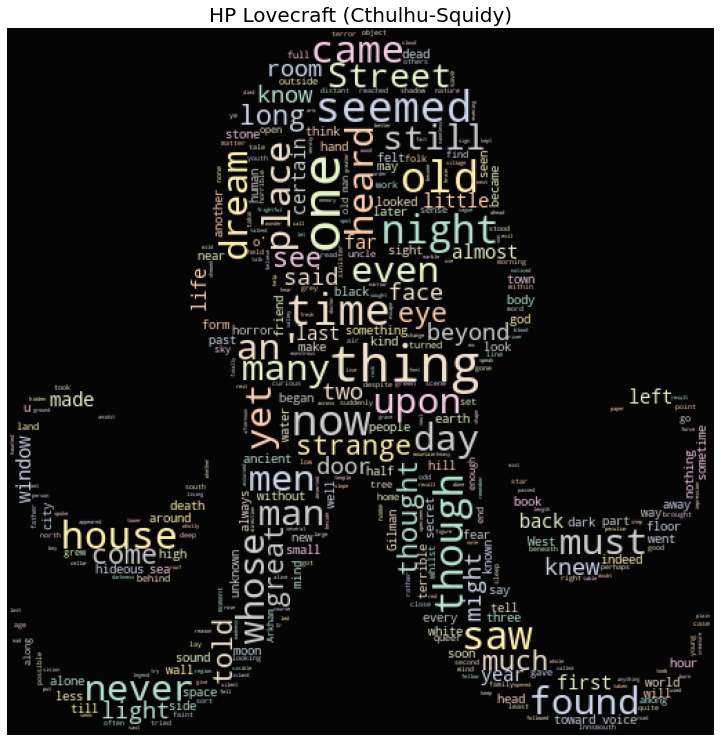

In [14]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask3, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 639.5, 390.5, -0.5)

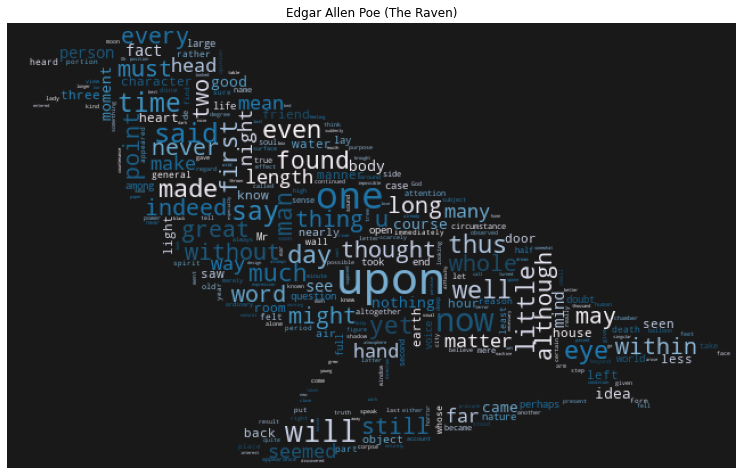

In [15]:
plt.figure(figsize=(20,18))
# The wordcloud of the raven for Edgar Allen Poe
plt.subplot(211)
wc = WordCloud(background_color="black", 
               max_words=10000, 
               mask=hcmask, 
               stopwords=STOPWORDS, 
               max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 639.5, 589.5, -0.5)

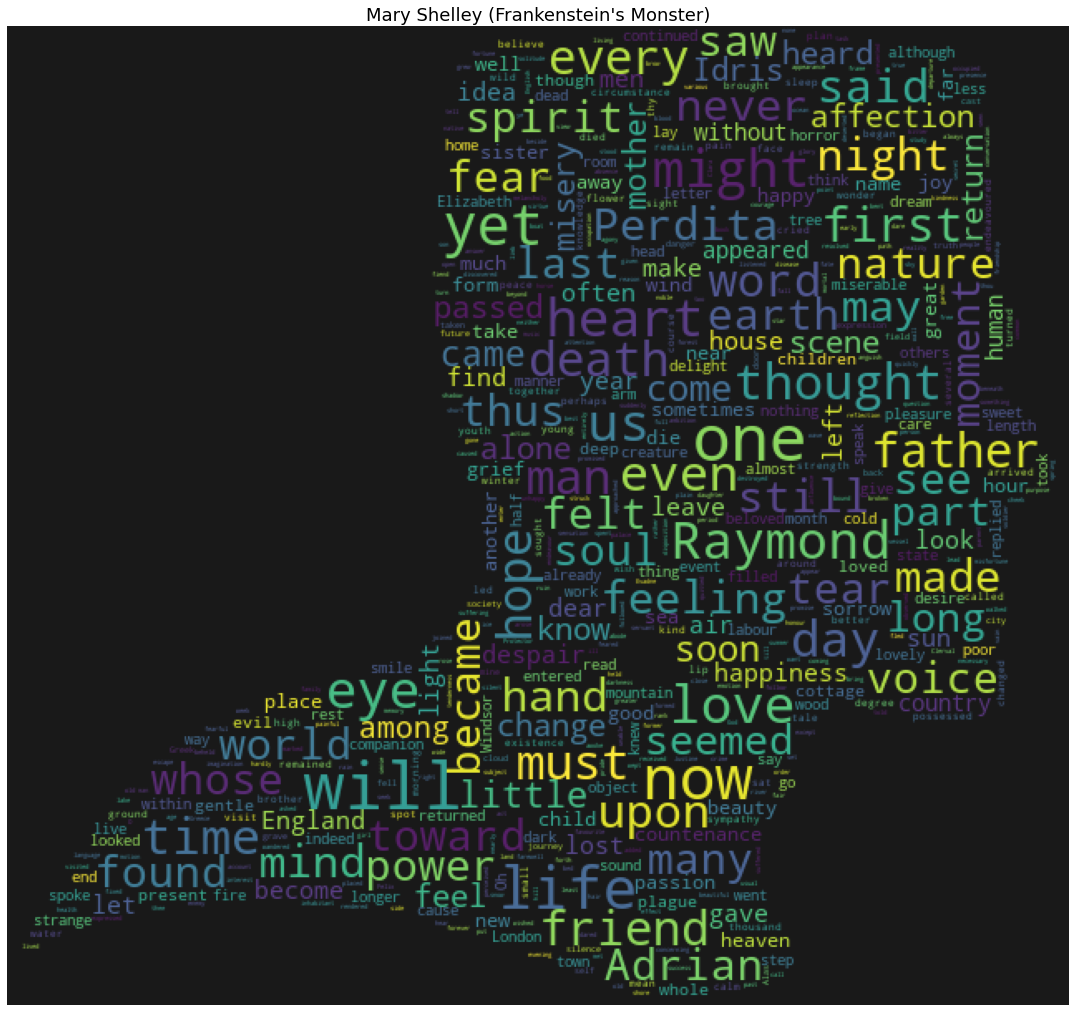

In [16]:
plt.figure(figsize=(20,18))
wc = WordCloud(background_color="black", 
               max_words=10000, 
               mask=hcmask2, 
               stopwords=STOPWORDS, 
               max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize= 18)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

# NLP
## Tokenization

In [17]:
import nltk

In [18]:
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [19]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal 

In [20]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [21]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
first_text_list_cleaned = []
for word in first_text_list:
    if word.lower() not in stopwords:
        first_text_list_cleaned.append(word)
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [24]:
stemmer = nltk.stem.PorterStemmer()

In [25]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [26]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


In [27]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


## Vectorizing Raw Text
### Bag-of-Words

In [28]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)
print(sentence_transform)

  (0, 3)	1
  (0, 4)	1
  (0, 1)	1
  (0, 0)	1
  (1, 3)	1
  (1, 4)	1
  (1, 1)	1
  (1, 2)	1


In [29]:
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [30]:
sentence_transform

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

# Topic modelling

In [31]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [32]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [35]:
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2,stop_words='english',decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [36]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## Latent Dirichlet Allocation

In [37]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,learning_method = 'online',learning_offset = 50.,random_state = 0)

In [38]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

### Topics generated by LDA

In [39]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:mean night fact young return great human looking wonder countenance difficulty greater wife finally set possessed regard struck perceived act society law health key fearful mr exceedingly evidence carried home write lady various recall accident force poet neck conduct investigation

Topic #1:death love raymond hope heart word child went time good man ground evil long misery replied filled passion bed till happiness memory heavy region year escape spirit grief visit doe story beauty die plague making influence thou letter appeared power

Topic #2:left let hand said took say little length body air secret gave right having great arm thousand character minute foot true self gentleman pleasure box clock discovered point sought pain nearly case best mere course manner balloon fear head going

Topic #3:called sense table suddenly sympathy machine sens unusual labour thrown mist solution suppose specie movement whispered urged frequent wine hour appears ring tu

In [40]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [41]:
first_topic.shape

(13781,)

### Word Cloud visualizations of the topics

In [42]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

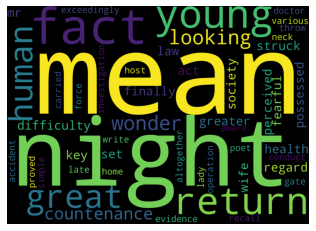

In [43]:
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

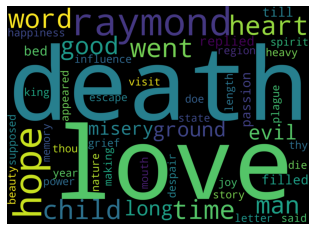

In [45]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

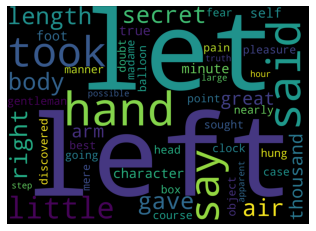

In [46]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()